In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch

from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras.backend as K
from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/bpnachman/anacon

In [2]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [3]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [4]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [5]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(keras.__version__)  # 2.2.4

1.12.0
2.2.4


# OmniFold Gaussian Toy Example

We will unfold the same data but with two cases:

(a) there are no generator MC weights from using simulation.

(b) there are generator MC weights from using simulation.

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

In [7]:
N = 10**6
# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (1, 1.5)  # this is the data (the target)
epsilon = sigma0 / 1.  # Smearing width

theta0_G = np.random.normal(theta0_param[0], theta0_param[1],
                            N)  # Generator-level synthetic sample

theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G
                     ])  # Detector smearing for synthetic sample
theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

theta_unknown_G = np.random.normal(theta_unknown_param[0],
                                   theta_unknown_param[1], N)
 
# Detector smearing for synthetic sample
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon))
                            for x in theta_unknown_G]) 
theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

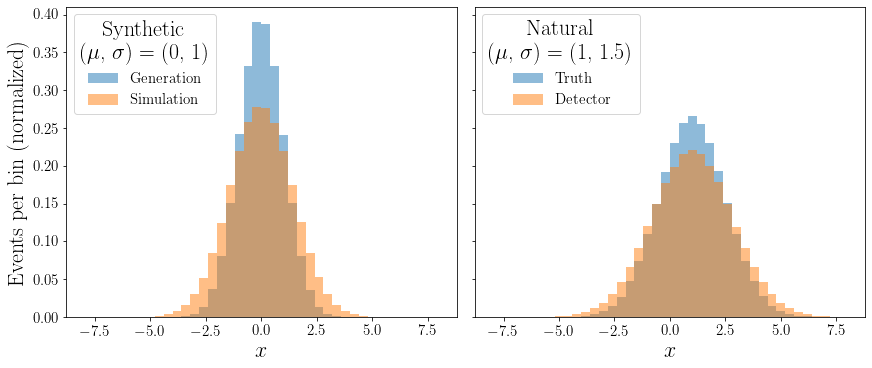

In [8]:
bins = np.linspace(-8, 8, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel('$x$')
ax[0].set_ylabel('Events per bin (normalized)')
ax[0].hist(theta0_G, bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S, bins=bins, **plot_style_2, label='Simulation')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
ax[1].hist(theta_unknown_G, bins=bins, **plot_style_2, label='Truth')
ax[1].hist(theta_unknown_S, bins=bins, **plot_style_2, label='Detector')
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=True)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [16]:
iterations = 3
bootstraps = 100

In [17]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
yvals_1 = np.concatenate((labels0, labels_unknown))

xvals_2 = np.concatenate((theta0_G, theta0_G))
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(bootstraps, iterations, 2, len(theta0)))
# shape = (bootstrap, iteration, step, event)

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

earlystopping = EarlyStopping(patience=10,
                              verbose=1,
                              restore_best_weights=True)

In [19]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=int(0.1*len(events)))
    myweights = f / (1. - f)
    return np.squeeze(myweights)

### Unfold without initial MC weights

In [20]:
for k in range(bootstraps):
    
    print("\nBOOTSTRAP: {}\n".format(k + 1))
    
    # initial iterative weights are ones

    dataweights = np.ones(len(theta_unknown_S)) #this will give you the covariance just for the NN initialization
    #dataweights = np.random.poisson(1,len(theta_unknown_S)) #this will give you the stat. covariance
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))
    
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))

        # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
        # weights reweighted Sim. --> Data
        print("STEP 1\n")

        weights_1 = np.concatenate((weights_push, dataweights))
        # actual weights for Sim., ones for Data (not MC weights)

        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
            xvals_1, yvals_1, weights_1)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_1,
                  Y_train_1,
                  sample_weight=w_train_1,
                  epochs=200,
                  batch_size=int(0.1*len(X_train_1)),
                  validation_data=(X_test_1, Y_test_1, w_test_1),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_pull = weights_push * reweight(theta0_S)
        weights[k, i, :1, :] = weights_pull

        # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
        # weights Gen. --> reweighted Gen.
        print("\nSTEP 2\n")

        weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)

        model.compile(loss='binary_crossentropy',
                      optimizer='Adam',
                      metrics=['accuracy'])
        model.fit(X_train_2,
                  Y_train_2,
                  sample_weight=w_train_2,
                  epochs=200,
                  batch_size=int(0.1*len(X_train_2)),
                  validation_data=(X_test_2, Y_test_2, w_test_2),
                  callbacks=[earlystopping],
                  verbose=1)

        weights_push = reweight(theta0_G)
        weights[k, i, 1:2, :] = weights_push


BOOTSTRAP: 1


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6714 - acc: 0.5940 - val_loss: 0.6569 - val_acc: 0.6066
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6523 - acc: 0.6087 - val_loss: 0.6475 - val_acc: 0.6137
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6452 - acc: 0.6179 - val_loss: 0.6423 - val_acc: 0.6240
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6405 - acc: 0.6271 - val_loss: 0.6388 - val_acc: 0.6283
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6378 - acc: 0.6296 - val_loss: 0.6376 - val_acc: 0.6288
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6372 - acc: 0.6301 - val_loss: 0.6375 - val_acc: 0.6288
Epoch 7/200
1500000/1500000 [==============================] - 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6290
Epoch 59/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6366 - val_acc: 0.6290
Epoch 60/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6291
Epoch 61/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6366 - val_acc: 0.6290
Epoch 62/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6366 - val_acc: 0.6290
Epoch 63/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6366 - val_acc: 0.6290
Epoch 64/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6366 - val_acc: 0.6291
Epoch 65/200
150000

Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6735 - acc: 0.6204 - val_loss: 0.6736 - val_acc: 0.6216
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6735 - acc: 0.6206 - val_loss: 0.6736 - val_acc: 0.6209
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6735 - acc: 0.6205 - val_loss: 0.6735 - val_acc: 0.6221
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6735 - acc: 0.6201 - val_loss: 0.6735 - val_acc: 0.6216
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6735 - acc: 0.6205 - val_loss: 0.6735 - val_acc: 0.6217
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6735 - acc: 0.6206 - val_loss: 0.6735 - val_acc: 0.6213
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6735 - acc: 0.6204 - val_loss: 0.6735 - val_acc: 0.6217
Epoch 

Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6263 - acc: 0.4998 - val_loss: 0.6263 - val_acc: 0.5007
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6263 - acc: 0.4997 - val_loss: 0.6264 - val_acc: 0.5007
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6263 - acc: 0.4997 - val_loss: 0.6263 - val_acc: 0.5007
Epoch 37/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6263 - acc: 0.4998 - val_loss: 0.6264 - val_acc: 0.5007
Epoch 38/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6263 - acc: 0.4998 - val_loss: 0.6263 - val_acc: 0.5007
Epoch 39/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6263 - acc: 0.4998 - val_loss: 0.6263 - val_acc: 0.5007
Epoch 40/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6263 - acc: 0.4998 - val_loss: 0.6264 - val_acc: 0.5007
Restor

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6097 - acc: 0.4997 - val_loss: 0.6090 - val_acc: 0.5007
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.4998 - val_loss: 0.6089 - val_acc: 0.5007
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6089 - acc: 0.4997 - val_loss: 0.6087 - val_acc: 0.5009
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6088 - acc: 0.4998 - val_loss: 0.6086 - val_acc: 0.5008
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.4997 - val_loss: 0.6086 - val_acc: 0.5009
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.4997 - val_loss: 0.6086 - val_acc: 0.5008
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.4997 - val_loss: 0.6086 - val_acc: 0.5008
Epoch 11/200
1500000/150

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6303
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 25/200
150000

Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4998 - val_loss: 0.6629 - val_acc: 0.5003
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6629 - val_acc: 0.5003
Restoring model weights from the end of the best epoch
Epoch 00022: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6881 - acc: 0.6255 - val_loss: 0.6748 - val_acc: 0.6127
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6746 - acc: 0.6025 - val_loss: 0.6752 - val_acc: 0.6042
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6722 - acc: 0.6149 - val_loss: 0.6739 - val_acc: 0.6224
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6720 - acc: 0.6260 - val_loss: 0.6737 - val_acc: 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6285 - acc: 0.5001 - val_loss: 0.6283 - val_acc: 0.5001
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6279 - acc: 0.4999 - val_loss: 0.6280 - val_acc: 0.5002
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6277 - acc: 0.4999 - val_loss: 0.6278 - val_acc: 0.5000
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5000 - val_loss: 0.6278 - val_acc: 0.5000
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5000 - val_loss: 0.6278 - val_acc: 0.5000
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6275 - acc: 0.5000 - val_loss: 0.6278 - val_acc: 0.5000
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6275 - acc: 0.5000 - val_loss: 0.6278 - val_acc: 0.4998
Epoch 10/200
1500000/1500

Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.4997 - val_loss: 0.6081 - val_acc: 0.5008
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.4997 - val_loss: 0.6081 - val_acc: 0.5008
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.4997 - val_loss: 0.6081 - val_acc: 0.5009
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.4997 - val_loss: 0.6081 - val_acc: 0.5009
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.4997 - val_loss: 0.6081 - val_acc: 0.5008
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.4997 - val_loss: 0.6081 - val_acc: 0.5009
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.4997 - val_loss: 0.6081 - val_acc: 0.5008
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 37/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6297
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6297
Epoch 39/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 40/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 41/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 42/200
150000

Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6638 - acc: 0.5001 - val_loss: 0.6643 - val_acc: 0.4997
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6638 - acc: 0.5001 - val_loss: 0.6643 - val_acc: 0.4996
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6638 - acc: 0.5001 - val_loss: 0.6644 - val_acc: 0.4997
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6638 - acc: 0.5001 - val_loss: 0.6643 - val_acc: 0.4997
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6638 - acc: 0.5001 - val_loss: 0.6643 - val_acc: 0.4996
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6638 - acc: 0.5001 - val_loss: 0.6644 - val_acc: 0.4998
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6638 - acc: 0.5001 - val_loss: 0.6643 - val_acc: 0.4996
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6759 - acc: 0.6200 - val_loss: 0.6756 - val_acc: 0.6216
Restoring model weights from the end of the best epoch
Epoch 00046: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 2s 1us/step - loss: 0.6509 - acc: 0.4998 - val_loss: 0.6385 - val_acc: 0.5001
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6353 - acc: 0.5000 - val_loss: 0.6330 - val_acc: 0.5002
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6301 - acc: 0.4998 - val_loss: 0.6285 - val_acc: 0.5003
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6282 - val_acc: 0.5003
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6277 - acc: 0.4999 - val_loss: 0.6279 - val_acc: 0.5004
Epoch 6/200
1500000/1

Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6849 - acc: 0.5982 - val_loss: 0.6849 - val_acc: 0.6006
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6849 - acc: 0.6004 - val_loss: 0.6849 - val_acc: 0.5976
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6849 - acc: 0.5975 - val_loss: 0.6849 - val_acc: 0.5979
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6849 - acc: 0.6009 - val_loss: 0.6849 - val_acc: 0.6011
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6849 - acc: 0.5983 - val_loss: 0.6850 - val_acc: 0.5943
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6849 - acc: 0.5962 - val_loss: 0.6849 - val_acc: 0.5997
Epoch 30/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6849 - acc: 0.6002 - val_loss: 0.6849 - val_acc: 0.5978
Epoch 

Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6091 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4996
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4996
Epoch 31/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6091 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4996
Epoch 32/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6091 - acc: 0.5002 - val_loss: 0.6098 - val_acc: 0.4996
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6091 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4996
Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6091 - acc: 0.5002 - val_loss: 0.6098 - val_acc: 0.4996
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6091 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4997
Epoch 

1500000/1500000 [==============================] - 2s 1us/step - loss: 0.6648 - acc: 0.5002 - val_loss: 0.6646 - val_acc: 0.4995
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.5002 - val_loss: 0.6633 - val_acc: 0.4995
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6632 - acc: 0.5002 - val_loss: 0.6632 - val_acc: 0.4995
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6631 - acc: 0.5001 - val_loss: 0.6632 - val_acc: 0.4997
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.5002 - val_loss: 0.6631 - val_acc: 0.4996
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.5001 - val_loss: 0.6632 - val_acc: 0.4997
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.5001 - val_loss: 0.6631 - val_acc: 0.4996
Epoch 8/200
1500000/15000

Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6721 - acc: 0.6213 - val_loss: 0.6718 - val_acc: 0.6222
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6721 - acc: 0.6214 - val_loss: 0.6718 - val_acc: 0.6219
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6721 - acc: 0.6212 - val_loss: 0.6718 - val_acc: 0.6221
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6721 - acc: 0.6213 - val_loss: 0.6718 - val_acc: 0.6223
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6721 - acc: 0.6211 - val_loss: 0.6718 - val_acc: 0.6217
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6721 - acc: 0.6214 - val_loss: 0.6718 - val_acc: 0.6222
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6721 - acc: 0.6212 - val_loss: 0.6718 - val_acc: 0.6220
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7019 - acc: 0.5581 - val_loss: 0.6998 - val_acc: 0.5601
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6953 - acc: 0.5752 - val_loss: 0.6953 - val_acc: 0.5925
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6926 - acc: 0.5966 - val_loss: 0.6937 - val_acc: 0.5998
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6913 - acc: 0.5976 - val_loss: 0.6926 - val_acc: 0.5953
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6906 - acc: 0.5981 - val_loss: 0.6925 - val_acc: 0.6043
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6906 - acc: 0.6045 - val_loss: 0.6924 - val_acc: 0.6059
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6906 - acc: 0.6053 - val_loss: 0.6924 - val_acc: 0.6018
Epoch 10/200
1500000/1500

Epoch 61/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6906 - acc: 0.5965 - val_loss: 0.6923 - val_acc: 0.5987
Epoch 62/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6906 - acc: 0.5997 - val_loss: 0.6923 - val_acc: 0.5965
Epoch 63/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6906 - acc: 0.5979 - val_loss: 0.6923 - val_acc: 0.5999
Epoch 64/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6905 - acc: 0.5969 - val_loss: 0.6923 - val_acc: 0.5979
Epoch 65/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6905 - acc: 0.5993 - val_loss: 0.6923 - val_acc: 0.5997
Epoch 66/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6905 - acc: 0.5992 - val_loss: 0.6923 - val_acc: 0.5976
Epoch 67/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6905 - acc: 0.5960 - val_loss: 0.6923 - val_acc: 0.5989
Restor

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6368 - acc: 0.6295 - val_loss: 0.6364 - val_acc: 0.6306
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6367 - acc: 0.6295 - val_loss: 0.6364 - val_acc: 0.6307
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6366 - acc: 0.6296 - val_loss: 0.6363 - val_acc: 0.6308
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6366 - acc: 0.6296 - val_loss: 0.6362 - val_acc: 0.6308
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6297 - val_loss: 0.6362 - val_acc: 0.6308
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6296 - val_loss: 0.6362 - val_acc: 0.6308
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6297 - val_loss: 0.6362 - val_acc: 0.6308
Epoch 11/200
1500000/150

Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6642 - acc: 0.5001 - val_loss: 0.6640 - val_acc: 0.4997
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6642 - acc: 0.5001 - val_loss: 0.6640 - val_acc: 0.4997
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6642 - acc: 0.5001 - val_loss: 0.6640 - val_acc: 0.4997
Restoring model weights from the end of the best epoch
Epoch 00016: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.7002 - acc: 0.6268 - val_loss: 0.6784 - val_acc: 0.6259
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6794 - acc: 0.6122 - val_loss: 0.6794 - val_acc: 0.6023
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6793 - acc: 0.6060 - val_loss: 0.6768 - val_acc:

1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6521 - acc: 0.5000 - val_loss: 0.6389 - val_acc: 0.5006
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6346 - acc: 0.4999 - val_loss: 0.6313 - val_acc: 0.5003
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6298 - acc: 0.5001 - val_loss: 0.6277 - val_acc: 0.5005
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6277 - acc: 0.4999 - val_loss: 0.6272 - val_acc: 0.5004
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.4998 - val_loss: 0.6270 - val_acc: 0.5006
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6272 - acc: 0.4998 - val_loss: 0.6269 - val_acc: 0.5006
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6271 - acc: 0.4998 - val_loss: 0.6268 - val_acc: 0.5007
Epoch 8/200
1500000/15000

Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6891 - acc: 0.5931 - val_loss: 0.6910 - val_acc: 0.5890
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6886 - acc: 0.5908 - val_loss: 0.6907 - val_acc: 0.5929
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6885 - acc: 0.5936 - val_loss: 0.6907 - val_acc: 0.5950
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6885 - acc: 0.5963 - val_loss: 0.6907 - val_acc: 0.5960
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5958 - val_loss: 0.6907 - val_acc: 0.5971
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5967 - val_loss: 0.6906 - val_acc: 0.5941
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6885 - acc: 0.5939 - val_loss: 0.6906 - val_acc: 0.5944
Epoch 14/

Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6067 - acc: 0.5001 - val_loss: 0.6071 - val_acc: 0.4996
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6067 - acc: 0.5001 - val_loss: 0.6071 - val_acc: 0.4996
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6067 - acc: 0.5001 - val_loss: 0.6071 - val_acc: 0.4996
Epoch 37/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6067 - acc: 0.5002 - val_loss: 0.6071 - val_acc: 0.4996
Epoch 38/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6067 - acc: 0.5002 - val_loss: 0.6070 - val_acc: 0.4996
Epoch 39/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6067 - acc: 0.5001 - val_loss: 0.6071 - val_acc: 0.4996
Epoch 40/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6067 - acc: 0.5002 - val_loss: 0.6071 - val_acc: 0.4996
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 40/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 41/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6301
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 43/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 44/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6301
Epoch 45/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6301
Epoch 46/200
150000

Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6620 - acc: 0.5000 - val_loss: 0.6618 - val_acc: 0.5001
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6620 - acc: 0.4999 - val_loss: 0.6618 - val_acc: 0.5002
Restoring model weights from the end of the best epoch
Epoch 00017: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.6912 - acc: 0.6274 - val_loss: 0.6721 - val_acc: 0.6269
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6732 - acc: 0.6149 - val_loss: 0.6737 - val_acc: 0.6033
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6735 - acc: 0.6080 - val_loss: 0.6713 - val_acc: 0.6173
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6720 - acc: 0.6218 - val_loss: 0.6710 - val_acc: 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.5000 - val_loss: 0.6278 - val_acc: 0.5000
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.5000 - val_loss: 0.6278 - val_acc: 0.5000
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.5000 - val_loss: 0.6278 - val_acc: 0.4999
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.5000 - val_loss: 0.6278 - val_acc: 0.5000
Restoring model weights from the end of the best epoch
Epoch 00023: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 3s 2us/step - loss: 0.8006 - acc: 0.6270 - val_loss: 0.7285 - val_acc: 0.6227
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.7162 - acc: 0.6110 - val_loss: 0.6970 - val_acc: 0.5894
Epoc

Epoch 30/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.4999 - val_loss: 0.6091 - val_acc: 0.5003
Epoch 31/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.4999 - val_loss: 0.6091 - val_acc: 0.5003
Epoch 32/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.4999 - val_loss: 0.6091 - val_acc: 0.5003
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.4999 - val_loss: 0.6091 - val_acc: 0.5003
Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.4999 - val_loss: 0.6091 - val_acc: 0.5004
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.4999 - val_loss: 0.6091 - val_acc: 0.5003
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.4999 - val_loss: 0.6091 - val_acc: 0.5003
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6307
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6307
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6359 - val_acc: 0.6307
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6307
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6307
Epoch 37/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6307
Epoch 38/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6308
Epoch 39/200
150000

Epoch 12/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6213 - val_loss: 0.6755 - val_acc: 0.6206
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6213 - val_loss: 0.6755 - val_acc: 0.6206
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6213 - val_loss: 0.6755 - val_acc: 0.6207
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6213 - val_loss: 0.6755 - val_acc: 0.6205
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6212 - val_loss: 0.6755 - val_acc: 0.6205
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6211 - val_loss: 0.6755 - val_acc: 0.6202
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6211 - val_loss: 0.6755 - val_acc: 0.6203
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6208 - val_loss: 0.6754 - val_acc: 0.6205
Epoch 70/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6216 - val_loss: 0.6754 - val_acc: 0.6206
Epoch 71/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6211 - val_loss: 0.6754 - val_acc: 0.6207
Epoch 72/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6213 - val_loss: 0.6754 - val_acc: 0.6206
Epoch 73/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6213 - val_loss: 0.6754 - val_acc: 0.6205
Epoch 74/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6214 - val_loss: 0.6754 - val_acc: 0.6204
Restoring model weights from the end of the best epoch
Epoch 00074: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500

Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6956 - acc: 0.5661 - val_loss: 0.6953 - val_acc: 0.5678
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6917 - acc: 0.5799 - val_loss: 0.6920 - val_acc: 0.5947
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6895 - acc: 0.6020 - val_loss: 0.6905 - val_acc: 0.6079
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6884 - acc: 0.6089 - val_loss: 0.6895 - val_acc: 0.6079
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6878 - acc: 0.6013 - val_loss: 0.6891 - val_acc: 0.5965
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6876 - acc: 0.5981 - val_loss: 0.6890 - val_acc: 0.5984
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6875 - acc: 0.5971 - val_loss: 0.6890 - val_acc: 0.6012
Epoch 11/200

Epoch 62/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.5941 - val_loss: 0.6887 - val_acc: 0.5945
Epoch 63/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.6004 - val_loss: 0.6888 - val_acc: 0.6027
Epoch 64/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6875 - acc: 0.5961 - val_loss: 0.6887 - val_acc: 0.5929
Epoch 65/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.5981 - val_loss: 0.6887 - val_acc: 0.6004
Epoch 66/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.5998 - val_loss: 0.6887 - val_acc: 0.5986
Epoch 67/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.5982 - val_loss: 0.6887 - val_acc: 0.5959
Epoch 68/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.5964 - val_loss: 0.6887 - val_acc: 0.5974
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.5962 - val_loss: 0.6886 - val_acc: 0.5954
Epoch 120/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.5981 - val_loss: 0.6887 - val_acc: 0.6020
Epoch 121/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.5978 - val_loss: 0.6886 - val_acc: 0.5918
Epoch 122/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.5986 - val_loss: 0.6886 - val_acc: 0.6008
Epoch 123/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.5963 - val_loss: 0.6886 - val_acc: 0.5919
Epoch 124/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6874 - acc: 0.5970 - val_loss: 0.6886 - val_acc: 0.6000
Restoring model weights from the end of the best epoch
Epoch 00124: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200

1500000/1500000 [==============================] - 4s 3us/step - loss: 0.6493 - acc: 0.6285 - val_loss: 0.6387 - val_acc: 0.6286
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6385 - acc: 0.6269 - val_loss: 0.6380 - val_acc: 0.6274
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6373 - acc: 0.6284 - val_loss: 0.6363 - val_acc: 0.6303
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6367 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6298
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6303
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 8/200
1500000/15000

Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6225 - val_loss: 0.6747 - val_acc: 0.6219
Epoch 12/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6223 - val_loss: 0.6747 - val_acc: 0.6221
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6222 - val_loss: 0.6747 - val_acc: 0.6219
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6221 - val_loss: 0.6747 - val_acc: 0.6216
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6222 - val_loss: 0.6747 - val_acc: 0.6219
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6750 - acc: 0.6220 - val_loss: 0.6747 - val_acc: 0.6216
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6223 - val_loss: 0.6747 - val_acc: 0.6218
Epoch 

1500000/1500000 [==============================] - 5s 3us/step - loss: 0.8104 - acc: 0.6254 - val_loss: 0.7366 - val_acc: 0.6219
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.7240 - acc: 0.6139 - val_loss: 0.6991 - val_acc: 0.6040
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7000 - acc: 0.5955 - val_loss: 0.6916 - val_acc: 0.5884
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6937 - acc: 0.5891 - val_loss: 0.6881 - val_acc: 0.5944
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6906 - acc: 0.6011 - val_loss: 0.6863 - val_acc: 0.6078
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6893 - acc: 0.6066 - val_loss: 0.6859 - val_acc: 0.6065
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6888 - acc: 0.6053 - val_loss: 0.6859 - val_acc: 0.6059
Epoch 8/200
1500000/15000

Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.4999 - val_loss: 0.6088 - val_acc: 0.5004
Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6086 - acc: 0.4999 - val_loss: 0.6088 - val_acc: 0.5005
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6086 - acc: 0.4999 - val_loss: 0.6088 - val_acc: 0.5004
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6087 - acc: 0.4999 - val_loss: 0.6088 - val_acc: 0.5004
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.4998 - val_loss: 0.6088 - val_acc: 0.5003
Epoch 38/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6086 - acc: 0.4999 - val_loss: 0.6088 - val_acc: 0.5005
Epoch 39/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6086 - acc: 0.4998 - val_loss: 0.6088 - val_acc: 0.5004
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6369 - val_acc: 0.6296
Epoch 32/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6369 - val_acc: 0.6296
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6369 - val_acc: 0.6297
Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6296
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6369 - val_acc: 0.6296
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6369 - val_acc: 0.6296
Epoch 37/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6369 - val_acc: 0.6297
Epoch 38/200
150000

Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6640 - acc: 0.4998 - val_loss: 0.6626 - val_acc: 0.5006
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6640 - acc: 0.4998 - val_loss: 0.6626 - val_acc: 0.5006
Restoring model weights from the end of the best epoch
Epoch 00035: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 5s 4us/step - loss: 0.6963 - acc: 0.6275 - val_loss: 0.6751 - val_acc: 0.6268
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6175 - val_loss: 0.6735 - val_acc: 0.6078
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6073 - val_loss: 0.6727 - val_acc: 0.6116
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6735 - acc: 0.6173 - val_loss: 0.6717 - val_acc: 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5000 - val_loss: 0.6281 - val_acc: 0.5001
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5000 - val_loss: 0.6281 - val_acc: 0.5001
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.5000 - val_loss: 0.6281 - val_acc: 0.5001
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5000 - val_loss: 0.6281 - val_acc: 0.5001
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5000 - val_loss: 0.6281 - val_acc: 0.5001
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5000 - val_loss: 0.6281 - val_acc: 0.5001
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5000 - val_loss: 0.6281 - val_acc: 0.5001
Epoch 24/200
150000

Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6078 - acc: 0.5002 - val_loss: 0.6086 - val_acc: 0.4994
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5002 - val_loss: 0.6086 - val_acc: 0.4994
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6078 - acc: 0.5002 - val_loss: 0.6086 - val_acc: 0.4994
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5002 - val_loss: 0.6086 - val_acc: 0.4995
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5002 - val_loss: 0.6086 - val_acc: 0.4995
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6078 - acc: 0.5002 - val_loss: 0.6086 - val_acc: 0.4994
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6078 - acc: 0.5002 - val_loss: 0.6086 - val_acc: 0.4994
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6303
Epoch 30/200
150000

Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6210 - val_loss: 0.6763 - val_acc: 0.6203
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6768 - acc: 0.6212 - val_loss: 0.6763 - val_acc: 0.6200
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6210 - val_loss: 0.6763 - val_acc: 0.6200
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6208 - val_loss: 0.6763 - val_acc: 0.6200
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6768 - acc: 0.6211 - val_loss: 0.6763 - val_acc: 0.6200
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6768 - acc: 0.6210 - val_loss: 0.6763 - val_acc: 0.6200
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6768 - acc: 0.6211 - val_loss: 0.6763 - val_acc: 0.6201
Epoch 1

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6768 - acc: 0.6212 - val_loss: 0.6763 - val_acc: 0.6199
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6213 - val_loss: 0.6763 - val_acc: 0.6203
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6208 - val_loss: 0.6763 - val_acc: 0.6197
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6213 - val_loss: 0.6763 - val_acc: 0.6205
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6209 - val_loss: 0.6763 - val_acc: 0.6197
Epoch 71/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6768 - acc: 0.6208 - val_loss: 0.6763 - val_acc: 0.6206
Epoch 72/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6215 - val_loss: 0.6763 - val_acc: 0.6203
Epoch 73/200
150000

Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6913 - acc: 0.5947 - val_loss: 0.6906 - val_acc: 0.5972
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6913 - acc: 0.5975 - val_loss: 0.6906 - val_acc: 0.5986
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6913 - acc: 0.5995 - val_loss: 0.6906 - val_acc: 0.5990
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6913 - acc: 0.5960 - val_loss: 0.6906 - val_acc: 0.5946
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6913 - acc: 0.5942 - val_loss: 0.6906 - val_acc: 0.5964
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6913 - acc: 0.5988 - val_loss: 0.6906 - val_acc: 0.5988
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6913 - acc: 0.5954 - val_loss: 0.6906 - val_acc: 0.5947
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6361 - val_acc: 0.6305
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6305
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6304
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6305
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6305
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6305
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6305
Epoch 16/200
150000

Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6634 - acc: 0.4998 - val_loss: 0.6638 - val_acc: 0.5006
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6635 - acc: 0.4998 - val_loss: 0.6638 - val_acc: 0.5006
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6634 - acc: 0.4998 - val_loss: 0.6638 - val_acc: 0.5006
Epoch 37/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6634 - acc: 0.4998 - val_loss: 0.6638 - val_acc: 0.5006
Epoch 38/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6634 - acc: 0.4998 - val_loss: 0.6638 - val_acc: 0.5006
Epoch 39/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6634 - acc: 0.4998 - val_loss: 0.6638 - val_acc: 0.5005
Epoch 40/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6634 - acc: 0.4998 - val_loss: 0.6638 - val_acc: 0.5005
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6283 - acc: 0.5001 - val_loss: 0.6293 - val_acc: 0.4998
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6283 - acc: 0.5001 - val_loss: 0.6293 - val_acc: 0.4998
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6283 - acc: 0.5001 - val_loss: 0.6293 - val_acc: 0.4998
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6282 - acc: 0.5001 - val_loss: 0.6293 - val_acc: 0.4998
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6282 - acc: 0.5001 - val_loss: 0.6293 - val_acc: 0.4998
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6282 - acc: 0.5001 - val_loss: 0.6293 - val_acc: 0.4998
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6282 - acc: 0.5001 - val_loss: 0.6293 - val_acc: 0.4998
Epoch 18/200
150000

Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6897 - acc: 0.5987 - val_loss: 0.6881 - val_acc: 0.5955
Epoch 30/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6897 - acc: 0.5948 - val_loss: 0.6881 - val_acc: 0.5940
Epoch 31/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6897 - acc: 0.5989 - val_loss: 0.6881 - val_acc: 0.5976
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6897 - acc: 0.5960 - val_loss: 0.6882 - val_acc: 0.5925
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6897 - acc: 0.5932 - val_loss: 0.6881 - val_acc: 0.5963
Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6897 - acc: 0.6011 - val_loss: 0.6881 - val_acc: 0.5965
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6897 - acc: 0.5915 - val_loss: 0.6882 - val_acc: 0.5893
Epoch 

Epoch 40/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.5001 - val_loss: 0.6096 - val_acc: 0.4996
Epoch 41/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.5001 - val_loss: 0.6096 - val_acc: 0.4996
Epoch 42/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.5001 - val_loss: 0.6096 - val_acc: 0.4996
Epoch 43/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.5001 - val_loss: 0.6096 - val_acc: 0.4996
Epoch 44/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.5001 - val_loss: 0.6096 - val_acc: 0.4995
Epoch 45/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.5002 - val_loss: 0.6096 - val_acc: 0.4996
Epoch 46/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.5001 - val_loss: 0.6096 - val_acc: 0.4996
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6301
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6301
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6301
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6301
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6301
Epoch 47/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6301
Epoch 48/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6364 - val_acc: 0.6301
Epoch 49/200
150000

Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6736 - acc: 0.6220 - val_loss: 0.6734 - val_acc: 0.6220
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6736 - acc: 0.6219 - val_loss: 0.6734 - val_acc: 0.6214
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6736 - acc: 0.6216 - val_loss: 0.6734 - val_acc: 0.6215
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6736 - acc: 0.6218 - val_loss: 0.6734 - val_acc: 0.6216
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6736 - acc: 0.6216 - val_loss: 0.6734 - val_acc: 0.6214
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6736 - acc: 0.6216 - val_loss: 0.6734 - val_acc: 0.6216
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6736 - acc: 0.6219 - val_loss: 0.6734 - val_acc: 0.6218
Epoch 

Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5002 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5002 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5002 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.5002 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5002 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5002 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.5002 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5994 - val_loss: 0.6879 - val_acc: 0.5971
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5967 - val_loss: 0.6879 - val_acc: 0.5953
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6889 - acc: 0.5985 - val_loss: 0.6878 - val_acc: 0.5977
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5990 - val_loss: 0.6879 - val_acc: 0.5957
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5959 - val_loss: 0.6878 - val_acc: 0.5949
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6890 - acc: 0.5995 - val_loss: 0.6878 - val_acc: 0.5975
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5971 - val_loss: 0.6878 - val_acc: 0.5953
Epoch 38/200
150000

Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6092 - acc: 0.4996 - val_loss: 0.6085 - val_acc: 0.5012
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6092 - acc: 0.4996 - val_loss: 0.6084 - val_acc: 0.5012
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.4996 - val_loss: 0.6084 - val_acc: 0.5012
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.4996 - val_loss: 0.6084 - val_acc: 0.5012
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.4996 - val_loss: 0.6084 - val_acc: 0.5012
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.4996 - val_loss: 0.6084 - val_acc: 0.5012
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.4996 - val_loss: 0.6084 - val_acc: 0.5012
Epoch 1

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6363 - val_acc: 0.6299
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6363 - val_acc: 0.6300
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6363 - val_acc: 0.6300
Epoch 30/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6363 - val_acc: 0.6300
Epoch 31/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6363 - val_acc: 0.6300
Epoch 32/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6363 - val_acc: 0.6299
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6363 - val_acc: 0.6300
Epoch 34/200
150000

Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6228 - val_loss: 0.6759 - val_acc: 0.6220
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6760 - acc: 0.6224 - val_loss: 0.6759 - val_acc: 0.6217
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6760 - acc: 0.6224 - val_loss: 0.6759 - val_acc: 0.6218
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6760 - acc: 0.6225 - val_loss: 0.6759 - val_acc: 0.6218
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6223 - val_loss: 0.6759 - val_acc: 0.6217
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6760 - acc: 0.6221 - val_loss: 0.6759 - val_acc: 0.6217
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6760 - acc: 0.6221 - val_loss: 0.6759 - val_acc: 0.6216
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6879 - acc: 0.6031 - val_loss: 0.6867 - val_acc: 0.6039
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6879 - acc: 0.6037 - val_loss: 0.6867 - val_acc: 0.6015
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6879 - acc: 0.6025 - val_loss: 0.6867 - val_acc: 0.6024
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6879 - acc: 0.6028 - val_loss: 0.6867 - val_acc: 0.6026
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6879 - acc: 0.6020 - val_loss: 0.6868 - val_acc: 0.6010
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6879 - acc: 0.6010 - val_loss: 0.6867 - val_acc: 0.6002
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6878 - acc: 0.6026 - val_loss: 0.6867 - val_acc: 0.6019
Epoch 20/200
150000

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6296
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6296
Epoch 11/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6297
Epoch 12/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6296
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6295
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6297
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6296
Epoch 16/200
150000

Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6741 - acc: 0.6231 - val_loss: 0.6723 - val_acc: 0.6231
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6741 - acc: 0.6232 - val_loss: 0.6723 - val_acc: 0.6231
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6741 - acc: 0.6233 - val_loss: 0.6723 - val_acc: 0.6232
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6741 - acc: 0.6232 - val_loss: 0.6723 - val_acc: 0.6229
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6741 - acc: 0.6230 - val_loss: 0.6723 - val_acc: 0.6230
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6741 - acc: 0.6232 - val_loss: 0.6723 - val_acc: 0.6231
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6741 - acc: 0.6230 - val_loss: 0.6723 - val_acc: 0.6229
Epoch 

Epoch 42/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6287 - acc: 0.4998 - val_loss: 0.6287 - val_acc: 0.5007
Epoch 43/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6287 - acc: 0.4998 - val_loss: 0.6287 - val_acc: 0.5006
Epoch 44/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6287 - acc: 0.4998 - val_loss: 0.6287 - val_acc: 0.5007
Epoch 45/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6287 - acc: 0.4997 - val_loss: 0.6287 - val_acc: 0.5008
Epoch 46/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6287 - acc: 0.4998 - val_loss: 0.6287 - val_acc: 0.5007
Epoch 47/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6287 - acc: 0.4998 - val_loss: 0.6287 - val_acc: 0.5007
Epoch 48/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6287 - acc: 0.4997 - val_loss: 0.6287 - val_acc: 0.5007
Restor

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6891 - acc: 0.5996 - val_loss: 0.6905 - val_acc: 0.5971
Epoch 51/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6891 - acc: 0.5969 - val_loss: 0.6905 - val_acc: 0.5963
Restoring model weights from the end of the best epoch
Epoch 00051: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 8s 6us/step - loss: 0.6607 - acc: 0.4997 - val_loss: 0.6452 - val_acc: 0.5011
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6331 - acc: 0.4996 - val_loss: 0.6245 - val_acc: 0.5012
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6198 - acc: 0.4997 - val_loss: 0.6158 - val_acc: 0.5012
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6136 - acc: 0.4997 - val_loss: 0.6111 - val_acc: 0.5010
Epoch 5/200
1500000/

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6358 - val_acc: 0.6306
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6358 - val_acc: 0.6306
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6358 - val_acc: 0.6306
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6358 - val_acc: 0.6306
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6358 - val_acc: 0.6306
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6358 - val_acc: 0.6306
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6358 - val_acc: 0.6306
Epoch 22/200
150000

Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.4999 - val_loss: 0.6639 - val_acc: 0.5004
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6633 - acc: 0.4999 - val_loss: 0.6638 - val_acc: 0.5004
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.4998 - val_loss: 0.6638 - val_acc: 0.5004
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6632 - acc: 0.4999 - val_loss: 0.6638 - val_acc: 0.5003
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6632 - acc: 0.4998 - val_loss: 0.6638 - val_acc: 0.5004
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6632 - acc: 0.4999 - val_loss: 0.6638 - val_acc: 0.5004
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6632 - acc: 0.4998 - val_loss: 0.6638 - val_acc: 0.5004
Epoch 11/200

Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6280 - acc: 0.5000 - val_loss: 0.6283 - val_acc: 0.5001
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6280 - acc: 0.5000 - val_loss: 0.6283 - val_acc: 0.5001
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6280 - acc: 0.5000 - val_loss: 0.6283 - val_acc: 0.5001
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6280 - acc: 0.5000 - val_loss: 0.6283 - val_acc: 0.5001
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6280 - acc: 0.5000 - val_loss: 0.6283 - val_acc: 0.5001
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6280 - acc: 0.5000 - val_loss: 0.6283 - val_acc: 0.5001
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6280 - acc: 0.5000 - val_loss: 0.6283 - val_acc: 0.5001
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6087 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5000
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5000
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5000
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5000
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5000
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6087 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5000
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6087 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5000
Epoch 22/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6630 - val_acc: 0.5005
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6630 - val_acc: 0.5005
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6630 - val_acc: 0.5004
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6630 - val_acc: 0.5005
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4998 - val_loss: 0.6630 - val_acc: 0.5005
Epoch 11/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6630 - val_acc: 0.5004
Epoch 12/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6630 - val_acc: 0.5005
Epoch 13/200
1500000/1

1500000/1500000 [==============================] - 10s 6us/step - loss: 0.8017 - acc: 0.6271 - val_loss: 0.7417 - val_acc: 0.6247
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.7208 - acc: 0.6156 - val_loss: 0.7022 - val_acc: 0.5990
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7002 - acc: 0.5845 - val_loss: 0.6963 - val_acc: 0.5690
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6948 - acc: 0.5680 - val_loss: 0.6909 - val_acc: 0.5696
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6897 - acc: 0.5805 - val_loss: 0.6869 - val_acc: 0.5973
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6874 - acc: 0.6041 - val_loss: 0.6858 - val_acc: 0.6056
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6864 - acc: 0.6043 - val_loss: 0.6853 - val_acc: 0.5980
Epoch 8/200
1500000/1500

Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6075 - acc: 0.5000 - val_loss: 0.6074 - val_acc: 0.5003
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6075 - acc: 0.4999 - val_loss: 0.6074 - val_acc: 0.5002
Epoch 37/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6075 - acc: 0.4999 - val_loss: 0.6074 - val_acc: 0.5002
Epoch 38/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6075 - acc: 0.4999 - val_loss: 0.6074 - val_acc: 0.5002
Epoch 39/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6075 - acc: 0.4999 - val_loss: 0.6074 - val_acc: 0.5002
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5000 - val_loss: 0.6074 - val_acc: 0.5002
Epoch 41/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6075 - acc: 0.4999 - val_loss: 0.6074 - val_acc: 0.5002
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6370 - acc: 0.6295 - val_loss: 0.6365 - val_acc: 0.6307
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6367 - acc: 0.6291 - val_loss: 0.6363 - val_acc: 0.6307
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6366 - acc: 0.6295 - val_loss: 0.6363 - val_acc: 0.6308
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6297 - val_loss: 0.6362 - val_acc: 0.6308
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6297 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6297 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6308
Epoch 11/200
1500000/150

Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6631 - acc: 0.4998 - val_loss: 0.6632 - val_acc: 0.5010
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6631 - acc: 0.4997 - val_loss: 0.6632 - val_acc: 0.5008
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6631 - acc: 0.4997 - val_loss: 0.6632 - val_acc: 0.5008
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6631 - acc: 0.4997 - val_loss: 0.6632 - val_acc: 0.5009
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6631 - acc: 0.4997 - val_loss: 0.6632 - val_acc: 0.5009
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6631 - acc: 0.4997 - val_loss: 0.6632 - val_acc: 0.5010
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6631 - acc: 0.4997 - val_loss: 0.6632 - val_acc: 0.5008
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6765 - acc: 0.6215 - val_loss: 0.6762 - val_acc: 0.6215
Epoch 50/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6765 - acc: 0.6207 - val_loss: 0.6762 - val_acc: 0.6210
Epoch 51/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6765 - acc: 0.6214 - val_loss: 0.6762 - val_acc: 0.6214
Epoch 52/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6765 - acc: 0.6210 - val_loss: 0.6762 - val_acc: 0.6209
Epoch 53/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6765 - acc: 0.6209 - val_loss: 0.6762 - val_acc: 0.6208
Epoch 54/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6765 - acc: 0.6207 - val_loss: 0.6762 - val_acc: 0.6211
Epoch 55/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6765 - acc: 0.6214 - val_loss: 0.6762 - val_acc: 0.6209
Epoch 56/200
150000

Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6282 - val_acc: 0.5003
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6282 - val_acc: 0.5003
Epoch 31/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6282 - val_acc: 0.5004
Epoch 32/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6282 - val_acc: 0.5004
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6283 - val_acc: 0.5003
Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6283 - val_acc: 0.5004
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6282 - val_acc: 0.5004
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6085 - acc: 0.5001 - val_loss: 0.6090 - val_acc: 0.4996
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6085 - acc: 0.5001 - val_loss: 0.6090 - val_acc: 0.4996
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6085 - acc: 0.5001 - val_loss: 0.6090 - val_acc: 0.4996
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6085 - acc: 0.5002 - val_loss: 0.6090 - val_acc: 0.4995
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6085 - acc: 0.5002 - val_loss: 0.6090 - val_acc: 0.4996
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6085 - acc: 0.5001 - val_loss: 0.6090 - val_acc: 0.4996
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6085 - acc: 0.5001 - val_loss: 0.6090 - val_acc: 0.4995
Epoch 30/200
150000

1500000/1500000 [==============================] - 11s 7us/step - loss: 0.6654 - acc: 0.5003 - val_loss: 0.6644 - val_acc: 0.5000
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6640 - acc: 0.5000 - val_loss: 0.6635 - val_acc: 0.5001
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6635 - acc: 0.4999 - val_loss: 0.6636 - val_acc: 0.5001
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6634 - acc: 0.5000 - val_loss: 0.6635 - val_acc: 0.5000
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6634 - acc: 0.5001 - val_loss: 0.6635 - val_acc: 0.5001
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.5000 - val_loss: 0.6635 - val_acc: 0.5000
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.4999 - val_loss: 0.6635 - val_acc: 0.5001
Epoch 8/200
1500000/1500

Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6749 - acc: 0.6208 - val_loss: 0.6761 - val_acc: 0.6203
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6749 - acc: 0.6205 - val_loss: 0.6761 - val_acc: 0.6206
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6749 - acc: 0.6207 - val_loss: 0.6761 - val_acc: 0.6205
Restoring model weights from the end of the best epoch
Epoch 00036: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 11s 7us/step - loss: 0.6518 - acc: 0.5001 - val_loss: 0.6384 - val_acc: 0.4999
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6341 - acc: 0.5001 - val_loss: 0.6313 - val_acc: 0.4995
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6303 - acc: 0.5002 - val_loss: 0.6286 - val_acc: 0.4998
Epoch

1500000/1500000 [==============================] - 11s 7us/step - loss: 0.6495 - acc: 0.5001 - val_loss: 0.6275 - val_acc: 0.5001
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6200 - acc: 0.5000 - val_loss: 0.6136 - val_acc: 0.5001
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.5002 - val_loss: 0.6080 - val_acc: 0.5001
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6072 - acc: 0.5001 - val_loss: 0.6073 - val_acc: 0.5001
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6069 - acc: 0.5000 - val_loss: 0.6072 - val_acc: 0.5001
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6068 - acc: 0.5000 - val_loss: 0.6070 - val_acc: 0.5001
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6067 - acc: 0.5000 - val_loss: 0.6069 - val_acc: 0.5001
Epoch 8/200
1500000/1500

1500000/1500000 [==============================] - 11s 7us/step - loss: 0.6490 - acc: 0.6273 - val_loss: 0.6399 - val_acc: 0.6254
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6399 - acc: 0.6249 - val_loss: 0.6373 - val_acc: 0.6282
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6371 - acc: 0.6296 - val_loss: 0.6372 - val_acc: 0.6302
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6367 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6301
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6366 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6301
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6301
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6364 - val_acc: 0.6301
Epoch 8/200
1500000/1500

Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6608 - acc: 0.5002 - val_loss: 0.6615 - val_acc: 0.4994
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6608 - acc: 0.5002 - val_loss: 0.6615 - val_acc: 0.4996
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6608 - acc: 0.5002 - val_loss: 0.6615 - val_acc: 0.4995
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6608 - acc: 0.5002 - val_loss: 0.6615 - val_acc: 0.4996
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6608 - acc: 0.5001 - val_loss: 0.6615 - val_acc: 0.4995
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6608 - acc: 0.5002 - val_loss: 0.6615 - val_acc: 0.4996
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6608 - acc: 0.5001 - val_loss: 0.6615 - val_acc: 0.4995
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6752 - acc: 0.6215 - val_loss: 0.6742 - val_acc: 0.6201
Epoch 50/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6752 - acc: 0.6212 - val_loss: 0.6742 - val_acc: 0.6206
Epoch 51/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6752 - acc: 0.6211 - val_loss: 0.6742 - val_acc: 0.6205
Epoch 52/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6752 - acc: 0.6218 - val_loss: 0.6741 - val_acc: 0.6208
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6752 - acc: 0.6210 - val_loss: 0.6742 - val_acc: 0.6201
Epoch 54/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6752 - acc: 0.6216 - val_loss: 0.6742 - val_acc: 0.6207
Epoch 55/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6752 - acc: 0.6215 - val_loss: 0.6742 - val_acc: 0.6205
Epoch 56/200
150000

Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6284 - acc: 0.4998 - val_loss: 0.6279 - val_acc: 0.5005
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6284 - acc: 0.4998 - val_loss: 0.6279 - val_acc: 0.5005
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6284 - acc: 0.4998 - val_loss: 0.6279 - val_acc: 0.5005
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6284 - acc: 0.4998 - val_loss: 0.6279 - val_acc: 0.5005
Restoring model weights from the end of the best epoch
Epoch 00021: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 12s 8us/step - loss: 0.7968 - acc: 0.6281 - val_loss: 0.7491 - val_acc: 0.6236
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.7140 - acc: 0.6109 - val_loss: 0.7072 - val_ac

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6030 - acc: 0.5006 - val_loss: 0.6032 - val_acc: 0.4983
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6031 - acc: 0.5006 - val_loss: 0.6032 - val_acc: 0.4982
Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6031 - acc: 0.5006 - val_loss: 0.6032 - val_acc: 0.4983
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6030 - acc: 0.5006 - val_loss: 0.6032 - val_acc: 0.4982
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6030 - acc: 0.5006 - val_loss: 0.6032 - val_acc: 0.4983
Epoch 37/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6031 - acc: 0.5006 - val_loss: 0.6032 - val_acc: 0.4982
Epoch 38/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6031 - acc: 0.5007 - val_loss: 0.6032 - val_acc: 0.4983
Epoch 39/200
150000

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6359 - val_acc: 0.6303
Epoch 32/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6303
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6359 - val_acc: 0.6302
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6359 - val_acc: 0.6302
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6359 - val_acc: 0.6303
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6359 - val_acc: 0.6302
Epoch 37/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6359 - val_acc: 0.6303
Epoch 38/200
150000

Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6745 - acc: 0.6227 - val_loss: 0.6747 - val_acc: 0.6236
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6745 - acc: 0.6223 - val_loss: 0.6747 - val_acc: 0.6228
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6745 - acc: 0.6218 - val_loss: 0.6746 - val_acc: 0.6228
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6744 - acc: 0.6218 - val_loss: 0.6746 - val_acc: 0.6227
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6744 - acc: 0.6216 - val_loss: 0.6746 - val_acc: 0.6225
Epoch 12/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6744 - acc: 0.6216 - val_loss: 0.6746 - val_acc: 0.6224
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6744 - acc: 0.6215 - val_loss: 0.6746 - val_acc: 0.6222
Epoch 14/

Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4998 - val_loss: 0.6280 - val_acc: 0.5006
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6284 - acc: 0.4999 - val_loss: 0.6280 - val_acc: 0.5005
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6284 - acc: 0.4998 - val_loss: 0.6280 - val_acc: 0.5005
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6284 - acc: 0.4998 - val_loss: 0.6280 - val_acc: 0.5005
Epoch 11/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6284 - acc: 0.4999 - val_loss: 0.6280 - val_acc: 0.5005
Epoch 12/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6284 - acc: 0.4998 - val_loss: 0.6280 - val_acc: 0.5005
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6284 - acc: 0.4998 - val_loss: 0.6280 - val_acc: 0.5005
Epoch 14/

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6090 - acc: 0.4998 - val_loss: 0.6089 - val_acc: 0.5006
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6090 - acc: 0.4998 - val_loss: 0.6089 - val_acc: 0.5007
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6090 - acc: 0.4998 - val_loss: 0.6089 - val_acc: 0.5007
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6090 - acc: 0.4998 - val_loss: 0.6089 - val_acc: 0.5008
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6090 - acc: 0.4997 - val_loss: 0.6089 - val_acc: 0.5008
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6090 - acc: 0.4998 - val_loss: 0.6089 - val_acc: 0.5008
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6090 - acc: 0.4998 - val_loss: 0.6089 - val_acc: 0.5007
Epoch 16/200
150000

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6626 - acc: 0.4999 - val_loss: 0.6626 - val_acc: 0.5002
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6626 - acc: 0.4999 - val_loss: 0.6626 - val_acc: 0.5002
Epoch 11/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6626 - acc: 0.4999 - val_loss: 0.6626 - val_acc: 0.5002
Epoch 12/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6626 - acc: 0.4999 - val_loss: 0.6626 - val_acc: 0.5002
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6626 - acc: 0.5000 - val_loss: 0.6626 - val_acc: 0.5002
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6626 - acc: 0.4999 - val_loss: 0.6626 - val_acc: 0.5002
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6626 - acc: 0.5000 - val_loss: 0.6626 - val_acc: 0.5002
Epoch 16/200
150000

Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6324 - acc: 0.5001 - val_loss: 0.6306 - val_acc: 0.4999
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6289 - acc: 0.5001 - val_loss: 0.6284 - val_acc: 0.4999
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6280 - acc: 0.5001 - val_loss: 0.6284 - val_acc: 0.4999
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.5001 - val_loss: 0.6282 - val_acc: 0.4999
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6278 - acc: 0.5000 - val_loss: 0.6282 - val_acc: 0.4999
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6278 - acc: 0.5000 - val_loss: 0.6282 - val_acc: 0.4999
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6278 - acc: 0.5000 - val_loss: 0.6282 - val_acc: 0.5000
Epoch 10/200


Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6041 - acc: 0.4999 - val_loss: 0.6037 - val_acc: 0.5003
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6041 - acc: 0.4999 - val_loss: 0.6037 - val_acc: 0.5003
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6041 - acc: 0.4999 - val_loss: 0.6037 - val_acc: 0.5002
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6041 - acc: 0.4999 - val_loss: 0.6037 - val_acc: 0.5002
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6041 - acc: 0.4999 - val_loss: 0.6037 - val_acc: 0.5002
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6041 - acc: 0.4999 - val_loss: 0.6037 - val_acc: 0.5002
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6041 - acc: 0.4999 - val_loss: 0.6037 - val_acc: 0.5002
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 30/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 31/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 35/200
150000

Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6316 - acc: 0.5000 - val_loss: 0.6288 - val_acc: 0.5001
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6286 - acc: 0.5000 - val_loss: 0.6276 - val_acc: 0.5003
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6276 - val_acc: 0.5002
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5002
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5002
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5002
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6281 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5001
Epoch 10/200


1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6976 - acc: 0.5742 - val_loss: 0.6980 - val_acc: 0.5735
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6950 - acc: 0.5770 - val_loss: 0.6956 - val_acc: 0.5834
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6932 - acc: 0.5876 - val_loss: 0.6943 - val_acc: 0.5928
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6920 - acc: 0.5910 - val_loss: 0.6932 - val_acc: 0.5893
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6913 - acc: 0.5901 - val_loss: 0.6927 - val_acc: 0.5938
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6908 - acc: 0.5928 - val_loss: 0.6922 - val_acc: 0.5958
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6905 - acc: 0.5991 - val_loss: 0.6921 - val_acc: 0.6012
Epoch 11/200
1500000/150

Restoring model weights from the end of the best epoch
Epoch 00061: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 14s 9us/step - loss: 0.6590 - acc: 0.4998 - val_loss: 0.6371 - val_acc: 0.5000
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6276 - acc: 0.4997 - val_loss: 0.6190 - val_acc: 0.5008
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6157 - acc: 0.4997 - val_loss: 0.6122 - val_acc: 0.5006
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6104 - acc: 0.4998 - val_loss: 0.6088 - val_acc: 0.5001
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6085 - acc: 0.5000 - val_loss: 0.6083 - val_acc: 0.5002
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6084 - acc: 0.5000 - val_loss: 0.6084 - val_acc: 0.5001
Epoch 7/

1500000/1500000 [==============================] - 14s 9us/step - loss: 0.6496 - acc: 0.6284 - val_loss: 0.6398 - val_acc: 0.6280
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6394 - acc: 0.6272 - val_loss: 0.6374 - val_acc: 0.6290
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6368 - acc: 0.6295 - val_loss: 0.6370 - val_acc: 0.6303
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6367 - acc: 0.6299 - val_loss: 0.6365 - val_acc: 0.6302
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6365 - val_acc: 0.6302
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6303
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6364 - val_acc: 0.6302
Epoch 8/200
1500000/1500

Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6627 - acc: 0.4998 - val_loss: 0.6616 - val_acc: 0.5005
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6627 - acc: 0.4999 - val_loss: 0.6616 - val_acc: 0.5005
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6627 - acc: 0.4998 - val_loss: 0.6615 - val_acc: 0.5004
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6627 - acc: 0.4998 - val_loss: 0.6616 - val_acc: 0.5004
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6627 - acc: 0.4998 - val_loss: 0.6616 - val_acc: 0.5005
Epoch 30/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6627 - acc: 0.4998 - val_loss: 0.6616 - val_acc: 0.5005
Epoch 31/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6627 - acc: 0.4999 - val_loss: 0.6616 - val_acc: 0.5005
Epoch 

1500000/1500000 [==============================] - 15s 10us/step - loss: 0.8149 - acc: 0.6274 - val_loss: 0.7444 - val_acc: 0.6280
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7284 - acc: 0.6200 - val_loss: 0.7001 - val_acc: 0.6081
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.7016 - acc: 0.5889 - val_loss: 0.6934 - val_acc: 0.5673
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6965 - acc: 0.5590 - val_loss: 0.6901 - val_acc: 0.5570
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6919 - acc: 0.5673 - val_loss: 0.6858 - val_acc: 0.5828
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6897 - acc: 0.5995 - val_loss: 0.6852 - val_acc: 0.6075
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6891 - acc: 0.5977 - val_loss: 0.6854 - val_acc: 0.5908
Epoch 8/200
1500000/150

Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6101 - acc: 0.5000 - val_loss: 0.6102 - val_acc: 0.4999
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6101 - acc: 0.5000 - val_loss: 0.6102 - val_acc: 0.4999
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6101 - acc: 0.5000 - val_loss: 0.6102 - val_acc: 0.4999
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.5000 - val_loss: 0.6102 - val_acc: 0.4999
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6101 - acc: 0.5000 - val_loss: 0.6102 - val_acc: 0.4999
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6101 - acc: 0.5000 - val_loss: 0.6102 - val_acc: 0.5000
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6101 - acc: 0.5000 - val_loss: 0.6102 - val_acc: 0.4999
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4997 - val_loss: 0.6629 - val_acc: 0.5007
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6630 - acc: 0.4998 - val_loss: 0.6629 - val_acc: 0.5006
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6629 - val_acc: 0.5007
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4997 - val_loss: 0.6629 - val_acc: 0.5006
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4998 - val_loss: 0.6629 - val_acc: 0.5007
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4998 - val_loss: 0.6629 - val_acc: 0.5007
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6630 - acc: 0.4998 - val_loss: 0.6629 - val_acc: 0.5007
Epoch 12/200
1500000/15

Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6752 - acc: 0.6200 - val_loss: 0.6732 - val_acc: 0.6214
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6752 - acc: 0.6204 - val_loss: 0.6733 - val_acc: 0.6217
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6752 - acc: 0.6204 - val_loss: 0.6732 - val_acc: 0.6216
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6752 - acc: 0.6203 - val_loss: 0.6732 - val_acc: 0.6216
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6752 - acc: 0.6203 - val_loss: 0.6732 - val_acc: 0.6215
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6752 - acc: 0.6203 - val_loss: 0.6732 - val_acc: 0.6217
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6752 - acc: 0.6202 - val_loss: 0.6733 - val_acc: 0.6219
Epoch 

Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.4998 - val_loss: 0.6274 - val_acc: 0.5005
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6270 - acc: 0.4998 - val_loss: 0.6274 - val_acc: 0.5005
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6270 - acc: 0.4998 - val_loss: 0.6274 - val_acc: 0.5005
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.4998 - val_loss: 0.6274 - val_acc: 0.5005
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.4999 - val_loss: 0.6274 - val_acc: 0.5005
Epoch 32/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6270 - acc: 0.4998 - val_loss: 0.6274 - val_acc: 0.5005
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6270 - acc: 0.4998 - val_loss: 0.6274 - val_acc: 0.5005
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4997
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4998
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4998
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4998
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4998
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4998
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4997
Epoch 19/200
150000

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 25/200
150000

Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6636 - acc: 0.5002 - val_loss: 0.6651 - val_acc: 0.4996
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6636 - acc: 0.5001 - val_loss: 0.6651 - val_acc: 0.4996
Epoch 37/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6636 - acc: 0.5001 - val_loss: 0.6651 - val_acc: 0.4996
Restoring model weights from the end of the best epoch
Epoch 00037: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 16s 11us/step - loss: 0.7096 - acc: 0.6273 - val_loss: 0.6865 - val_acc: 0.6281
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6819 - acc: 0.6240 - val_loss: 0.6813 - val_acc: 0.6135
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6815 - acc: 0.6084 - val_loss: 0.6812 - val_ac

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6273 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4995
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6272 - acc: 0.5002 - val_loss: 0.6269 - val_acc: 0.4995
Epoch 10/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6272 - acc: 0.5002 - val_loss: 0.6269 - val_acc: 0.4995
Epoch 11/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6272 - acc: 0.5002 - val_loss: 0.6269 - val_acc: 0.4995
Epoch 12/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6272 - acc: 0.5002 - val_loss: 0.6269 - val_acc: 0.4995
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6272 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4995
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6272 - acc: 0.5002 - val_loss: 0.6269 - val_acc: 0.4995
Epoch 15/200
1500000

Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6886 - acc: 0.6054 - val_loss: 0.6898 - val_acc: 0.6014
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6886 - acc: 0.6019 - val_loss: 0.6899 - val_acc: 0.5996
Restoring model weights from the end of the best epoch
Epoch 00027: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 16s 11us/step - loss: 0.6540 - acc: 0.5000 - val_loss: 0.6337 - val_acc: 0.4997
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6262 - acc: 0.5001 - val_loss: 0.6209 - val_acc: 0.4999
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6169 - acc: 0.5001 - val_loss: 0.6141 - val_acc: 0.4995
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6117 - acc: 0.5001 - val_loss: 0.6108 - val_acc: 0.4995
Epoch

Epoch 56/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6089 - val_acc: 0.4996
Epoch 57/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6089 - val_acc: 0.4996
Epoch 58/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6089 - val_acc: 0.4996
Epoch 59/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6089 - val_acc: 0.4996
Epoch 60/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6089 - val_acc: 0.4995
Epoch 61/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5002 - val_loss: 0.6089 - val_acc: 0.4996
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5002 - val_loss: 0.6089 - val_acc: 0.4995
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6624 - val_acc: 0.5004
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6624 - val_acc: 0.5004
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6624 - val_acc: 0.5004
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6624 - val_acc: 0.5003
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6624 - val_acc: 0.5004
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6630 - acc: 0.4998 - val_loss: 0.6624 - val_acc: 0.5003
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6629 - acc: 0.4999 - val_loss: 0.6624 - val_acc: 0.5004
Epoch 20/200
150000

Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6744 - acc: 0.6205 - val_loss: 0.6765 - val_acc: 0.6207
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6744 - acc: 0.6209 - val_loss: 0.6765 - val_acc: 0.6210
Restoring model weights from the end of the best epoch
Epoch 00016: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 17s 11us/step - loss: 0.6494 - acc: 0.5001 - val_loss: 0.6370 - val_acc: 0.5001
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6320 - acc: 0.4998 - val_loss: 0.6284 - val_acc: 0.5006
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6271 - acc: 0.4998 - val_loss: 0.6253 - val_acc: 0.5002
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6251 - acc: 0.4999 - val_loss: 0.6245 - val_acc: 0.5002
Epoch

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6876 - acc: 0.5962 - val_loss: 0.6861 - val_acc: 0.5945
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6876 - acc: 0.5954 - val_loss: 0.6861 - val_acc: 0.5928
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6875 - acc: 0.5923 - val_loss: 0.6860 - val_acc: 0.5960
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6875 - acc: 0.5950 - val_loss: 0.6861 - val_acc: 0.5922
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6875 - acc: 0.5929 - val_loss: 0.6861 - val_acc: 0.5952
Restoring model weights from the end of the best epoch
Epoch 00029: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 17s 12us/step - loss: 0.6559 - acc: 0.5003 - val_loss: 0.6343 - val_acc: 0.4998
Epoch 2/200
150

Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6090 - acc: 0.5001 - val_loss: 0.6091 - val_acc: 0.4997
Epoch 54/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6090 - acc: 0.5001 - val_loss: 0.6091 - val_acc: 0.4996
Epoch 55/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6090 - acc: 0.5001 - val_loss: 0.6091 - val_acc: 0.4997
Epoch 56/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6090 - acc: 0.5001 - val_loss: 0.6091 - val_acc: 0.4997
Epoch 57/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6090 - acc: 0.5001 - val_loss: 0.6091 - val_acc: 0.4998
Epoch 58/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6090 - acc: 0.5001 - val_loss: 0.6091 - val_acc: 0.4996
Restoring model weights from the end of the best epoch
Epoch 00058: early stopping

BOOTSTRAP: 27


ITERATION: 1

STEP 1

Train on 1500000 samples, 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5002 - val_loss: 0.6641 - val_acc: 0.4995
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6635 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4997
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6635 - acc: 0.5001 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5001 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5001 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 27/200
150000

Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6271 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5003
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6271 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5004
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6271 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5003
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6271 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5003
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6271 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5003
Epoch 30/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6271 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5003
Restoring model weights from the end of the best epoch
Epoch 00030: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 5000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6148 - acc: 0.4997 - val_loss: 0.6118 - val_acc: 0.5006
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6110 - acc: 0.4996 - val_loss: 0.6100 - val_acc: 0.5007
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4998 - val_loss: 0.6090 - val_acc: 0.5007
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6091 - acc: 0.4998 - val_loss: 0.6088 - val_acc: 0.5007
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6090 - acc: 0.4998 - val_loss: 0.6088 - val_acc: 0.5008
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6090 - acc: 0.4997 - val_loss: 0.6087 - val_acc: 0.5008
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.4997 - val_loss: 0.6087 - val_acc: 0.5007
Epoch 10/200
1500000/1500

Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6089 - acc: 0.4998 - val_loss: 0.6087 - val_acc: 0.5007
Epoch 62/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.4998 - val_loss: 0.6087 - val_acc: 0.5008
Epoch 63/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.4998 - val_loss: 0.6087 - val_acc: 0.5008
Epoch 64/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.4998 - val_loss: 0.6087 - val_acc: 0.5007
Epoch 65/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.4997 - val_loss: 0.6087 - val_acc: 0.5007
Epoch 66/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.4998 - val_loss: 0.6087 - val_acc: 0.5007
Epoch 67/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.4997 - val_loss: 0.6087 - val_acc: 0.5008
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6622 - acc: 0.5002 - val_loss: 0.6624 - val_acc: 0.4998
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6621 - acc: 0.5001 - val_loss: 0.6624 - val_acc: 0.4997
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6621 - acc: 0.5001 - val_loss: 0.6624 - val_acc: 0.4996
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6621 - acc: 0.5001 - val_loss: 0.6624 - val_acc: 0.4997
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6621 - acc: 0.5001 - val_loss: 0.6624 - val_acc: 0.4998
Epoch 8/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6620 - acc: 0.5001 - val_loss: 0.6624 - val_acc: 0.4997
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6620 - acc: 0.5001 - val_loss: 0.6624 - val_acc: 0.4997
Epoch 10/200
1500000/1500

Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.4998 - val_loss: 0.6285 - val_acc: 0.5005
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.4998 - val_loss: 0.6285 - val_acc: 0.5005
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.4998 - val_loss: 0.6285 - val_acc: 0.5006
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.4998 - val_loss: 0.6285 - val_acc: 0.5005
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.4998 - val_loss: 0.6285 - val_acc: 0.5005
Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.4998 - val_loss: 0.6285 - val_acc: 0.5005
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6279 - acc: 0.4998 - val_loss: 0.6285 - val_acc: 0.5005
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6093 - acc: 0.5003 - val_loss: 0.6094 - val_acc: 0.4992
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6093 - acc: 0.5003 - val_loss: 0.6094 - val_acc: 0.4993
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6093 - acc: 0.5002 - val_loss: 0.6094 - val_acc: 0.4992
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6093 - acc: 0.5003 - val_loss: 0.6094 - val_acc: 0.4992
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.5003 - val_loss: 0.6094 - val_acc: 0.4992
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6093 - acc: 0.5003 - val_loss: 0.6094 - val_acc: 0.4993
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6093 - acc: 0.5002 - val_loss: 0.6094 - val_acc: 0.4992
Epoch 26/200
150000

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6365 - val_acc: 0.6291
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6365 - val_acc: 0.6292
Epoch 40/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6365 - val_acc: 0.6292
Epoch 41/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6365 - val_acc: 0.6292
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6365 - val_acc: 0.6291
Restoring model weights from the end of the best epoch
Epoch 00042: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 19s 13us/step - loss: 0.6658 - acc: 0.5000 - val_loss: 0.6648 - val_acc: 0.5005
Epoch 2/200
150

1500000/1500000 [==============================] - 19s 13us/step - loss: 0.6499 - acc: 0.5004 - val_loss: 0.6360 - val_acc: 0.4992
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6332 - acc: 0.5003 - val_loss: 0.6302 - val_acc: 0.4992
Epoch 3/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6294 - acc: 0.5004 - val_loss: 0.6284 - val_acc: 0.4993
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6287 - acc: 0.5001 - val_loss: 0.6283 - val_acc: 0.4993
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.5002 - val_loss: 0.6280 - val_acc: 0.4994
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6283 - acc: 0.5002 - val_loss: 0.6280 - val_acc: 0.4994
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6283 - acc: 0.5002 - val_loss: 0.6280 - val_acc: 0.4993
Epoch 8/200
1500000/150

Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6866 - acc: 0.5996 - val_loss: 0.6876 - val_acc: 0.5985
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6866 - acc: 0.5984 - val_loss: 0.6876 - val_acc: 0.5996
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6866 - acc: 0.5999 - val_loss: 0.6876 - val_acc: 0.5998
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6866 - acc: 0.5996 - val_loss: 0.6876 - val_acc: 0.5990
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6866 - acc: 0.5991 - val_loss: 0.6876 - val_acc: 0.6000
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6866 - acc: 0.6002 - val_loss: 0.6876 - val_acc: 0.5997
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6866 - acc: 0.5988 - val_loss: 0.6876 - val_acc: 0.6004
Epoch 

Epoch 26/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5004 - val_loss: 0.6083 - val_acc: 0.4988
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5004 - val_loss: 0.6083 - val_acc: 0.4988
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5004 - val_loss: 0.6083 - val_acc: 0.4988
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5004 - val_loss: 0.6083 - val_acc: 0.4988
Epoch 30/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5004 - val_loss: 0.6083 - val_acc: 0.4989
Epoch 31/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5004 - val_loss: 0.6083 - val_acc: 0.4988
Epoch 32/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5004 - val_loss: 0.6083 - val_acc: 0.4989
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6297 - val_loss: 0.6363 - val_acc: 0.6309
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6297 - val_loss: 0.6363 - val_acc: 0.6309
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6297 - val_loss: 0.6363 - val_acc: 0.6310
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6297 - val_loss: 0.6363 - val_acc: 0.6310
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6297 - val_loss: 0.6363 - val_acc: 0.6309
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6297 - val_loss: 0.6363 - val_acc: 0.6310
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6297 - val_loss: 0.6363 - val_acc: 0.6310
Epoch 30/200
150000

Epoch 81/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6310
Epoch 82/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6297 - val_loss: 0.6362 - val_acc: 0.6310
Epoch 83/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6297 - val_loss: 0.6362 - val_acc: 0.6310
Epoch 84/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6310
Epoch 85/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6363 - val_acc: 0.6310
Epoch 86/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6310
Epoch 87/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6297 - val_loss: 0.6363 - val_acc: 0.6310
Restor

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6783 - acc: 0.6210 - val_loss: 0.6776 - val_acc: 0.6214
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6782 - acc: 0.6203 - val_loss: 0.6776 - val_acc: 0.6205
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6782 - acc: 0.6206 - val_loss: 0.6776 - val_acc: 0.6216
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6782 - acc: 0.6207 - val_loss: 0.6776 - val_acc: 0.6204
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6782 - acc: 0.6200 - val_loss: 0.6776 - val_acc: 0.6208
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6782 - acc: 0.6207 - val_loss: 0.6776 - val_acc: 0.6209
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6782 - acc: 0.6198 - val_loss: 0.6776 - val_acc: 0.6202
Epoch 16/200
150000

1500000/1500000 [==============================] - 20s 14us/step - loss: 0.8085 - acc: 0.6276 - val_loss: 0.7489 - val_acc: 0.6250
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.7154 - acc: 0.6047 - val_loss: 0.7074 - val_acc: 0.5723
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7034 - acc: 0.5504 - val_loss: 0.7037 - val_acc: 0.5426
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6973 - acc: 0.5554 - val_loss: 0.6971 - val_acc: 0.5759
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6923 - acc: 0.5865 - val_loss: 0.6951 - val_acc: 0.5951
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6905 - acc: 0.5980 - val_loss: 0.6929 - val_acc: 0.6000
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6892 - acc: 0.6000 - val_loss: 0.6919 - val_acc: 0.6016
Epoch 8/200
1500000/150

Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6069 - acc: 0.5003 - val_loss: 0.6065 - val_acc: 0.4993
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6069 - acc: 0.5002 - val_loss: 0.6065 - val_acc: 0.4993
Epoch 30/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6069 - acc: 0.5003 - val_loss: 0.6065 - val_acc: 0.4993
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6069 - acc: 0.5003 - val_loss: 0.6065 - val_acc: 0.4992
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6069 - acc: 0.5002 - val_loss: 0.6065 - val_acc: 0.4993
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6069 - acc: 0.5003 - val_loss: 0.6065 - val_acc: 0.4993
Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6069 - acc: 0.5003 - val_loss: 0.6065 - val_acc: 0.4993
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6297
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6297
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6297
Epoch 30/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6297
Epoch 31/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6297
Epoch 32/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6297
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6297
Epoch 34/200
150000

Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6755 - acc: 0.6204 - val_loss: 0.6756 - val_acc: 0.6210
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6755 - acc: 0.6207 - val_loss: 0.6756 - val_acc: 0.6212
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6755 - acc: 0.6210 - val_loss: 0.6756 - val_acc: 0.6211
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6754 - acc: 0.6207 - val_loss: 0.6756 - val_acc: 0.6210
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6754 - acc: 0.6206 - val_loss: 0.6756 - val_acc: 0.6211
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6754 - acc: 0.6209 - val_loss: 0.6756 - val_acc: 0.6212
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6755 - acc: 0.6205 - val_loss: 0.6756 - val_acc: 0.6209
Epoch 

Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6266 - acc: 0.4999 - val_loss: 0.6263 - val_acc: 0.5002
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6266 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.5002
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6266 - acc: 0.4999 - val_loss: 0.6263 - val_acc: 0.5002
Restoring model weights from the end of the best epoch
Epoch 00022: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 21s 14us/step - loss: 0.8055 - acc: 0.6276 - val_loss: 0.7349 - val_acc: 0.6253
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7185 - acc: 0.6090 - val_loss: 0.7017 - val_acc: 0.5828
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7025 - acc: 0.5638 - val_loss: 0.6984 - val_ac

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6088 - val_acc: 0.5001
Epoch 31/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.4999 - val_loss: 0.6088 - val_acc: 0.5001
Epoch 32/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6088 - val_acc: 0.5001
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6088 - val_acc: 0.5001
Epoch 34/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6088 - val_acc: 0.5001
Epoch 35/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6088 - val_acc: 0.5001
Epoch 36/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6089 - acc: 0.4999 - val_loss: 0.6088 - val_acc: 0.5001
Epoch 37/200
150000

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6363 - val_acc: 0.6309
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6363 - val_acc: 0.6309
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6363 - val_acc: 0.6309
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6363 - val_acc: 0.6309
Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6363 - val_acc: 0.6309
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6363 - val_acc: 0.6309
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6363 - val_acc: 0.6309
Epoch 26/200
150000

Epoch 23/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6695 - acc: 0.6203 - val_loss: 0.6686 - val_acc: 0.6220
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6694 - acc: 0.6205 - val_loss: 0.6686 - val_acc: 0.6228
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6694 - acc: 0.6210 - val_loss: 0.6686 - val_acc: 0.6228
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6694 - acc: 0.6210 - val_loss: 0.6686 - val_acc: 0.6227
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6694 - acc: 0.6208 - val_loss: 0.6686 - val_acc: 0.6222
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6694 - acc: 0.6210 - val_loss: 0.6686 - val_acc: 0.6224
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6694 - acc: 0.6207 - val_loss: 0.6686 - val_acc: 0.6226
Epoch 

Epoch 40/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6283 - acc: 0.5000 - val_loss: 0.6276 - val_acc: 0.5000
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6283 - acc: 0.5000 - val_loss: 0.6276 - val_acc: 0.5000
Restoring model weights from the end of the best epoch
Epoch 00041: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 22s 15us/step - loss: 0.8092 - acc: 0.6279 - val_loss: 0.7331 - val_acc: 0.6243
Epoch 2/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.7186 - acc: 0.6099 - val_loss: 0.7017 - val_acc: 0.5840
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7044 - acc: 0.5645 - val_loss: 0.7003 - val_acc: 0.5496
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6987 - acc: 0.5609 - val_loss: 0.6921 - val_acc

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6076 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5005
Epoch 28/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6076 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5005
Epoch 29/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6076 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5005
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5005
Epoch 31/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6076 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5005
Epoch 32/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6076 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5005
Epoch 33/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6076 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5004
Epoch 34/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6620 - acc: 0.4999 - val_loss: 0.6627 - val_acc: 0.5002
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6620 - acc: 0.4999 - val_loss: 0.6627 - val_acc: 0.5002
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6620 - acc: 0.4999 - val_loss: 0.6627 - val_acc: 0.5002
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6620 - acc: 0.4999 - val_loss: 0.6627 - val_acc: 0.5002
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6620 - acc: 0.4999 - val_loss: 0.6627 - val_acc: 0.5002
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6620 - acc: 0.4999 - val_loss: 0.6627 - val_acc: 0.5002
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6620 - acc: 0.4999 - val_loss: 0.6627 - val_acc: 0.5002
Epoch 17/200
150000

Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5001 - val_loss: 0.6274 - val_acc: 0.4998
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5000 - val_loss: 0.6275 - val_acc: 0.4999
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5001 - val_loss: 0.6274 - val_acc: 0.4998
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5001 - val_loss: 0.6274 - val_acc: 0.4998
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5001 - val_loss: 0.6274 - val_acc: 0.4998
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5001 - val_loss: 0.6275 - val_acc: 0.4999
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5001 - val_loss: 0.6274 - val_acc: 0.4998
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5004
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4998 - val_loss: 0.6096 - val_acc: 0.5004
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5004
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4998 - val_loss: 0.6096 - val_acc: 0.5005
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4998 - val_loss: 0.6096 - val_acc: 0.5004
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6101 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5004
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6101 - acc: 0.4998 - val_loss: 0.6096 - val_acc: 0.5005
Epoch 20/200
150000

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6291
Epoch 13/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6291
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6291
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6291
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6291
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6291
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6291
Epoch 19/200
150000

Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6765 - acc: 0.6205 - val_loss: 0.6752 - val_acc: 0.6214
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6765 - acc: 0.6206 - val_loss: 0.6752 - val_acc: 0.6215
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6765 - acc: 0.6205 - val_loss: 0.6752 - val_acc: 0.6212
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6765 - acc: 0.6202 - val_loss: 0.6752 - val_acc: 0.6214
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6765 - acc: 0.6206 - val_loss: 0.6752 - val_acc: 0.6214
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6765 - acc: 0.6202 - val_loss: 0.6752 - val_acc: 0.6211
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6764 - acc: 0.6203 - val_loss: 0.6752 - val_acc: 0.6214
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6871 - acc: 0.5970 - val_loss: 0.6889 - val_acc: 0.5950
Epoch 17/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6871 - acc: 0.5950 - val_loss: 0.6889 - val_acc: 0.5941
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6871 - acc: 0.5932 - val_loss: 0.6889 - val_acc: 0.5932
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6871 - acc: 0.5928 - val_loss: 0.6889 - val_acc: 0.5951
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6871 - acc: 0.5966 - val_loss: 0.6889 - val_acc: 0.5970
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6871 - acc: 0.5942 - val_loss: 0.6889 - val_acc: 0.5939
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6871 - acc: 0.5955 - val_loss: 0.6889 - val_acc: 0.5959
Epoch 23/200
150000

Epoch 37/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6077 - acc: 0.4998 - val_loss: 0.6075 - val_acc: 0.5004
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6075 - val_acc: 0.5005
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6075 - val_acc: 0.5004
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6075 - val_acc: 0.5005
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4998 - val_loss: 0.6075 - val_acc: 0.5005
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4998 - val_loss: 0.6075 - val_acc: 0.5004
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6075 - val_acc: 0.5005
Epoch 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6299 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 21/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6363 - acc: 0.6299 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6301
Epoch 26/200
150000

Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6746 - acc: 0.6213 - val_loss: 0.6747 - val_acc: 0.6216
Restoring model weights from the end of the best epoch
Epoch 00018: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 25s 16us/step - loss: 0.6512 - acc: 0.5000 - val_loss: 0.6387 - val_acc: 0.4994
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6346 - acc: 0.5002 - val_loss: 0.6310 - val_acc: 0.4996
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6296 - acc: 0.5000 - val_loss: 0.6282 - val_acc: 0.4995
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6282 - acc: 0.5001 - val_loss: 0.6280 - val_acc: 0.4996
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6280 - acc: 0.5001 - val_loss: 0.6279 - val_acc: 0.4996
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6137 - acc: 0.5001 - val_loss: 0.6112 - val_acc: 0.4998
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6107 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4999
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.5000 - val_loss: 0.6098 - val_acc: 0.4997
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4998
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6098 - acc: 0.5001 - val_loss: 0.6098 - val_acc: 0.4998
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5000 - val_loss: 0.6097 - val_acc: 0.4998
Epoch 9/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6098 - acc: 0.5001 - val_loss: 0.6097 - val_acc: 0.4998
Epoch 10/200
1500000/1500

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6366 - val_acc: 0.6298
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6366 - val_acc: 0.6298
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6366 - val_acc: 0.6299
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6366 - val_acc: 0.6299
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6366 - val_acc: 0.6299
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6366 - val_acc: 0.6299
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6366 - val_acc: 0.6299
Epoch 25/200
150000

Restoring model weights from the end of the best epoch
Epoch 00022: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 26s 17us/step - loss: 0.6976 - acc: 0.6280 - val_loss: 0.6773 - val_acc: 0.6254
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6765 - acc: 0.6102 - val_loss: 0.6782 - val_acc: 0.5963
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6764 - acc: 0.6016 - val_loss: 0.6753 - val_acc: 0.6129
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6199 - val_loss: 0.6752 - val_acc: 0.6249
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6745 - acc: 0.6253 - val_loss: 0.6750 - val_acc: 0.6240
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6744 - acc: 0.6231 - val_loss: 0.6749 - val_acc: 

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6743 - acc: 0.6214 - val_loss: 0.6748 - val_acc: 0.6217
Epoch 58/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6743 - acc: 0.6218 - val_loss: 0.6748 - val_acc: 0.6208
Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6743 - acc: 0.6211 - val_loss: 0.6748 - val_acc: 0.6214
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6743 - acc: 0.6220 - val_loss: 0.6748 - val_acc: 0.6211
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6743 - acc: 0.6212 - val_loss: 0.6748 - val_acc: 0.6217
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6743 - acc: 0.6220 - val_loss: 0.6748 - val_acc: 0.6200
Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6743 - acc: 0.6209 - val_loss: 0.6748 - val_acc: 0.6216
Restoring model wei

1500000/1500000 [==============================] - 26s 17us/step - loss: 0.6576 - acc: 0.5003 - val_loss: 0.6360 - val_acc: 0.4999
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.5000 - val_loss: 0.6177 - val_acc: 0.4999
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6143 - acc: 0.5000 - val_loss: 0.6116 - val_acc: 0.4999
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6106 - acc: 0.5001 - val_loss: 0.6099 - val_acc: 0.4995
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.5002 - val_loss: 0.6090 - val_acc: 0.4995
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6088 - acc: 0.5002 - val_loss: 0.6089 - val_acc: 0.4994
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6088 - acc: 0.5002 - val_loss: 0.6088 - val_acc: 0.4994
Epoch 8/200
1500000/150

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6297 - val_loss: 0.6357 - val_acc: 0.6308
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6297 - val_loss: 0.6357 - val_acc: 0.6308
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6297 - val_loss: 0.6357 - val_acc: 0.6308
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6297 - val_loss: 0.6357 - val_acc: 0.6308
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6297 - val_loss: 0.6357 - val_acc: 0.6308
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6297 - val_loss: 0.6357 - val_acc: 0.6308
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6297 - val_loss: 0.6357 - val_acc: 0.6308
Epoch 14/200
1500000/

Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6791 - acc: 0.6192 - val_loss: 0.6802 - val_acc: 0.6210
Epoch 19/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6791 - acc: 0.6192 - val_loss: 0.6803 - val_acc: 0.6216
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6791 - acc: 0.6194 - val_loss: 0.6802 - val_acc: 0.6215
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6791 - acc: 0.6195 - val_loss: 0.6803 - val_acc: 0.6216
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6791 - acc: 0.6195 - val_loss: 0.6802 - val_acc: 0.6215
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6791 - acc: 0.6194 - val_loss: 0.6803 - val_acc: 0.6215
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6791 - acc: 0.6194 - val_loss: 0.6802 - val_acc: 0.6214
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6868 - acc: 0.5984 - val_loss: 0.6887 - val_acc: 0.5974
Epoch 25/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6868 - acc: 0.5987 - val_loss: 0.6887 - val_acc: 0.5970
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6868 - acc: 0.5961 - val_loss: 0.6887 - val_acc: 0.5950
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6869 - acc: 0.5983 - val_loss: 0.6887 - val_acc: 0.5979
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6868 - acc: 0.5982 - val_loss: 0.6886 - val_acc: 0.5968
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6868 - acc: 0.5985 - val_loss: 0.6887 - val_acc: 0.5968
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6868 - acc: 0.5964 - val_loss: 0.6886 - val_acc: 0.5954
Epoch 31/200
150000

Epoch 82/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6868 - acc: 0.5974 - val_loss: 0.6886 - val_acc: 0.6003
Restoring model weights from the end of the best epoch
Epoch 00082: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 27s 18us/step - loss: 0.6573 - acc: 0.5000 - val_loss: 0.6350 - val_acc: 0.4997
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6245 - acc: 0.5001 - val_loss: 0.6156 - val_acc: 0.4996
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6126 - acc: 0.5002 - val_loss: 0.6100 - val_acc: 0.4997
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6092 - acc: 0.5000 - val_loss: 0.6087 - val_acc: 0.4997
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6085 - acc: 0.5001 - val_loss: 0.6083 - val_acc: 0.4997
Epoch 

Epoch 57/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4997
Epoch 58/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4997
Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4997
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4997
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4998
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4997
Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4997
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6367 - val_acc: 0.6293
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 31/200
150000

Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6747 - acc: 0.6221 - val_loss: 0.6759 - val_acc: 0.6216
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6747 - acc: 0.6224 - val_loss: 0.6759 - val_acc: 0.6214
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6747 - acc: 0.6219 - val_loss: 0.6759 - val_acc: 0.6211
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6747 - acc: 0.6220 - val_loss: 0.6759 - val_acc: 0.6215
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6747 - acc: 0.6221 - val_loss: 0.6759 - val_acc: 0.6215
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6747 - acc: 0.6221 - val_loss: 0.6759 - val_acc: 0.6216
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6747 - acc: 0.6221 - val_loss: 0.6759 - val_acc: 0.6215
Epoch 

1500000/1500000 [==============================] - 28s 19us/step - loss: 0.6563 - acc: 0.5004 - val_loss: 0.6352 - val_acc: 0.4992
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5003 - val_loss: 0.6166 - val_acc: 0.4992
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6134 - acc: 0.5003 - val_loss: 0.6109 - val_acc: 0.4988
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5004 - val_loss: 0.6103 - val_acc: 0.4987
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.5005 - val_loss: 0.6101 - val_acc: 0.4986
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5005 - val_loss: 0.6100 - val_acc: 0.4987
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.5004 - val_loss: 0.6098 - val_acc: 0.4987
Epoch 8/200
1500000/150

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6367 - acc: 0.6297 - val_loss: 0.6358 - val_acc: 0.6307
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6367 - acc: 0.6297 - val_loss: 0.6358 - val_acc: 0.6307
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6296 - val_loss: 0.6358 - val_acc: 0.6307
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6297 - val_loss: 0.6358 - val_acc: 0.6307
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6297 - val_loss: 0.6358 - val_acc: 0.6307
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6297 - val_loss: 0.6358 - val_acc: 0.6307
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6297 - val_loss: 0.6358 - val_acc: 0.6307
Epoch 13/200
1500000/1

1500000/1500000 [==============================] - 29s 19us/step - loss: 0.7041 - acc: 0.6275 - val_loss: 0.6799 - val_acc: 0.6260
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6802 - acc: 0.6183 - val_loss: 0.6808 - val_acc: 0.6080
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6800 - acc: 0.6088 - val_loss: 0.6778 - val_acc: 0.6121
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6780 - acc: 0.6169 - val_loss: 0.6771 - val_acc: 0.6203
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6778 - acc: 0.6225 - val_loss: 0.6769 - val_acc: 0.6221
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6776 - acc: 0.6223 - val_loss: 0.6769 - val_acc: 0.6202
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6775 - acc: 0.6207 - val_loss: 0.6768 - val_acc: 0.6193
Epoch 8/200
1500000/150

Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6888 - acc: 0.6023 - val_loss: 0.6865 - val_acc: 0.6013
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6886 - acc: 0.5984 - val_loss: 0.6865 - val_acc: 0.5940
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5929 - val_loss: 0.6864 - val_acc: 0.5924
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5931 - val_loss: 0.6863 - val_acc: 0.5943
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5946 - val_loss: 0.6862 - val_acc: 0.5950
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6883 - acc: 0.5946 - val_loss: 0.6863 - val_acc: 0.5943
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6883 - acc: 0.5960 - val_loss: 0.6862 - val_acc: 0.5975
Epoch 1

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6112 - acc: 0.5001 - val_loss: 0.6113 - val_acc: 0.4996
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6102 - acc: 0.5001 - val_loss: 0.6111 - val_acc: 0.4996
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6099 - acc: 0.5001 - val_loss: 0.6109 - val_acc: 0.4996
Epoch 7/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6098 - acc: 0.5001 - val_loss: 0.6108 - val_acc: 0.4996
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5001 - val_loss: 0.6108 - val_acc: 0.4996
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5001 - val_loss: 0.6108 - val_acc: 0.4996
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5001 - val_loss: 0.6108 - val_acc: 0.4996
Epoch 11/200
1500000/150

1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6302
Epoch 11/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6302
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6302
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6302
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6302
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6302
Epoch 16/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6302
Epoch 17/200
150000

Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5001 - val_loss: 0.6634 - val_acc: 0.4997
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5000 - val_loss: 0.6634 - val_acc: 0.4996
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5001 - val_loss: 0.6634 - val_acc: 0.4998
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5001 - val_loss: 0.6634 - val_acc: 0.4998
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5001 - val_loss: 0.6634 - val_acc: 0.4997
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5000 - val_loss: 0.6634 - val_acc: 0.4998
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5001 - val_loss: 0.6634 - val_acc: 0.4998
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6212 - val_loss: 0.6752 - val_acc: 0.6218
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6204 - val_loss: 0.6753 - val_acc: 0.6214
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6211 - val_loss: 0.6752 - val_acc: 0.6219
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6206 - val_loss: 0.6752 - val_acc: 0.6212
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6207 - val_loss: 0.6752 - val_acc: 0.6220
Restoring model weights from the end of the best epoch
Epoch 00046: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 30s 20us/step - loss: 0.6510 - acc: 0.5000 - val_loss: 0.6372 - val_acc: 0.5001
Epoch 2/200
150

Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6857 - acc: 0.6016 - val_loss: 0.6868 - val_acc: 0.6028
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6858 - acc: 0.5998 - val_loss: 0.6870 - val_acc: 0.6004
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6858 - acc: 0.5999 - val_loss: 0.6866 - val_acc: 0.6014
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6858 - acc: 0.6001 - val_loss: 0.6866 - val_acc: 0.5988
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6859 - acc: 0.6001 - val_loss: 0.6866 - val_acc: 0.6005
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6859 - acc: 0.5971 - val_loss: 0.6866 - val_acc: 0.5996
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6858 - acc: 0.6018 - val_loss: 0.6868 - val_acc: 0.6039
Epoch 

Epoch 44/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5002 - val_loss: 0.6081 - val_acc: 0.4995
Epoch 45/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4996
Epoch 46/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4996
Epoch 47/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4996
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4995
Epoch 49/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5002 - val_loss: 0.6081 - val_acc: 0.4996
Epoch 50/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6081 - acc: 0.5001 - val_loss: 0.6081 - val_acc: 0.4995
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6298
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6298
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6299
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6298
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6298
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6299
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6299
Epoch 34/200
150000

Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6209 - val_loss: 0.6768 - val_acc: 0.6198
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6206 - val_loss: 0.6767 - val_acc: 0.6195
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6206 - val_loss: 0.6767 - val_acc: 0.6195
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6206 - val_loss: 0.6767 - val_acc: 0.6197
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6209 - val_loss: 0.6767 - val_acc: 0.6201
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6209 - val_loss: 0.6767 - val_acc: 0.6197
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6207 - val_loss: 0.6767 - val_acc: 0.6197
Epoch 

Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5006 - val_loss: 0.6285 - val_acc: 0.4980
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5006 - val_loss: 0.6285 - val_acc: 0.4980
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5006 - val_loss: 0.6285 - val_acc: 0.4981
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5006 - val_loss: 0.6285 - val_acc: 0.4980
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5006 - val_loss: 0.6285 - val_acc: 0.4980
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5007 - val_loss: 0.6285 - val_acc: 0.4981
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5006 - val_loss: 0.6285 - val_acc: 0.4980
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6245 - acc: 0.5000 - val_loss: 0.6164 - val_acc: 0.5000
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6120 - acc: 0.5001 - val_loss: 0.6095 - val_acc: 0.4999
Epoch 4/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6080 - acc: 0.5002 - val_loss: 0.6087 - val_acc: 0.4995
Epoch 5/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6079 - acc: 0.5002 - val_loss: 0.6088 - val_acc: 0.4997
Epoch 6/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6076 - acc: 0.5001 - val_loss: 0.6083 - val_acc: 0.4995
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.5002 - val_loss: 0.6080 - val_acc: 0.4995
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6071 - acc: 0.5002 - val_loss: 0.6080 - val_acc: 0.4996
Epoch 9/200
1500000/15000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6305 - val_loss: 0.6369 - val_acc: 0.6289
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6369 - val_acc: 0.6289
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6369 - val_acc: 0.6289
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6369 - val_acc: 0.6290
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6305 - val_loss: 0.6369 - val_acc: 0.6290
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6362 - acc: 0.6305 - val_loss: 0.6369 - val_acc: 0.6291
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6369 - val_acc: 0.6290
Epoch 16/200
150000

Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6623 - acc: 0.5001 - val_loss: 0.6621 - val_acc: 0.4997
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6623 - acc: 0.5001 - val_loss: 0.6621 - val_acc: 0.4997
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6623 - acc: 0.5001 - val_loss: 0.6621 - val_acc: 0.4997
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6623 - acc: 0.5001 - val_loss: 0.6621 - val_acc: 0.4997
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6623 - acc: 0.5001 - val_loss: 0.6621 - val_acc: 0.4997
Epoch 14/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6623 - acc: 0.5001 - val_loss: 0.6621 - val_acc: 0.4997
Epoch 15/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6623 - acc: 0.5001 - val_loss: 0.6621 - val_acc: 0.4997
Epoch 1

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6729 - acc: 0.6219 - val_loss: 0.6733 - val_acc: 0.6215
Restoring model weights from the end of the best epoch
Epoch 00038: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 32s 21us/step - loss: 0.6530 - acc: 0.5002 - val_loss: 0.6399 - val_acc: 0.4999
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6359 - acc: 0.4998 - val_loss: 0.6316 - val_acc: 0.5002
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6305 - acc: 0.5000 - val_loss: 0.6285 - val_acc: 0.4998
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6290 - acc: 0.5001 - val_loss: 0.6285 - val_acc: 0.4999
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6290 - acc: 0.5001 - val_loss: 0.6284 - val_acc: 0.4998
Epoch 6/200
1500000

Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5972 - val_loss: 0.6870 - val_acc: 0.5978
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5968 - val_loss: 0.6870 - val_acc: 0.5967
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5966 - val_loss: 0.6870 - val_acc: 0.5972
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5963 - val_loss: 0.6870 - val_acc: 0.5975
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5982 - val_loss: 0.6870 - val_acc: 0.5985
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5965 - val_loss: 0.6871 - val_acc: 0.5960
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5970 - val_loss: 0.6870 - val_acc: 0.5994
Epoch 

Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5001 - val_loss: 0.6084 - val_acc: 0.4998
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5001 - val_loss: 0.6084 - val_acc: 0.4998
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5001 - val_loss: 0.6084 - val_acc: 0.4997
Epoch 27/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6080 - acc: 0.5001 - val_loss: 0.6084 - val_acc: 0.4997
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5001 - val_loss: 0.6084 - val_acc: 0.4997
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5001 - val_loss: 0.6084 - val_acc: 0.4998
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5001 - val_loss: 0.6084 - val_acc: 0.4998
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5001 - val_loss: 0.6084 - val_acc: 0.4998
Epoch 82/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5001 - val_loss: 0.6084 - val_acc: 0.4998
Restoring model weights from the end of the best epoch
Epoch 00082: early stopping

BOOTSTRAP: 43


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 33s 22us/step - loss: 0.6496 - acc: 0.6284 - val_loss: 0.6396 - val_acc: 0.6278
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6396 - acc: 0.6273 - val_loss: 0.6376 - val_acc: 0.6281
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6371 - acc: 0.6295 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6369 - acc: 0.6300 - val_loss: 0.6361 - val_

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6359 - val_acc: 0.6300
Epoch 56/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6360 - val_acc: 0.6299
Epoch 57/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6359 - val_acc: 0.6301
Epoch 58/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6360 - val_acc: 0.6300
Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6360 - val_acc: 0.6300
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6359 - val_acc: 0.6301
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6360 - val_acc: 0.6300
Epoch 62/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6778 - acc: 0.6028 - val_loss: 0.6792 - val_acc: 0.6104
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6762 - acc: 0.6170 - val_loss: 0.6793 - val_acc: 0.6223
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6229 - val_loss: 0.6789 - val_acc: 0.6216
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6211 - val_loss: 0.6789 - val_acc: 0.6194
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6208 - val_loss: 0.6788 - val_acc: 0.6208
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6211 - val_loss: 0.6788 - val_acc: 0.6198
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6203 - val_loss: 0.6787 - val_acc: 0.6192
Epoch 10/200
1500000/1500

Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.5000
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.5000
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.5000
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.5000
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.5000
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.5000
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.5000
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6869 - acc: 0.5976 - val_loss: 0.6859 - val_acc: 0.5980
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6870 - acc: 0.5975 - val_loss: 0.6860 - val_acc: 0.5989
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6869 - acc: 0.5994 - val_loss: 0.6860 - val_acc: 0.6010
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6870 - acc: 0.5999 - val_loss: 0.6860 - val_acc: 0.6002
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6869 - acc: 0.5986 - val_loss: 0.6859 - val_acc: 0.5995
Epoch 24/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6869 - acc: 0.5990 - val_loss: 0.6859 - val_acc: 0.5998
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6870 - acc: 0.5986 - val_loss: 0.6859 - val_acc: 0.5985
Epoch 26/200
150000

Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5003
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5002
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5003
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5002
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5003
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5002
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5002
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5003
Epoch 91/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5002
Epoch 92/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5002
Epoch 93/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5003
Epoch 94/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5003
Epoch 95/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5003
Epoch 96/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4999 - val_loss: 0.6096 - val_acc: 0.5003
Epoch 97/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6356 - val_acc: 0.6303
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6356 - val_acc: 0.6303
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6356 - val_acc: 0.6303
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6356 - val_acc: 0.6303
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6300 - val_loss: 0.6356 - val_acc: 0.6303
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6356 - val_acc: 0.6303
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6300 - val_loss: 0.6356 - val_acc: 0.6303
Epoch 34/200
150000

Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6786 - acc: 0.6205 - val_loss: 0.6796 - val_acc: 0.6197
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6786 - acc: 0.6205 - val_loss: 0.6796 - val_acc: 0.6198
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6786 - acc: 0.6207 - val_loss: 0.6796 - val_acc: 0.6198
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6786 - acc: 0.6204 - val_loss: 0.6796 - val_acc: 0.6195
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6786 - acc: 0.6204 - val_loss: 0.6796 - val_acc: 0.6196
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6786 - acc: 0.6203 - val_loss: 0.6796 - val_acc: 0.6196
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6786 - acc: 0.6204 - val_loss: 0.6796 - val_acc: 0.6198
Epoch 

Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6259 - acc: 0.5001 - val_loss: 0.6259 - val_acc: 0.4995
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6259 - acc: 0.5001 - val_loss: 0.6259 - val_acc: 0.4995
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6259 - acc: 0.5001 - val_loss: 0.6259 - val_acc: 0.4996
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6259 - acc: 0.5002 - val_loss: 0.6259 - val_acc: 0.4995
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6259 - acc: 0.5001 - val_loss: 0.6259 - val_acc: 0.4995
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6259 - acc: 0.5001 - val_loss: 0.6259 - val_acc: 0.4995
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6259 - acc: 0.5001 - val_loss: 0.6259 - val_acc: 0.4995
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.5003 - val_loss: 0.6085 - val_acc: 0.4992
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5002 - val_loss: 0.6085 - val_acc: 0.4992
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5003 - val_loss: 0.6083 - val_acc: 0.4992
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5003 - val_loss: 0.6082 - val_acc: 0.4992
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5002 - val_loss: 0.6082 - val_acc: 0.4993
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5002 - val_loss: 0.6081 - val_acc: 0.4993
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.5002 - val_loss: 0.6081 - val_acc: 0.4992
Epoch 11/200
1500000/150

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 20/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6304
Epoch 22/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 26/200
150000

Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6605 - acc: 0.4998 - val_loss: 0.6602 - val_acc: 0.5008
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6605 - acc: 0.4997 - val_loss: 0.6602 - val_acc: 0.5008
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6605 - acc: 0.4997 - val_loss: 0.6602 - val_acc: 0.5009
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6605 - acc: 0.4997 - val_loss: 0.6602 - val_acc: 0.5007
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6605 - acc: 0.4997 - val_loss: 0.6602 - val_acc: 0.5009
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6605 - acc: 0.4997 - val_loss: 0.6602 - val_acc: 0.5009
Epoch 18/200
1500000/1500000 [==============================] - 1s 0us/step - loss: 0.6605 - acc: 0.4997 - val_loss: 0.6602 - val_acc: 0.5008
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6265 - val_acc: 0.5008
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6265 - val_acc: 0.5008
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.4997 - val_loss: 0.6265 - val_acc: 0.5008
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.4997 - val_loss: 0.6265 - val_acc: 0.5008
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.4997 - val_loss: 0.6265 - val_acc: 0.5008
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.4997 - val_loss: 0.6265 - val_acc: 0.5008
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.4997 - val_loss: 0.6265 - val_acc: 0.5008
Epoch 14/200
1500000/

Restoring model weights from the end of the best epoch
Epoch 00041: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 36s 24us/step - loss: 0.6596 - acc: 0.4998 - val_loss: 0.6399 - val_acc: 0.5006
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6286 - acc: 0.4999 - val_loss: 0.6189 - val_acc: 0.5006
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6149 - acc: 0.4998 - val_loss: 0.6121 - val_acc: 0.5005
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6106 - acc: 0.4998 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6092 - acc: 0.4999 - val_loss: 0.6094 - val_acc: 0.5002
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6090 - acc: 0.4999 - val_loss: 0.6093 - val_acc: 0.5002
Epoch 7

Epoch 58/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6086 - val_acc: 0.5002
Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6086 - val_acc: 0.5002
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6086 - val_acc: 0.5003
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6086 - val_acc: 0.5003
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6086 - val_acc: 0.5002
Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6086 - val_acc: 0.5002
Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6086 - val_acc: 0.5002
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6361 - val_acc: 0.6303
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6361 - val_acc: 0.6303
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6361 - val_acc: 0.6303
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6361 - val_acc: 0.6304
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6361 - val_acc: 0.6303
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6361 - val_acc: 0.6304
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6361 - val_acc: 0.6304
Epoch 40/200
150000

Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6231 - val_loss: 0.6760 - val_acc: 0.6225
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6227 - val_loss: 0.6760 - val_acc: 0.6220
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6226 - val_loss: 0.6759 - val_acc: 0.6218
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6222 - val_loss: 0.6759 - val_acc: 0.6215
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6224 - val_loss: 0.6759 - val_acc: 0.6216
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6220 - val_loss: 0.6759 - val_acc: 0.6209
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6218 - val_loss: 0.6760 - val_acc: 0.6212
Epoch 

Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5004 - val_loss: 0.6284 - val_acc: 0.4987
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5004 - val_loss: 0.6284 - val_acc: 0.4988
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5004 - val_loss: 0.6284 - val_acc: 0.4987
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.5004 - val_loss: 0.6284 - val_acc: 0.4987
Restoring model weights from the end of the best epoch
Epoch 00038: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 37s 24us/step - loss: 0.8152 - acc: 0.6279 - val_loss: 0.7608 - val_acc: 0.6247
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7309 - acc: 0.6161 - val_loss: 0.7118 - val_a

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6876 - acc: 0.5955 - val_loss: 0.6876 - val_acc: 0.5976
Epoch 54/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6875 - acc: 0.5961 - val_loss: 0.6877 - val_acc: 0.5948
Epoch 55/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6875 - acc: 0.5953 - val_loss: 0.6876 - val_acc: 0.5961
Epoch 56/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6875 - acc: 0.5966 - val_loss: 0.6876 - val_acc: 0.5969
Epoch 57/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6875 - acc: 0.5971 - val_loss: 0.6876 - val_acc: 0.5956
Epoch 58/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6875 - acc: 0.5954 - val_loss: 0.6876 - val_acc: 0.5966
Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6876 - acc: 0.5976 - val_loss: 0.6877 - val_acc: 0.5951
Epoch 60/200
150000

Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6092 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5001
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6092 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5001
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6092 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5001
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6092 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5001
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6092 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5001
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6092 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5001
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6092 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5001
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6298 - val_loss: 0.6368 - val_acc: 0.6307
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6298 - val_loss: 0.6368 - val_acc: 0.6307
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6298 - val_loss: 0.6368 - val_acc: 0.6308
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6298 - val_loss: 0.6368 - val_acc: 0.6307
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6298 - val_loss: 0.6368 - val_acc: 0.6307
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6298 - val_loss: 0.6368 - val_acc: 0.6307
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6298 - val_loss: 0.6367 - val_acc: 0.6308
Epoch 36/200
150000

Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.5000 - val_loss: 0.6633 - val_acc: 0.5003
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.4999 - val_loss: 0.6633 - val_acc: 0.5003
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.4999 - val_loss: 0.6632 - val_acc: 0.5002
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.4999 - val_loss: 0.6632 - val_acc: 0.5002
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.4999 - val_loss: 0.6632 - val_acc: 0.5003
Restoring model weights from the end of the best epoch
Epoch 00039: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 37s 25us/step - loss: 0.7094 - acc: 0.6279 - val_loss: 0.6827 - val_

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6298 - acc: 0.4998 - val_loss: 0.6273 - val_acc: 0.5006
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4998 - val_loss: 0.6263 - val_acc: 0.5007
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6271 - acc: 0.4998 - val_loss: 0.6262 - val_acc: 0.5007
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6271 - acc: 0.4998 - val_loss: 0.6262 - val_acc: 0.5007
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.4998 - val_loss: 0.6261 - val_acc: 0.5007
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.4998 - val_loss: 0.6261 - val_acc: 0.5006
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6268 - acc: 0.4998 - val_loss: 0.6260 - val_acc: 0.5006
Epoch 10/200
1500000/1500

Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6867 - acc: 0.6022 - val_loss: 0.6849 - val_acc: 0.6007
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6867 - acc: 0.5991 - val_loss: 0.6850 - val_acc: 0.6009
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6867 - acc: 0.6007 - val_loss: 0.6849 - val_acc: 0.6029
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6867 - acc: 0.6032 - val_loss: 0.6849 - val_acc: 0.6037
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6867 - acc: 0.6012 - val_loss: 0.6850 - val_acc: 0.6025
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6867 - acc: 0.6010 - val_loss: 0.6849 - val_acc: 0.6029
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6867 - acc: 0.6040 - val_loss: 0.6849 - val_acc: 0.6057
Epoch 

Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4996
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4996
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4996
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4996
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4996
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4996
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4996
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4997
Epoch 94/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4997
Epoch 95/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4997
Epoch 96/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.5000 - val_loss: 0.6101 - val_acc: 0.4996
Epoch 97/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4996
Epoch 98/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.5001 - val_loss: 0.6101 - val_acc: 0.4996
Epoch 99/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.5002 - val_loss: 0.6101 - val_acc: 0.4998
Epoch 100/200
15000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6360 - acc: 0.6305 - val_loss: 0.6374 - val_acc: 0.6288
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6360 - acc: 0.6305 - val_loss: 0.6374 - val_acc: 0.6288
Epoch 51/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6361 - acc: 0.6305 - val_loss: 0.6374 - val_acc: 0.6288
Epoch 52/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6360 - acc: 0.6305 - val_loss: 0.6374 - val_acc: 0.6288
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6360 - acc: 0.6305 - val_loss: 0.6374 - val_acc: 0.6288
Epoch 54/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6360 - acc: 0.6305 - val_loss: 0.6374 - val_acc: 0.6288
Epoch 55/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6360 - acc: 0.6305 - val_loss: 0.6374 - val_acc: 0.6288
Epoch 56/200
150000

Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6721 - acc: 0.6228 - val_loss: 0.6708 - val_acc: 0.6216
Restoring model weights from the end of the best epoch
Epoch 00028: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 38s 26us/step - loss: 0.6526 - acc: 0.4998 - val_loss: 0.6403 - val_acc: 0.5009
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.4996 - val_loss: 0.6313 - val_acc: 0.5010
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6299 - acc: 0.4996 - val_loss: 0.6275 - val_acc: 0.5006
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6278 - acc: 0.4998 - val_loss: 0.6271 - val_acc: 0.5004
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6278 - acc: 0.4999 - val_loss: 0.6271 - val_acc: 0.5004
Epoch 

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 38s 25us/step - loss: 0.8112 - acc: 0.6277 - val_loss: 0.7583 - val_acc: 0.6246
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7264 - acc: 0.6158 - val_loss: 0.7080 - val_acc: 0.6003
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7009 - acc: 0.5838 - val_loss: 0.6979 - val_acc: 0.5671
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6955 - acc: 0.5623 - val_loss: 0.6925 - val_acc: 0.5658
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6905 - acc: 0.5786 - val_loss: 0.6905 - val_acc: 0.5962
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6891 - acc: 0.6021 - val_loss: 0.6895 - val_acc: 0.6062
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4994 - val_loss: 0.6077 - val_acc: 0.5016
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4995 - val_loss: 0.6077 - val_acc: 0.5016
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4994 - val_loss: 0.6076 - val_acc: 0.5017
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4994 - val_loss: 0.6076 - val_acc: 0.5017
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4994 - val_loss: 0.6076 - val_acc: 0.5017
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4994 - val_loss: 0.6076 - val_acc: 0.5017
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4994 - val_loss: 0.6076 - val_acc: 0.5017
Epoch 33/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6304
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6304
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6304
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6304
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6304
Epoch 14/200
1500000/

Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 66/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6306
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6304
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6304
Epoch 71/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6306
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6219 - val_loss: 0.6724 - val_acc: 0.6207
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6215 - val_loss: 0.6723 - val_acc: 0.6206
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6213 - val_loss: 0.6725 - val_acc: 0.6207
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6747 - acc: 0.6223 - val_loss: 0.6724 - val_acc: 0.6211
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6208 - val_loss: 0.6724 - val_acc: 0.6198
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6214 - val_loss: 0.6724 - val_acc: 0.6211
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6212 - val_loss: 0.6725 - val_acc: 0.6205
Restoring model wei

Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6859 - acc: 0.5977 - val_loss: 0.6889 - val_acc: 0.5982
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6858 - acc: 0.5993 - val_loss: 0.6890 - val_acc: 0.5997
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6858 - acc: 0.5987 - val_loss: 0.6890 - val_acc: 0.5980
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6859 - acc: 0.5990 - val_loss: 0.6892 - val_acc: 0.5987
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6859 - acc: 0.5947 - val_loss: 0.6889 - val_acc: 0.5939
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6858 - acc: 0.5964 - val_loss: 0.6890 - val_acc: 0.5977
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6858 - acc: 0.5976 - val_loss: 0.6889 - val_acc: 0.5965
Epoch 

Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5003 - val_loss: 0.6074 - val_acc: 0.4991
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5003 - val_loss: 0.6074 - val_acc: 0.4991
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5003 - val_loss: 0.6074 - val_acc: 0.4991
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5003 - val_loss: 0.6074 - val_acc: 0.4990
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5003 - val_loss: 0.6074 - val_acc: 0.4991
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5004 - val_loss: 0.6074 - val_acc: 0.4990
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5003 - val_loss: 0.6074 - val_acc: 0.4991
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6304
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6304
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6305
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6304
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6304
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6304
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6305
Epoch 31/200
150000

Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6782 - acc: 0.6222 - val_loss: 0.6777 - val_acc: 0.6200
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6783 - acc: 0.6216 - val_loss: 0.6778 - val_acc: 0.6198
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6782 - acc: 0.6221 - val_loss: 0.6777 - val_acc: 0.6201
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6782 - acc: 0.6221 - val_loss: 0.6777 - val_acc: 0.6196
Restoring model weights from the end of the best epoch
Epoch 00015: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 41s 27us/step - loss: 0.6537 - acc: 0.5000 - val_loss: 0.6419 - val_acc: 0.4991
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6374 - acc: 0.5003 - val_loss: 0.6350 - val_acc: 0.4990
Epo

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6922 - acc: 0.5979 - val_loss: 0.6939 - val_acc: 0.5997
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6922 - acc: 0.5964 - val_loss: 0.6938 - val_acc: 0.5979
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6922 - acc: 0.5968 - val_loss: 0.6937 - val_acc: 0.5987
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6923 - acc: 0.5945 - val_loss: 0.6935 - val_acc: 0.5984
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6923 - acc: 0.5984 - val_loss: 0.6940 - val_acc: 0.5977
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6922 - acc: 0.5946 - val_loss: 0.6938 - val_acc: 0.5959
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6922 - acc: 0.5945 - val_loss: 0.6934 - val_acc: 0.5970
Epoch 36/200
150000

Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6094 - acc: 0.4999 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.4999 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.4999 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.5000 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.5000 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.5000 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.5000 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.5000 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 86/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.4999 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 87/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.4999 - val_loss: 0.6098 - val_acc: 0.5002
Epoch 88/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.5000 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 89/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.4999 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 90/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.5000 - val_loss: 0.6098 - val_acc: 0.5001
Epoch 91/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6093 - acc: 0.4999 - val_loss: 0.6098 - val_acc: 0.5001
Restoring model wei

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6631 - acc: 0.5000 - val_loss: 0.6634 - val_acc: 0.4997
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6631 - acc: 0.5001 - val_loss: 0.6634 - val_acc: 0.4997
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6631 - acc: 0.5001 - val_loss: 0.6634 - val_acc: 0.4997
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6631 - acc: 0.5001 - val_loss: 0.6635 - val_acc: 0.4997
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6631 - acc: 0.5001 - val_loss: 0.6634 - val_acc: 0.4997
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6631 - acc: 0.5001 - val_loss: 0.6634 - val_acc: 0.4997
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6631 - acc: 0.5001 - val_loss: 0.6635 - val_acc: 0.4997
Epoch 22/200
150000

Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6285 - acc: 0.4996 - val_loss: 0.6282 - val_acc: 0.5011
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6285 - acc: 0.4996 - val_loss: 0.6281 - val_acc: 0.5010
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4997 - val_loss: 0.6280 - val_acc: 0.5011
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4996 - val_loss: 0.6280 - val_acc: 0.5011
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4996 - val_loss: 0.6280 - val_acc: 0.5011
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4996 - val_loss: 0.6280 - val_acc: 0.5011
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4996 - val_loss: 0.6280 - val_acc: 0.5011
Epoch 12/20

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6886 - acc: 0.5905 - val_loss: 0.6951 - val_acc: 0.5900
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5915 - val_loss: 0.6952 - val_acc: 0.5904
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5904 - val_loss: 0.6943 - val_acc: 0.5890
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5903 - val_loss: 0.6947 - val_acc: 0.5901
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6886 - acc: 0.5919 - val_loss: 0.6953 - val_acc: 0.5907
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5908 - val_loss: 0.6942 - val_acc: 0.5894
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5902 - val_loss: 0.6945 - val_acc: 0.5896
Epoch 21/200
150000

Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5000 - val_loss: 0.6079 - val_acc: 0.4999
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5001 - val_loss: 0.6079 - val_acc: 0.4998
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5001 - val_loss: 0.6079 - val_acc: 0.4998
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5000 - val_loss: 0.6079 - val_acc: 0.4999
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5000 - val_loss: 0.6079 - val_acc: 0.4998
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5001 - val_loss: 0.6079 - val_acc: 0.4999
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5000 - val_loss: 0.6079 - val_acc: 0.4998
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6078 - val_acc: 0.4998
Epoch 100/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6078 - val_acc: 0.4997
Epoch 101/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6078 - val_acc: 0.4998
Epoch 102/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6078 - val_acc: 0.4998
Epoch 103/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6078 - val_acc: 0.4998
Epoch 104/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5000 - val_loss: 0.6078 - val_acc: 0.4998
Epoch 105/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5000 - val_loss: 0.6078 - val_acc: 0.4998
Epoch 106/200

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6370 - val_acc: 0.6288
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6370 - val_acc: 0.6290
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6370 - val_acc: 0.6289
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6370 - val_acc: 0.6289
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6370 - val_acc: 0.6290
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6370 - val_acc: 0.6288
Restoring model weights from the end of the best epoch
Epoch 00044: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500

Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6756 - acc: 0.6205 - val_loss: 0.6769 - val_acc: 0.6194
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6756 - acc: 0.6210 - val_loss: 0.6770 - val_acc: 0.6202
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6756 - acc: 0.6206 - val_loss: 0.6769 - val_acc: 0.6195
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6756 - acc: 0.6207 - val_loss: 0.6769 - val_acc: 0.6204
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6756 - acc: 0.6214 - val_loss: 0.6769 - val_acc: 0.6201
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6756 - acc: 0.6209 - val_loss: 0.6769 - val_acc: 0.6195
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6756 - acc: 0.6207 - val_loss: 0.6769 - val_acc: 0.6205
Epoch 

Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6258 - acc: 0.5001 - val_loss: 0.6259 - val_acc: 0.4997
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6258 - acc: 0.5001 - val_loss: 0.6259 - val_acc: 0.4997
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6258 - acc: 0.5001 - val_loss: 0.6259 - val_acc: 0.4997
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6258 - acc: 0.5001 - val_loss: 0.6259 - val_acc: 0.4997
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6258 - acc: 0.5001 - val_loss: 0.6259 - val_acc: 0.4997
Restoring model weights from the end of the best epoch
Epoch 00037: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 43s 29us/step - loss: 0.7983 - acc: 0.6269 - val_loss: 0.7518 - val_

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.4998 - val_loss: 0.6078 - val_acc: 0.5006
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.4998 - val_loss: 0.6078 - val_acc: 0.5006
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5006
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5006
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5006
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5006
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5006
Epoch 22/200
150000

Epoch 73/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5006
Epoch 74/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5006
Epoch 75/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5006
Epoch 76/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5006
Epoch 77/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5004
Epoch 78/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5006
Epoch 79/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5006
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 21/200
150000

Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5001 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5001 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5001 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5001 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5001 - val_loss: 0.6640 - val_acc: 0.4996
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6262 - acc: 0.5003 - val_loss: 0.6267 - val_acc: 0.4990
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6262 - acc: 0.5003 - val_loss: 0.6267 - val_acc: 0.4990
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6262 - acc: 0.5003 - val_loss: 0.6267 - val_acc: 0.4990
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6262 - acc: 0.5003 - val_loss: 0.6267 - val_acc: 0.4990
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6262 - acc: 0.5003 - val_loss: 0.6267 - val_acc: 0.4990
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6262 - acc: 0.5003 - val_loss: 0.6267 - val_acc: 0.4990
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6262 - acc: 0.5003 - val_loss: 0.6267 - val_acc: 0.4990
Epoch 17/200
150000

Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6857 - acc: 0.5992 - val_loss: 0.6854 - val_acc: 0.6005
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6856 - acc: 0.5994 - val_loss: 0.6855 - val_acc: 0.5994
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6856 - acc: 0.5990 - val_loss: 0.6855 - val_acc: 0.5994
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6856 - acc: 0.5984 - val_loss: 0.6854 - val_acc: 0.5982
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6856 - acc: 0.5982 - val_loss: 0.6854 - val_acc: 0.5979
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6856 - acc: 0.5977 - val_loss: 0.6854 - val_acc: 0.5987
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6857 - acc: 0.5995 - val_loss: 0.6856 - val_acc: 0.6007
Epoch 

Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6084 - acc: 0.5002 - val_loss: 0.6088 - val_acc: 0.4995
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6084 - acc: 0.5002 - val_loss: 0.6088 - val_acc: 0.4995
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.5002 - val_loss: 0.6087 - val_acc: 0.4995
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.5001 - val_loss: 0.6087 - val_acc: 0.4995
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5002 - val_loss: 0.6086 - val_acc: 0.4995
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5002 - val_loss: 0.6086 - val_acc: 0.4995
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5001 - val_loss: 0.6086 - val_acc: 0.4995
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6298
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6297
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6297
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6296
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6297
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6297
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6296
Epoch 33/200
150000

Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.4998 - val_loss: 0.6633 - val_acc: 0.5009
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.4998 - val_loss: 0.6633 - val_acc: 0.5007
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.4998 - val_loss: 0.6633 - val_acc: 0.5008
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.4997 - val_loss: 0.6633 - val_acc: 0.5008
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.4998 - val_loss: 0.6633 - val_acc: 0.5009
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.4997 - val_loss: 0.6633 - val_acc: 0.5008
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.4998 - val_loss: 0.6633 - val_acc: 0.5009
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6202 - val_loss: 0.6774 - val_acc: 0.6214
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6199 - val_loss: 0.6774 - val_acc: 0.6222
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6204 - val_loss: 0.6774 - val_acc: 0.6214
Restoring model weights from the end of the best epoch
Epoch 00026: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 45s 30us/step - loss: 0.6500 - acc: 0.5001 - val_loss: 0.6373 - val_acc: 0.5002
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6331 - acc: 0.4999 - val_loss: 0.6291 - val_acc: 0.5005
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6272 - acc: 0.4999 - val_loss: 0.6262 - val_acc: 0.5001
Epoch 4/200
15000

1500000/1500000 [==============================] - 46s 30us/step - loss: 0.6564 - acc: 0.5004 - val_loss: 0.6334 - val_acc: 0.4996
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6255 - acc: 0.5001 - val_loss: 0.6155 - val_acc: 0.4995
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6125 - acc: 0.5001 - val_loss: 0.6086 - val_acc: 0.4998
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.5002 - val_loss: 0.6079 - val_acc: 0.4997
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6084 - acc: 0.5001 - val_loss: 0.6078 - val_acc: 0.4997
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5000 - val_loss: 0.6075 - val_acc: 0.4998
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5001 - val_loss: 0.6074 - val_acc: 0.4998
Epoch 8/200
1500000/150

Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5001 - val_loss: 0.6071 - val_acc: 0.4999
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5001 - val_loss: 0.6071 - val_acc: 0.4998
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5000 - val_loss: 0.6071 - val_acc: 0.4998
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5001 - val_loss: 0.6070 - val_acc: 0.4998
Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5001 - val_loss: 0.6070 - val_acc: 0.4998
Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5000 - val_loss: 0.6070 - val_acc: 0.4998
Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5000 - val_loss: 0.6070 - val_acc: 0.4999
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6074 - acc: 0.5001 - val_loss: 0.6068 - val_acc: 0.4998
Epoch 117/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6074 - acc: 0.5000 - val_loss: 0.6068 - val_acc: 0.4999
Epoch 118/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6074 - acc: 0.5000 - val_loss: 0.6068 - val_acc: 0.4998
Epoch 119/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6074 - acc: 0.5001 - val_loss: 0.6068 - val_acc: 0.4998
Epoch 120/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6074 - acc: 0.5000 - val_loss: 0.6068 - val_acc: 0.4998
Epoch 121/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6074 - acc: 0.5000 - val_loss: 0.6068 - val_acc: 0.4998
Epoch 122/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6074 - acc: 0.5000 - val_loss: 0.6068 - val_acc: 0.4999
Epoch 123/200

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6302
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6303
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 35/200
150000

Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6759 - acc: 0.6193 - val_loss: 0.6731 - val_acc: 0.6207
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6192 - val_loss: 0.6732 - val_acc: 0.6200
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6184 - val_loss: 0.6732 - val_acc: 0.6198
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6190 - val_loss: 0.6731 - val_acc: 0.6202
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6181 - val_loss: 0.6732 - val_acc: 0.6192
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6183 - val_loss: 0.6732 - val_acc: 0.6203
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6191 - val_loss: 0.6731 - val_acc: 0.6202
Epoch 15

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6970 - acc: 0.6052 - val_loss: 0.6923 - val_acc: 0.6152
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6944 - acc: 0.6198 - val_loss: 0.6911 - val_acc: 0.6218
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6932 - acc: 0.6212 - val_loss: 0.6902 - val_acc: 0.6183
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6924 - acc: 0.6136 - val_loss: 0.6896 - val_acc: 0.6080
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6919 - acc: 0.6052 - val_loss: 0.6894 - val_acc: 0.6036
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6916 - acc: 0.6015 - val_loss: 0.6896 - val_acc: 0.6005
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6915 - acc: 0.6002 - val_loss: 0.6892 - val_acc: 0.6003
Epoch 12/200
1500000/15

Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5004
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5002
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 30/200
150000

Epoch 81/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6368 - val_acc: 0.6294
Epoch 82/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6293
Epoch 83/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6294
Epoch 84/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6293
Epoch 85/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6293
Epoch 86/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6368 - val_acc: 0.6293
Epoch 87/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6293
Epoch 

Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6628 - acc: 0.5002 - val_loss: 0.6626 - val_acc: 0.4997
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6628 - acc: 0.5001 - val_loss: 0.6625 - val_acc: 0.4997
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6628 - acc: 0.5001 - val_loss: 0.6625 - val_acc: 0.4996
Restoring model weights from the end of the best epoch
Epoch 00042: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 48s 32us/step - loss: 0.6981 - acc: 0.6275 - val_loss: 0.6814 - val_acc: 0.6191
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6783 - acc: 0.6071 - val_loss: 0.6800 - val_acc: 0.6012
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6756 - acc: 0.6129 - val_loss: 0.6766 - val_ac

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.4998 - val_loss: 0.6275 - val_acc: 0.5006
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5005
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.4998 - val_loss: 0.6275 - val_acc: 0.5005
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.4998 - val_loss: 0.6275 - val_acc: 0.5006
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.4999 - val_loss: 0.6275 - val_acc: 0.5005
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.4998 - val_loss: 0.6275 - val_acc: 0.5006
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.4998 - val_loss: 0.6275 - val_acc: 0.5006
Epoch 30/200
150000

Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6070 - acc: 0.4998 - val_loss: 0.6063 - val_acc: 0.5005
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6070 - acc: 0.4998 - val_loss: 0.6063 - val_acc: 0.5006
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6069 - acc: 0.4998 - val_loss: 0.6063 - val_acc: 0.5006
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6069 - acc: 0.4998 - val_loss: 0.6063 - val_acc: 0.5006
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6069 - acc: 0.4998 - val_loss: 0.6063 - val_acc: 0.5006
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6069 - acc: 0.4998 - val_loss: 0.6063 - val_acc: 0.5006
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6069 - acc: 0.4998 - val_loss: 0.6063 - val_acc: 0.5006
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6297
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6366 - val_acc: 0.6298
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6366 - val_acc: 0.6299
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6299
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6299
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6299
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6299
Epoch 13/200
1500000/1

Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 66/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 122/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 123/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 124/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 125/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 126/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 127/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 128/200

Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6266 - acc: 0.4995 - val_loss: 0.6268 - val_acc: 0.5016
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6266 - acc: 0.4995 - val_loss: 0.6268 - val_acc: 0.5015
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6266 - acc: 0.4995 - val_loss: 0.6268 - val_acc: 0.5015
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6266 - acc: 0.4995 - val_loss: 0.6268 - val_acc: 0.5015
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6266 - acc: 0.4995 - val_loss: 0.6268 - val_acc: 0.5015
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6266 - acc: 0.4995 - val_loss: 0.6268 - val_acc: 0.5015
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6266 - acc: 0.4995 - val_loss: 0.6268 - val_acc: 0.5014
Epoch 

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 49s 33us/step - loss: 0.6547 - acc: 0.5004 - val_loss: 0.6322 - val_acc: 0.4996
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6236 - acc: 0.5002 - val_loss: 0.6152 - val_acc: 0.4994
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6122 - acc: 0.5001 - val_loss: 0.6093 - val_acc: 0.4994
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6084 - acc: 0.5002 - val_loss: 0.6078 - val_acc: 0.4995
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5001 - val_loss: 0.6076 - val_acc: 0.4996
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6076 - acc: 0.5001 - val_loss: 0.6076 - val_acc: 0.4997
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6064 - acc: 0.5002 - val_loss: 0.6065 - val_acc: 0.4995
Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6064 - acc: 0.5002 - val_loss: 0.6065 - val_acc: 0.4994
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6064 - acc: 0.5002 - val_loss: 0.6065 - val_acc: 0.4995
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6065 - acc: 0.5002 - val_loss: 0.6065 - val_acc: 0.4995
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6065 - acc: 0.5001 - val_loss: 0.6065 - val_acc: 0.4995
Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6064 - acc: 0.5002 - val_loss: 0.6065 - val_acc: 0.4994
Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6065 - acc: 0.5001 - val_loss: 0.6065 - val_acc: 0.4994
Epoch 65/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6305 - val_loss: 0.6368 - val_acc: 0.6289
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6368 - val_acc: 0.6289
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6368 - val_acc: 0.6289
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6305 - val_loss: 0.6368 - val_acc: 0.6289
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6305 - val_loss: 0.6368 - val_acc: 0.6289
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6305 - val_loss: 0.6368 - val_acc: 0.6289
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6305 - val_loss: 0.6368 - val_acc: 0.6289
Epoch 46/200
150000

Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6611 - acc: 0.4998 - val_loss: 0.6615 - val_acc: 0.5005
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6611 - acc: 0.4998 - val_loss: 0.6615 - val_acc: 0.5006
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6611 - acc: 0.4998 - val_loss: 0.6614 - val_acc: 0.5006
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6611 - acc: 0.4998 - val_loss: 0.6615 - val_acc: 0.5006
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6612 - acc: 0.4998 - val_loss: 0.6615 - val_acc: 0.5005
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6612 - acc: 0.4999 - val_loss: 0.6615 - val_acc: 0.5005
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6611 - acc: 0.4997 - val_loss: 0.6614 - val_acc: 0.5005
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4996 - val_loss: 0.6278 - val_acc: 0.5010
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4997 - val_loss: 0.6277 - val_acc: 0.5011
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4997 - val_loss: 0.6277 - val_acc: 0.5010
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4996 - val_loss: 0.6277 - val_acc: 0.5011
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4997 - val_loss: 0.6277 - val_acc: 0.5011
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4996 - val_loss: 0.6277 - val_acc: 0.5010
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6284 - acc: 0.4997 - val_loss: 0.6277 - val_acc: 0.5010
Epoch 16/200
150000

Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.5999 - val_loss: 0.6871 - val_acc: 0.5993
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.5986 - val_loss: 0.6870 - val_acc: 0.5994
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.6001 - val_loss: 0.6870 - val_acc: 0.6007
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.6008 - val_loss: 0.6869 - val_acc: 0.6012
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.6009 - val_loss: 0.6870 - val_acc: 0.6004
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.6003 - val_loss: 0.6870 - val_acc: 0.6007
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.6008 - val_loss: 0.6871 - val_acc: 0.6009
Epoch 

Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6085 - acc: 0.4997 - val_loss: 0.6088 - val_acc: 0.5006
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6085 - acc: 0.4998 - val_loss: 0.6088 - val_acc: 0.5006
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6085 - acc: 0.4997 - val_loss: 0.6088 - val_acc: 0.5006
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6085 - acc: 0.4998 - val_loss: 0.6088 - val_acc: 0.5006
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6085 - acc: 0.4998 - val_loss: 0.6088 - val_acc: 0.5006
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6085 - acc: 0.4998 - val_loss: 0.6088 - val_acc: 0.5006
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6085 - acc: 0.4998 - val_loss: 0.6088 - val_acc: 0.5006
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6301
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6300
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6366 - val_acc: 0.6301
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6301
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6300
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6301
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6366 - val_acc: 0.6301
Epoch 38/200
150000

Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6239 - val_loss: 0.6759 - val_acc: 0.6252
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6234 - val_loss: 0.6759 - val_acc: 0.6253
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6239 - val_loss: 0.6759 - val_acc: 0.6249
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6227 - val_loss: 0.6759 - val_acc: 0.6240
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6228 - val_loss: 0.6759 - val_acc: 0.6244
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6226 - val_loss: 0.6759 - val_acc: 0.6240
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6225 - val_loss: 0.6759 - val_acc: 0.6240
Epoch 

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 52s 35us/step - loss: 0.8131 - acc: 0.6272 - val_loss: 0.7499 - val_acc: 0.6239
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7286 - acc: 0.6075 - val_loss: 0.7101 - val_acc: 0.5883
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7056 - acc: 0.5743 - val_loss: 0.6989 - val_acc: 0.5610
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6968 - acc: 0.5549 - val_loss: 0.6921 - val_acc: 0.5598
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6919 - acc: 0.5743 - val_loss: 0.6894 - val_acc: 0.5924
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6903 - acc: 0.6013 - val_loss: 0.6885 - val_acc: 0.6099
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6895 - acc: 0.

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.4994 - val_loss: 0.6089 - val_acc: 0.5019
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.4994 - val_loss: 0.6089 - val_acc: 0.5019
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.4994 - val_loss: 0.6089 - val_acc: 0.5019
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.4994 - val_loss: 0.6089 - val_acc: 0.5019
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.4994 - val_loss: 0.6089 - val_acc: 0.5019
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.4993 - val_loss: 0.6089 - val_acc: 0.5019
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.4994 - val_loss: 0.6089 - val_acc: 0.5019
Epoch 18/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6308
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6308
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6307
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6307
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6308
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6307
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6308
Epoch 30/200
150000

Epoch 81/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6308
Epoch 82/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6360 - val_acc: 0.6308
Epoch 83/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6360 - val_acc: 0.6308
Epoch 84/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6306
Epoch 85/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6360 - val_acc: 0.6306
Epoch 86/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6308
Epoch 87/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6308
Restor

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6727 - acc: 0.6238 - val_loss: 0.6739 - val_acc: 0.6225
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6727 - acc: 0.6238 - val_loss: 0.6738 - val_acc: 0.6223
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6727 - acc: 0.6235 - val_loss: 0.6738 - val_acc: 0.6222
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6727 - acc: 0.6238 - val_loss: 0.6739 - val_acc: 0.6224
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6727 - acc: 0.6235 - val_loss: 0.6738 - val_acc: 0.6222
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6727 - acc: 0.6238 - val_loss: 0.6739 - val_acc: 0.6221
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6727 - acc: 0.6233 - val_loss: 0.6739 - val_acc: 0.6217
Epoch 31/200
150000

Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.5901 - val_loss: 0.6863 - val_acc: 0.5894
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.5911 - val_loss: 0.6864 - val_acc: 0.5920
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.5927 - val_loss: 0.6864 - val_acc: 0.5920
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.5913 - val_loss: 0.6865 - val_acc: 0.5911
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.5926 - val_loss: 0.6865 - val_acc: 0.5941
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.5951 - val_loss: 0.6863 - val_acc: 0.5940
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.5945 - val_loss: 0.6863 - val_acc: 0.5944
Epoch 15

Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6073 - acc: 0.4998 - val_loss: 0.6073 - val_acc: 0.5007
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6073 - acc: 0.4998 - val_loss: 0.6073 - val_acc: 0.5008
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6073 - acc: 0.4998 - val_loss: 0.6073 - val_acc: 0.5007
Epoch 51/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6073 - acc: 0.4998 - val_loss: 0.6073 - val_acc: 0.5009
Epoch 52/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6073 - acc: 0.4997 - val_loss: 0.6073 - val_acc: 0.5008
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6073 - acc: 0.4997 - val_loss: 0.6073 - val_acc: 0.5007
Epoch 54/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6073 - acc: 0.4997 - val_loss: 0.6073 - val_acc: 0.5009
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6295
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6294
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6295
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6295
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6295
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6295
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6294
Epoch 42/200
150000

Epoch 93/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6295
Epoch 94/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6295
Epoch 95/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6296
Epoch 96/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6295
Epoch 97/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6295
Epoch 98/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6294
Epoch 99/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6363 - val_acc: 0.6295
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6627 - acc: 0.4996 - val_loss: 0.6628 - val_acc: 0.5012
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6627 - acc: 0.4996 - val_loss: 0.6628 - val_acc: 0.5012
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6627 - acc: 0.4996 - val_loss: 0.6628 - val_acc: 0.5011
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6627 - acc: 0.4996 - val_loss: 0.6628 - val_acc: 0.5011
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6627 - acc: 0.4996 - val_loss: 0.6628 - val_acc: 0.5011
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6627 - acc: 0.4996 - val_loss: 0.6628 - val_acc: 0.5011
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6627 - acc: 0.4996 - val_loss: 0.6628 - val_acc: 0.5011
Epoch 30/200
150000

Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6272 - acc: 0.5001 - val_loss: 0.6267 - val_acc: 0.4999
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6272 - acc: 0.5001 - val_loss: 0.6268 - val_acc: 0.5000
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6272 - acc: 0.5000 - val_loss: 0.6267 - val_acc: 0.4999
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.5000 - val_loss: 0.6267 - val_acc: 0.5000
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6272 - acc: 0.5000 - val_loss: 0.6267 - val_acc: 0.5000
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6272 - acc: 0.5000 - val_loss: 0.6267 - val_acc: 0.5000
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6272 - acc: 0.5000 - val_loss: 0.6267 - val_acc: 0.4999
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.5988 - val_loss: 0.6860 - val_acc: 0.5994
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.6008 - val_loss: 0.6859 - val_acc: 0.6019
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.6014 - val_loss: 0.6859 - val_acc: 0.6011
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.6017 - val_loss: 0.6859 - val_acc: 0.6019
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.6020 - val_loss: 0.6860 - val_acc: 0.6022
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.6042 - val_loss: 0.6859 - val_acc: 0.6038
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.6028 - val_loss: 0.6859 - val_acc: 0.6018
Epoch 24/200
150000

Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6069 - val_acc: 0.4997
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6069 - val_acc: 0.4998
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6069 - val_acc: 0.4997
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6069 - val_acc: 0.4997
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6069 - val_acc: 0.4998
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6069 - val_acc: 0.4998
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6075 - acc: 0.5001 - val_loss: 0.6069 - val_acc: 0.4997
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6298
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6364 - val_acc: 0.6299
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6364 - val_acc: 0.6299
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6299
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6299
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6299
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6364 - val_acc: 0.6299
Epoch 20/200
150000

Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6240 - val_loss: 0.6760 - val_acc: 0.6247
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6231 - val_loss: 0.6760 - val_acc: 0.6236
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6224 - val_loss: 0.6760 - val_acc: 0.6236
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6227 - val_loss: 0.6760 - val_acc: 0.6236
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6221 - val_loss: 0.6760 - val_acc: 0.6231
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6219 - val_loss: 0.6760 - val_acc: 0.6231
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6224 - val_loss: 0.6760 - val_acc: 0.6233
Epoch 14/

Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5002 - val_loss: 0.6278 - val_acc: 0.4995
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5002 - val_loss: 0.6278 - val_acc: 0.4995
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5002 - val_loss: 0.6278 - val_acc: 0.4995
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5002 - val_loss: 0.6278 - val_acc: 0.4994
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5002 - val_loss: 0.6278 - val_acc: 0.4994
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5001 - val_loss: 0.6278 - val_acc: 0.4995
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5002 - val_loss: 0.6278 - val_acc: 0.4995
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6850 - acc: 0.5956 - val_loss: 0.6850 - val_acc: 0.5941
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6850 - acc: 0.5953 - val_loss: 0.6848 - val_acc: 0.5941
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6850 - acc: 0.5944 - val_loss: 0.6849 - val_acc: 0.5940
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6850 - acc: 0.5961 - val_loss: 0.6849 - val_acc: 0.5971
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6850 - acc: 0.5975 - val_loss: 0.6849 - val_acc: 0.5947
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6850 - acc: 0.5959 - val_loss: 0.6850 - val_acc: 0.5944
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6850 - acc: 0.5949 - val_loss: 0.6848 - val_acc: 0.5950
Epoch 30/200
150000

Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6109 - val_acc: 0.4996
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6110 - val_acc: 0.4997
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6110 - val_acc: 0.4997
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6109 - val_acc: 0.4995
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6110 - val_acc: 0.4997
Epoch 51/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6109 - val_acc: 0.4996
Epoch 52/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6109 - val_acc: 0.4995
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5002 - val_loss: 0.6109 - val_acc: 0.4997
Epoch 104/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6109 - val_acc: 0.4997
Epoch 105/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6109 - val_acc: 0.4997
Epoch 106/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6109 - val_acc: 0.4996
Epoch 107/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6109 - val_acc: 0.4996
Epoch 108/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6109 - val_acc: 0.4997
Epoch 109/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6109 - val_acc: 0.4997
Epoch 110/200

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6295
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 37/200
150000

Epoch 88/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 89/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 90/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 91/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6297
Epoch 92/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6295
Epoch 93/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 94/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6833 - acc: 0.6103 - val_loss: 0.6834 - val_acc: 0.6024
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6799 - acc: 0.6129 - val_loss: 0.6784 - val_acc: 0.6204
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6781 - acc: 0.6196 - val_loss: 0.6787 - val_acc: 0.6206
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6777 - acc: 0.6228 - val_loss: 0.6782 - val_acc: 0.6223
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6776 - acc: 0.6225 - val_loss: 0.6782 - val_acc: 0.6227
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6775 - acc: 0.6241 - val_loss: 0.6781 - val_acc: 0.6242
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6775 - acc: 0.6239 - val_loss: 0.6781 - val_acc: 0.6220
Epoch 9/200
1500000/15000

Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4998 - val_loss: 0.6271 - val_acc: 0.5005
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4998 - val_loss: 0.6271 - val_acc: 0.5005
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4998 - val_loss: 0.6271 - val_acc: 0.5004
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4999 - val_loss: 0.6271 - val_acc: 0.5005
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4998 - val_loss: 0.6271 - val_acc: 0.5005
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4999 - val_loss: 0.6271 - val_acc: 0.5004
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4999 - val_loss: 0.6271 - val_acc: 0.5005
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6850 - acc: 0.5984 - val_loss: 0.6845 - val_acc: 0.5982
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6850 - acc: 0.5991 - val_loss: 0.6845 - val_acc: 0.5964
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6850 - acc: 0.5970 - val_loss: 0.6846 - val_acc: 0.5979
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6850 - acc: 0.5996 - val_loss: 0.6846 - val_acc: 0.5995
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6851 - acc: 0.5992 - val_loss: 0.6846 - val_acc: 0.5971
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6851 - acc: 0.5976 - val_loss: 0.6846 - val_acc: 0.5985
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6851 - acc: 0.6005 - val_loss: 0.6846 - val_acc: 0.5997
Epoch 44/200
150000

Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.4997 - val_loss: 0.6096 - val_acc: 0.5008
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.4998 - val_loss: 0.6096 - val_acc: 0.5009
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.4997 - val_loss: 0.6096 - val_acc: 0.5008
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.4997 - val_loss: 0.6096 - val_acc: 0.5008
Epoch 51/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.4997 - val_loss: 0.6096 - val_acc: 0.5008
Epoch 52/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.4997 - val_loss: 0.6096 - val_acc: 0.5009
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.4998 - val_loss: 0.6096 - val_acc: 0.5008
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6306
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6305
Epoch 21/200
150000

Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5001 - val_loss: 0.6643 - val_acc: 0.4999
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5000 - val_loss: 0.6643 - val_acc: 0.4999
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6635 - acc: 0.5001 - val_loss: 0.6643 - val_acc: 0.4999
Restoring model weights from the end of the best epoch
Epoch 00033: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 58s 38us/step - loss: 0.7043 - acc: 0.6275 - val_loss: 0.6845 - val_acc: 0.6228
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6830 - acc: 0.6096 - val_loss: 0.6830 - val_acc: 0.6020
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6803 - acc: 0.6026 - val_loss: 0.6802 - val_ac

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6854 - acc: 0.5923 - val_loss: 0.6867 - val_acc: 0.5935
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6853 - acc: 0.5932 - val_loss: 0.6866 - val_acc: 0.5951
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6853 - acc: 0.5949 - val_loss: 0.6866 - val_acc: 0.5968
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6853 - acc: 0.5953 - val_loss: 0.6866 - val_acc: 0.5955
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6852 - acc: 0.5941 - val_loss: 0.6865 - val_acc: 0.5951
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6852 - acc: 0.5944 - val_loss: 0.6865 - val_acc: 0.5957
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6852 - acc: 0.5952 - val_loss: 0.6866 - val_acc: 0.5960
Epoch 18/200
150000

Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6111 - acc: 0.5000 - val_loss: 0.6111 - val_acc: 0.5000
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6111 - acc: 0.5000 - val_loss: 0.6111 - val_acc: 0.5000
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6111 - acc: 0.5000 - val_loss: 0.6111 - val_acc: 0.5000
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6111 - acc: 0.5000 - val_loss: 0.6111 - val_acc: 0.5000
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6111 - acc: 0.5000 - val_loss: 0.6111 - val_acc: 0.5000
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6111 - acc: 0.5000 - val_loss: 0.6111 - val_acc: 0.5000
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6111 - acc: 0.5000 - val_loss: 0.6111 - val_acc: 0.5000
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6369 - val_acc: 0.6300
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6368 - val_acc: 0.6298
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6368 - val_acc: 0.6298
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6368 - val_acc: 0.6299
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6368 - val_acc: 0.6298
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6368 - val_acc: 0.6299
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6368 - val_acc: 0.6298
Epoch 12/200
1500000/15

Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6644 - acc: 0.4998 - val_loss: 0.6635 - val_acc: 0.5006
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6644 - acc: 0.4998 - val_loss: 0.6635 - val_acc: 0.5006
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6644 - acc: 0.4998 - val_loss: 0.6635 - val_acc: 0.5006
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6644 - acc: 0.4998 - val_loss: 0.6636 - val_acc: 0.5006
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6644 - acc: 0.4998 - val_loss: 0.6635 - val_acc: 0.5005
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6644 - acc: 0.4998 - val_loss: 0.6635 - val_acc: 0.5006
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6644 - acc: 0.4998 - val_loss: 0.6635 - val_acc: 0.5006
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6307 - acc: 0.4999 - val_loss: 0.6303 - val_acc: 0.5002
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6307 - acc: 0.4999 - val_loss: 0.6303 - val_acc: 0.5003
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6307 - acc: 0.5000 - val_loss: 0.6303 - val_acc: 0.5002
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6307 - acc: 0.4999 - val_loss: 0.6303 - val_acc: 0.5002
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6307 - acc: 0.4999 - val_loss: 0.6303 - val_acc: 0.5003
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6307 - acc: 0.4999 - val_loss: 0.6303 - val_acc: 0.5002
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6307 - acc: 0.4999 - val_loss: 0.6303 - val_acc: 0.5002
Epoch 30/200
150000

Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6105 - acc: 0.5002 - val_loss: 0.6106 - val_acc: 0.4994
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6104 - acc: 0.5002 - val_loss: 0.6105 - val_acc: 0.4994
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6104 - acc: 0.5002 - val_loss: 0.6105 - val_acc: 0.4993
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6104 - acc: 0.5002 - val_loss: 0.6105 - val_acc: 0.4994
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5002 - val_loss: 0.6105 - val_acc: 0.4994
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5002 - val_loss: 0.6105 - val_acc: 0.4994
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5001 - val_loss: 0.6105 - val_acc: 0.4994
Epoch 13/2

Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5002 - val_loss: 0.6105 - val_acc: 0.4994
Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5002 - val_loss: 0.6104 - val_acc: 0.4994
Epoch 66/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5002 - val_loss: 0.6105 - val_acc: 0.4993
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5003 - val_loss: 0.6105 - val_acc: 0.4992
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5002 - val_loss: 0.6105 - val_acc: 0.4992
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5003 - val_loss: 0.6104 - val_acc: 0.4994
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6103 - acc: 0.5002 - val_loss: 0.6104 - val_acc: 0.4994
Epoch 


STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 60s 40us/step - loss: 0.6648 - acc: 0.4997 - val_loss: 0.6643 - val_acc: 0.5002
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.4999 - val_loss: 0.6636 - val_acc: 0.5002
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6632 - acc: 0.4999 - val_loss: 0.6632 - val_acc: 0.5002
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6631 - acc: 0.5000 - val_loss: 0.6632 - val_acc: 0.5003
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6632 - val_acc: 0.5004
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6630 - acc: 0.4999 - val_loss: 0.6632 - val_acc: 0.5004
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6630 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6198 - val_loss: 0.6755 - val_acc: 0.6207
Restoring model weights from the end of the best epoch
Epoch 00042: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 60s 40us/step - loss: 0.6512 - acc: 0.5006 - val_loss: 0.6399 - val_acc: 0.4993
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6360 - acc: 0.5003 - val_loss: 0.6312 - val_acc: 0.4990
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6293 - acc: 0.5005 - val_loss: 0.6279 - val_acc: 0.4990
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6278 - acc: 0.5003 - val_loss: 0.6279 - val_acc: 0.4989
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6280 - acc: 0.5003 - val_loss: 0.6279 - val_acc: 0.4989
Epoch 6/200
1500000

1500000/1500000 [==============================] - 61s 41us/step - loss: 0.6580 - acc: 0.5002 - val_loss: 0.6340 - val_acc: 0.4994
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6255 - acc: 0.5001 - val_loss: 0.6169 - val_acc: 0.4994
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6136 - acc: 0.5003 - val_loss: 0.6103 - val_acc: 0.4992
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.5004 - val_loss: 0.6091 - val_acc: 0.4989
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5004 - val_loss: 0.6091 - val_acc: 0.4988
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5004 - val_loss: 0.6091 - val_acc: 0.4989
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5004 - val_loss: 0.6091 - val_acc: 0.4989
Epoch 8/200
1500000/150

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 28/200
150000

Epoch 79/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 80/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 81/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 82/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 83/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 84/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 85/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6307
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6747 - acc: 0.6217 - val_loss: 0.6762 - val_acc: 0.6214
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6206 - val_loss: 0.6762 - val_acc: 0.6207
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6209 - val_loss: 0.6761 - val_acc: 0.6212
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6210 - val_loss: 0.6760 - val_acc: 0.6206
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6205 - val_loss: 0.6761 - val_acc: 0.6201
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6202 - val_loss: 0.6762 - val_acc: 0.6205
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6746 - acc: 0.6204 - val_loss: 0.6762 - val_acc: 0.6204
Epoch 25/200
150000

Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5000 - val_loss: 0.6265 - val_acc: 0.5000
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5000 - val_loss: 0.6265 - val_acc: 0.4999
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5000 - val_loss: 0.6265 - val_acc: 0.4999
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5000 - val_loss: 0.6265 - val_acc: 0.4999
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5000 - val_loss: 0.6265 - val_acc: 0.5000
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5000 - val_loss: 0.6265 - val_acc: 0.5000
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5000 - val_loss: 0.6265 - val_acc: 0.4999
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5983 - val_loss: 0.6873 - val_acc: 0.5966
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5958 - val_loss: 0.6873 - val_acc: 0.5989
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5954 - val_loss: 0.6873 - val_acc: 0.5932
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5919 - val_loss: 0.6873 - val_acc: 0.5945
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5976 - val_loss: 0.6872 - val_acc: 0.5996
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5967 - val_loss: 0.6873 - val_acc: 0.5958
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5964 - val_loss: 0.6872 - val_acc: 0.5952
Epoch 51/200
150000

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 63s 42us/step - loss: 0.6501 - acc: 0.6268 - val_loss: 0.6431 - val_acc: 0.6249
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6406 - acc: 0.6264 - val_loss: 0.6378 - val_acc: 0.6288
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6370 - acc: 0.6297 - val_loss: 0.6374 - val_acc: 0.6291
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6367 - acc: 0.6300 - val_loss: 0.6370 - val_acc: 0.6297
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6296
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6368 - val_acc: 0.6297
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6295
Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6297
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6297
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6297
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6294
Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6295
Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 65/200
150000

Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6299 - acc: 0.4997 - val_loss: 0.6277 - val_acc: 0.5008
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6279 - acc: 0.4997 - val_loss: 0.6270 - val_acc: 0.5010
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.4997 - val_loss: 0.6271 - val_acc: 0.5010
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6277 - acc: 0.4997 - val_loss: 0.6270 - val_acc: 0.5010
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.4996 - val_loss: 0.6269 - val_acc: 0.5009
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.4997 - val_loss: 0.6269 - val_acc: 0.5009
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.4997 - val_loss: 0.6269 - val_acc: 0.5008
Epoch 10/200


Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.4998 - val_loss: 0.6269 - val_acc: 0.5009
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.4996 - val_loss: 0.6269 - val_acc: 0.5008
Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.4997 - val_loss: 0.6269 - val_acc: 0.5010
Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.4997 - val_loss: 0.6269 - val_acc: 0.5009
Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.4997 - val_loss: 0.6269 - val_acc: 0.5009
Epoch 66/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.4997 - val_loss: 0.6269 - val_acc: 0.5009
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6275 - acc: 0.4997 - val_loss: 0.6269 - val_acc: 0.5009
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5001
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5002
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5002
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5002
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5000 - val_loss: 0.6077 - val_acc: 0.5002
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5002
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 18/200
150000

Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 71/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 72/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 73/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 74/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5003
Epoch 75/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6077 - val_acc: 0.5002
Restor

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6369 - val_acc: 0.6291
Epoch 51/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6369 - val_acc: 0.6291
Epoch 52/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6369 - val_acc: 0.6290
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6369 - val_acc: 0.6291
Epoch 54/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6369 - val_acc: 0.6291
Epoch 55/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6369 - val_acc: 0.6291
Epoch 56/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6369 - val_acc: 0.6291
Epoch 57/200
150000

Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6182 - val_loss: 0.6748 - val_acc: 0.6187
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6176 - val_loss: 0.6748 - val_acc: 0.6189
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6182 - val_loss: 0.6748 - val_acc: 0.6189
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6182 - val_loss: 0.6748 - val_acc: 0.6180
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6172 - val_loss: 0.6749 - val_acc: 0.6217
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6198 - val_loss: 0.6749 - val_acc: 0.6179
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6173 - val_loss: 0.6749 - val_acc: 0.6223
Epoch 

Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6271 - acc: 0.5002 - val_loss: 0.6278 - val_acc: 0.4993
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6271 - acc: 0.5002 - val_loss: 0.6278 - val_acc: 0.4993
Restoring model weights from the end of the best epoch
Epoch 00048: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 66s 44us/step - loss: 0.8115 - acc: 0.6277 - val_loss: 0.7496 - val_acc: 0.6234
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7316 - acc: 0.6125 - val_loss: 0.7144 - val_acc: 0.5944
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7081 - acc: 0.5926 - val_loss: 0.6982 - val_acc: 0.6066
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6972 - acc: 0.6117 - val_loss: 0.6936 - val_acc

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6900 - acc: 0.5930 - val_loss: 0.6881 - val_acc: 0.5902
Epoch 56/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6900 - acc: 0.5928 - val_loss: 0.6881 - val_acc: 0.5964
Restoring model weights from the end of the best epoch
Epoch 00056: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 65s 44us/step - loss: 0.6564 - acc: 0.4996 - val_loss: 0.6377 - val_acc: 0.5003
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5000 - val_loss: 0.6166 - val_acc: 0.5003
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6130 - acc: 0.5000 - val_loss: 0.6097 - val_acc: 0.5002
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.4999 - val_loss: 0.6090 - val_acc: 0.5003
Epoch 5/200
150000

Epoch 56/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.4999 - val_loss: 0.6087 - val_acc: 0.5002
Epoch 57/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.4999 - val_loss: 0.6087 - val_acc: 0.5002
Epoch 58/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.4999 - val_loss: 0.6087 - val_acc: 0.5002
Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5000 - val_loss: 0.6087 - val_acc: 0.5002
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.4999 - val_loss: 0.6087 - val_acc: 0.5002
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5000 - val_loss: 0.6087 - val_acc: 0.5002
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.4999 - val_loss: 0.6087 - val_acc: 0.5002
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.5002 - val_loss: 0.6627 - val_acc: 0.4995
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.5001 - val_loss: 0.6627 - val_acc: 0.4996
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.5001 - val_loss: 0.6627 - val_acc: 0.4996
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.5001 - val_loss: 0.6627 - val_acc: 0.4997
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.5001 - val_loss: 0.6627 - val_acc: 0.4996
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.5001 - val_loss: 0.6627 - val_acc: 0.4996
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6624 - acc: 0.5001 - val_loss: 0.6627 - val_acc: 0.4996
Epoch 12/200
1500000/15

Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.5004 - val_loss: 0.6279 - val_acc: 0.4990
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.5004 - val_loss: 0.6279 - val_acc: 0.4990
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.5004 - val_loss: 0.6279 - val_acc: 0.4990
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.5003 - val_loss: 0.6279 - val_acc: 0.4990
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.5004 - val_loss: 0.6279 - val_acc: 0.4990
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.5003 - val_loss: 0.6279 - val_acc: 0.4990
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.5003 - val_loss: 0.6279 - val_acc: 0.4990
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6901 - acc: 0.5936 - val_loss: 0.6882 - val_acc: 0.5919
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6901 - acc: 0.5912 - val_loss: 0.6883 - val_acc: 0.5949
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6902 - acc: 0.5937 - val_loss: 0.6883 - val_acc: 0.5985
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6901 - acc: 0.5976 - val_loss: 0.6882 - val_acc: 0.5924
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6903 - acc: 0.5937 - val_loss: 0.6884 - val_acc: 0.5959
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6901 - acc: 0.5936 - val_loss: 0.6883 - val_acc: 0.5912
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6902 - acc: 0.5942 - val_loss: 0.6881 - val_acc: 0.5963
Epoch 48/200
150000

Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4999 - val_loss: 0.6100 - val_acc: 0.5001
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.5000 - val_loss: 0.6100 - val_acc: 0.5000
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.5000 - val_loss: 0.6100 - val_acc: 0.5001
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4999 - val_loss: 0.6100 - val_acc: 0.5002
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.5000 - val_loss: 0.6100 - val_acc: 0.5002
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4999 - val_loss: 0.6100 - val_acc: 0.5001
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.5000 - val_loss: 0.6100 - val_acc: 0.5002
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6365 - val_acc: 0.6296
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6365 - val_acc: 0.6294
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6365 - val_acc: 0.6295
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6365 - val_acc: 0.6296
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6365 - val_acc: 0.6294
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6365 - val_acc: 0.6296
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6365 - val_acc: 0.6295
Epoch 22/200
150000

Epoch 73/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6365 - val_acc: 0.6293
Epoch 74/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6365 - val_acc: 0.6294
Epoch 75/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6364 - val_acc: 0.6295
Epoch 76/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6365 - val_acc: 0.6294
Epoch 77/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6295
Epoch 78/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6364 - val_acc: 0.6295
Epoch 79/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6364 - val_acc: 0.6295
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6729 - acc: 0.6225 - val_loss: 0.6739 - val_acc: 0.6230
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6729 - acc: 0.6223 - val_loss: 0.6739 - val_acc: 0.6233
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6729 - acc: 0.6227 - val_loss: 0.6738 - val_acc: 0.6233
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6729 - acc: 0.6228 - val_loss: 0.6739 - val_acc: 0.6234
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6729 - acc: 0.6227 - val_loss: 0.6739 - val_acc: 0.6231
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6729 - acc: 0.6225 - val_loss: 0.6738 - val_acc: 0.6228
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6729 - acc: 0.6225 - val_loss: 0.6739 - val_acc: 0.6240
Epoch 31/200
150000

Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6899 - acc: 0.5851 - val_loss: 0.6886 - val_acc: 0.5979
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6890 - acc: 0.5984 - val_loss: 0.6882 - val_acc: 0.5943
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6886 - acc: 0.5892 - val_loss: 0.6880 - val_acc: 0.5874
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5884 - val_loss: 0.6879 - val_acc: 0.5883
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5859 - val_loss: 0.6878 - val_acc: 0.5895
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.5931 - val_loss: 0.6878 - val_acc: 0.5934
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.5903 - val_loss: 0.6878 - val_acc: 0.5898
Epoch 13/2

Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4997 - val_loss: 0.6097 - val_acc: 0.5008
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4997 - val_loss: 0.6097 - val_acc: 0.5008
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4998 - val_loss: 0.6097 - val_acc: 0.5008
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4997 - val_loss: 0.6097 - val_acc: 0.5008
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4998 - val_loss: 0.6097 - val_acc: 0.5008
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4997 - val_loss: 0.6097 - val_acc: 0.5008
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4997 - val_loss: 0.6097 - val_acc: 0.5009
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4997 - val_loss: 0.6097 - val_acc: 0.5008
Epoch 73/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4998 - val_loss: 0.6097 - val_acc: 0.5008
Epoch 74/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4997 - val_loss: 0.6097 - val_acc: 0.5009
Epoch 75/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4997 - val_loss: 0.6097 - val_acc: 0.5009
Epoch 76/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6102 - acc: 0.4998 - val_loss: 0.6097 - val_acc: 0.5008
Restoring model weights from the end of the best epoch
Epoch 00076: early stopping

BOOTSTRAP: 72


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 68s 45us/step - loss: 0.6507 - acc: 0.6259 - val_loss: 0.6436 - v

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6360 - val_acc: 0.6304
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6360 - val_acc: 0.6303
Epoch 54/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6360 - val_acc: 0.6303
Epoch 55/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6360 - val_acc: 0.6303
Epoch 56/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6360 - val_acc: 0.6302
Epoch 57/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6360 - val_acc: 0.6302
Epoch 58/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6360 - val_acc: 0.6302
Epoch 59/200
150000

Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5003 - val_loss: 0.6631 - val_acc: 0.4991
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5003 - val_loss: 0.6631 - val_acc: 0.4992
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5003 - val_loss: 0.6631 - val_acc: 0.4991
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5003 - val_loss: 0.6631 - val_acc: 0.4992
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5003 - val_loss: 0.6631 - val_acc: 0.4992
Restoring model weights from the end of the best epoch
Epoch 00026: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 68s 46us/step - loss: 0.6928 - acc: 0.6245 - val_loss: 0.6832 - val_

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6272 - acc: 0.4995 - val_loss: 0.6267 - val_acc: 0.5015
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6271 - acc: 0.4995 - val_loss: 0.6267 - val_acc: 0.5015
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6271 - acc: 0.4995 - val_loss: 0.6267 - val_acc: 0.5015
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6271 - acc: 0.4995 - val_loss: 0.6267 - val_acc: 0.5014
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6271 - acc: 0.4995 - val_loss: 0.6267 - val_acc: 0.5015
Restoring model weights from the end of the best epoch
Epoch 00035: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 70s 46us/step - loss: 0.8227 - acc: 0.6269 - val_loss: 0.7354 - val_acc: 0.6221
E

Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6113 - acc: 0.5002 - val_loss: 0.6110 - val_acc: 0.4993
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6113 - acc: 0.5002 - val_loss: 0.6110 - val_acc: 0.4994
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6113 - acc: 0.5002 - val_loss: 0.6110 - val_acc: 0.4993
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6113 - acc: 0.5002 - val_loss: 0.6110 - val_acc: 0.4995
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6113 - acc: 0.5002 - val_loss: 0.6110 - val_acc: 0.4993
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6113 - acc: 0.5002 - val_loss: 0.6110 - val_acc: 0.4994
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6113 - acc: 0.5002 - val_loss: 0.6109 - val_acc: 0.4994
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6292
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6293
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6293
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6293
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6294
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6293
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6303 - val_loss: 0.6367 - val_acc: 0.6293
Epoch 16/200
150000

Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6293
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6294
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6293
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6294
Epoch 71/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6293
Epoch 72/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6294
Epoch 73/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6294
Epoch 

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 70s 47us/step - loss: 0.7015 - acc: 0.6246 - val_loss: 0.6915 - val_acc: 0.6103
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.6175 - val_loss: 0.6803 - val_acc: 0.6257
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6812 - acc: 0.6229 - val_loss: 0.6800 - val_acc: 0.6198
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6800 - acc: 0.6186 - val_loss: 0.6796 - val_acc: 0.6137
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6796 - acc: 0.6173 - val_loss: 0.6790 - val_acc: 0.6189
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6794 - acc: 0.6198 - val_loss: 0.6789 - val_acc: 0.6178
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6793 - acc: 0.

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6294 - acc: 0.5000 - val_loss: 0.6292 - val_acc: 0.5002
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6294 - acc: 0.5000 - val_loss: 0.6292 - val_acc: 0.5001
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6294 - acc: 0.4999 - val_loss: 0.6292 - val_acc: 0.5002
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6294 - acc: 0.4999 - val_loss: 0.6292 - val_acc: 0.5002
Restoring model weights from the end of the best epoch
Epoch 00018: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 70s 47us/step - loss: 0.8100 - acc: 0.6261 - val_loss: 0.7454 - val_acc: 0.6124
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7310 - acc: 0.6040 - val_loss: 0.7135 - val_acc: 0.5995
Ep

Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.4997 - val_loss: 0.6077 - val_acc: 0.5008
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4997 - val_loss: 0.6077 - val_acc: 0.5008
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4997 - val_loss: 0.6077 - val_acc: 0.5009
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4997 - val_loss: 0.6076 - val_acc: 0.5008
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4997 - val_loss: 0.6076 - val_acc: 0.5008
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4998 - val_loss: 0.6076 - val_acc: 0.5007
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.4998 - val_loss: 0.6077 - val_acc: 0.5008
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6368 - acc: 0.6296 - val_loss: 0.6362 - val_acc: 0.6303
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6367 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6303
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6367 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6303
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6367 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6303
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6367 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6302
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6367 - acc: 0.6298 - val_loss: 0.6361 - val_acc: 0.6303
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6367 - acc: 0.6298 - val_loss: 0.6361 - val_acc: 0.6303
Epoch 12/200
1500000/15

Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6303
Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6303
Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6302
Epoch 66/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6303
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6303
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6298 - val_loss: 0.6361 - val_acc: 0.6303
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6361 - val_acc: 0.6302
Epoch 

Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6642 - acc: 0.4996 - val_loss: 0.6639 - val_acc: 0.5010
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6643 - acc: 0.4997 - val_loss: 0.6639 - val_acc: 0.5009
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6643 - acc: 0.4997 - val_loss: 0.6639 - val_acc: 0.5010
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6643 - acc: 0.4997 - val_loss: 0.6639 - val_acc: 0.5011
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6643 - acc: 0.4996 - val_loss: 0.6639 - val_acc: 0.5009
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6642 - acc: 0.4997 - val_loss: 0.6639 - val_acc: 0.5010
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6643 - acc: 0.4997 - val_loss: 0.6639 - val_acc: 0.5011
Epoch 

1500000/1500000 [==============================] - 72s 48us/step - loss: 0.8670 - acc: 0.6247 - val_loss: 0.8088 - val_acc: 0.6081
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7686 - acc: 0.5860 - val_loss: 0.7468 - val_acc: 0.5753
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7202 - acc: 0.5836 - val_loss: 0.7073 - val_acc: 0.5924
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7024 - acc: 0.5784 - val_loss: 0.7052 - val_acc: 0.5607
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7004 - acc: 0.5473 - val_loss: 0.7044 - val_acc: 0.5458
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6984 - acc: 0.5586 - val_loss: 0.7039 - val_acc: 0.5763
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6971 - acc: 0.5793 - val_loss: 0.7043 - val_acc: 0.5847
Epoch 8/200
1500000/150

Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5003 - val_loss: 0.6082 - val_acc: 0.4993
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5002 - val_loss: 0.6082 - val_acc: 0.4993
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5003 - val_loss: 0.6082 - val_acc: 0.4994
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5002 - val_loss: 0.6082 - val_acc: 0.4993
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5002 - val_loss: 0.6082 - val_acc: 0.4993
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5002 - val_loss: 0.6082 - val_acc: 0.4994
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5002 - val_loss: 0.6082 - val_acc: 0.4993
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5003 - val_loss: 0.6082 - val_acc: 0.4994
Epoch 84/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5002 - val_loss: 0.6082 - val_acc: 0.4993
Epoch 85/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5002 - val_loss: 0.6082 - val_acc: 0.4992
Epoch 86/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5003 - val_loss: 0.6082 - val_acc: 0.4993
Epoch 87/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5002 - val_loss: 0.6082 - val_acc: 0.4993
Epoch 88/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5002 - val_loss: 0.6082 - val_acc: 0.4993
Epoch 89/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6079 - acc: 0.5002 - val_loss: 0.6082 - val_acc: 0.4992
Epoch 90/200
150000

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 72s 48us/step - loss: 0.6650 - acc: 0.5001 - val_loss: 0.6627 - val_acc: 0.5009
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6636 - acc: 0.4997 - val_loss: 0.6624 - val_acc: 0.5005
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.4996 - val_loss: 0.6624 - val_acc: 0.5008
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6632 - acc: 0.4998 - val_loss: 0.6624 - val_acc: 0.5007
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6632 - acc: 0.4998 - val_loss: 0.6624 - val_acc: 0.5006
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6632 - acc: 0.4998 - val_loss: 0.6624 - val_acc: 0.5008
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6632 - acc: 0.

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6187 - val_loss: 0.6742 - val_acc: 0.6209
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6195 - val_loss: 0.6742 - val_acc: 0.6208
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6194 - val_loss: 0.6742 - val_acc: 0.6207
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6185 - val_loss: 0.6742 - val_acc: 0.6200
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6191 - val_loss: 0.6742 - val_acc: 0.6196
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6186 - val_loss: 0.6742 - val_acc: 0.6204
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6186 - val_loss: 0.6742 - val_acc: 0.6202
Epoch 29/200
150000

Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4995 - val_loss: 0.6255 - val_acc: 0.5016
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4994 - val_loss: 0.6255 - val_acc: 0.5017
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4994 - val_loss: 0.6255 - val_acc: 0.5016
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4995 - val_loss: 0.6255 - val_acc: 0.5016
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4994 - val_loss: 0.6255 - val_acc: 0.5017
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4994 - val_loss: 0.6255 - val_acc: 0.5016
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4994 - val_loss: 0.6255 - val_acc: 0.5016
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6865 - acc: 0.5896 - val_loss: 0.6855 - val_acc: 0.5858
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6864 - acc: 0.5910 - val_loss: 0.6853 - val_acc: 0.5867
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6864 - acc: 0.5896 - val_loss: 0.6852 - val_acc: 0.5899
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6864 - acc: 0.5890 - val_loss: 0.6854 - val_acc: 0.5920
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6864 - acc: 0.5905 - val_loss: 0.6853 - val_acc: 0.5840
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6864 - acc: 0.5892 - val_loss: 0.6853 - val_acc: 0.5879
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6863 - acc: 0.5908 - val_loss: 0.6851 - val_acc: 0.5905
Epoch 29/200
150000

Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.4996 - val_loss: 0.6070 - val_acc: 0.5009
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.4997 - val_loss: 0.6069 - val_acc: 0.5010
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.4996 - val_loss: 0.6069 - val_acc: 0.5010
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6071 - acc: 0.4997 - val_loss: 0.6069 - val_acc: 0.5011
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6071 - acc: 0.4996 - val_loss: 0.6069 - val_acc: 0.5010
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6071 - acc: 0.4997 - val_loss: 0.6069 - val_acc: 0.5010
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6071 - acc: 0.4997 - val_loss: 0.6069 - val_acc: 0.5009
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6066 - acc: 0.4997 - val_loss: 0.6064 - val_acc: 0.5010
Epoch 94/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6066 - acc: 0.4996 - val_loss: 0.6064 - val_acc: 0.5009
Epoch 95/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6066 - acc: 0.4998 - val_loss: 0.6064 - val_acc: 0.5010
Epoch 96/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6066 - acc: 0.4996 - val_loss: 0.6064 - val_acc: 0.5010
Epoch 97/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6066 - acc: 0.4997 - val_loss: 0.6064 - val_acc: 0.5010
Epoch 98/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6066 - acc: 0.4996 - val_loss: 0.6064 - val_acc: 0.5009
Restoring model weights from the end of the best epoch
Epoch 00098: early stopping

BOOTSTRAP: 76


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 5

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6302
Epoch 52/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6303
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6362 - val_acc: 0.6302
Epoch 54/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6302
Epoch 55/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6362 - val_acc: 0.6302
Epoch 56/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6302
Epoch 57/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6303
Epoch 58/200
150000

Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6761 - acc: 0.6174 - val_loss: 0.6757 - val_acc: 0.6188
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6761 - acc: 0.6181 - val_loss: 0.6756 - val_acc: 0.6200
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6761 - acc: 0.6202 - val_loss: 0.6756 - val_acc: 0.6202
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6191 - val_loss: 0.6756 - val_acc: 0.6200
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6195 - val_loss: 0.6756 - val_acc: 0.6204
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6197 - val_loss: 0.6756 - val_acc: 0.6196
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6196 - val_loss: 0.6756 - val_acc: 0.6205
Epoch 14/

Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6288 - acc: 0.5002 - val_loss: 0.6285 - val_acc: 0.4995
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6288 - acc: 0.5002 - val_loss: 0.6285 - val_acc: 0.4996
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6288 - acc: 0.5002 - val_loss: 0.6285 - val_acc: 0.4996
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6288 - acc: 0.5002 - val_loss: 0.6285 - val_acc: 0.4995
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6288 - acc: 0.5001 - val_loss: 0.6285 - val_acc: 0.4995
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6288 - acc: 0.5002 - val_loss: 0.6285 - val_acc: 0.4994
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6288 - acc: 0.5001 - val_loss: 0.6285 - val_acc: 0.4995
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6874 - acc: 0.6057 - val_loss: 0.6879 - val_acc: 0.6064
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6874 - acc: 0.6062 - val_loss: 0.6878 - val_acc: 0.6075
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6874 - acc: 0.6059 - val_loss: 0.6878 - val_acc: 0.6056
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6874 - acc: 0.6065 - val_loss: 0.6879 - val_acc: 0.6079
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6874 - acc: 0.6078 - val_loss: 0.6878 - val_acc: 0.6064
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6874 - acc: 0.6055 - val_loss: 0.6878 - val_acc: 0.6069
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6874 - acc: 0.6054 - val_loss: 0.6879 - val_acc: 0.6073
Epoch 28/200
150000

Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6085 - val_acc: 0.5004
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6085 - val_acc: 0.5003
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6085 - val_acc: 0.5002
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6085 - val_acc: 0.5003
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6085 - val_acc: 0.5003
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6085 - val_acc: 0.5003
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6085 - val_acc: 0.5003
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.4999 - val_loss: 0.6085 - val_acc: 0.5003
Epoch 82/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.4999 - val_loss: 0.6085 - val_acc: 0.5003
Restoring model weights from the end of the best epoch
Epoch 00082: early stopping

BOOTSTRAP: 77


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 75s 50us/step - loss: 0.6505 - acc: 0.6283 - val_loss: 0.6411 - val_acc: 0.6263
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6391 - acc: 0.6282 - val_loss: 0.6379 - val_acc: 0.6300
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6375 - acc: 0.6295 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6371 - acc: 0.6296 - val_loss: 0.6367 - val_

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 56/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6299
Epoch 57/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 58/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6298 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6300 - val_loss: 0.6361 - val_acc: 0.6302
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6300 - val_loss: 0.6361 - val_acc: 0.6302
Epoch 62/200
150000

Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6238 - val_loss: 0.6766 - val_acc: 0.6222
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6220 - val_loss: 0.6767 - val_acc: 0.6228
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6226 - val_loss: 0.6763 - val_acc: 0.6233
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6233 - val_loss: 0.6763 - val_acc: 0.6236
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6230 - val_loss: 0.6763 - val_acc: 0.6233
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6230 - val_loss: 0.6764 - val_acc: 0.6231
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6758 - acc: 0.6229 - val_loss: 0.6764 - val_acc: 0.6234
Epoch 13/2

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6894 - acc: 0.5794 - val_loss: 0.6954 - val_acc: 0.5787
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6894 - acc: 0.5860 - val_loss: 0.6956 - val_acc: 0.5845
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6892 - acc: 0.5876 - val_loss: 0.6949 - val_acc: 0.5906
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6891 - acc: 0.5874 - val_loss: 0.6943 - val_acc: 0.5827
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6890 - acc: 0.5859 - val_loss: 0.6944 - val_acc: 0.5874
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6890 - acc: 0.5869 - val_loss: 0.6946 - val_acc: 0.5818
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6890 - acc: 0.5846 - val_loss: 0.6947 - val_acc: 0.5864
Epoch 14/200
1500000/

Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.4999 - val_loss: 0.6100 - val_acc: 0.5004
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.4999 - val_loss: 0.6100 - val_acc: 0.5004
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.4999 - val_loss: 0.6100 - val_acc: 0.5004
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.4999 - val_loss: 0.6101 - val_acc: 0.5003
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.5000 - val_loss: 0.6101 - val_acc: 0.5003
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.4999 - val_loss: 0.6100 - val_acc: 0.5003
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.4999 - val_loss: 0.6100 - val_acc: 0.5004
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.4998 - val_loss: 0.6097 - val_acc: 0.5004
Epoch 96/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6097 - val_acc: 0.5004
Epoch 97/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6098 - val_acc: 0.5004
Epoch 98/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4998 - val_loss: 0.6097 - val_acc: 0.5004
Epoch 99/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6097 - val_acc: 0.5004
Epoch 100/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6097 - val_acc: 0.5004
Epoch 101/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6097 - val_acc: 0.5004
Epoch 102/200
150

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4998 - val_loss: 0.6095 - val_acc: 0.5005
Epoch 153/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4998 - val_loss: 0.6095 - val_acc: 0.5004
Epoch 154/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.4998 - val_loss: 0.6095 - val_acc: 0.5005
Epoch 155/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.4998 - val_loss: 0.6095 - val_acc: 0.5005
Epoch 156/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6096 - acc: 0.4999 - val_loss: 0.6095 - val_acc: 0.5004
Epoch 157/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4999 - val_loss: 0.6095 - val_acc: 0.5005
Epoch 158/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4998 - val_loss: 0.6095 - val_acc: 0.5005
Epoch 159/200

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6364 - val_acc: 0.6292
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6364 - val_acc: 0.6293
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6364 - val_acc: 0.6292
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6364 - val_acc: 0.6293
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6364 - val_acc: 0.6293
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6364 - val_acc: 0.6293
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6364 - val_acc: 0.6293
Epoch 42/200
150000

Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6219 - val_loss: 0.6745 - val_acc: 0.6224
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6220 - val_loss: 0.6745 - val_acc: 0.6226
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6222 - val_loss: 0.6746 - val_acc: 0.6227
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6224 - val_loss: 0.6745 - val_acc: 0.6224
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6217 - val_loss: 0.6745 - val_acc: 0.6224
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6220 - val_loss: 0.6745 - val_acc: 0.6227
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6223 - val_loss: 0.6745 - val_acc: 0.6222
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6216 - val_loss: 0.6744 - val_acc: 0.6213
Epoch 71/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6208 - val_loss: 0.6744 - val_acc: 0.6219
Epoch 72/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6211 - val_loss: 0.6744 - val_acc: 0.6224
Epoch 73/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6212 - val_loss: 0.6743 - val_acc: 0.6221
Epoch 74/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6213 - val_loss: 0.6744 - val_acc: 0.6202
Epoch 75/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6211 - val_loss: 0.6744 - val_acc: 0.6214
Epoch 76/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6214 - val_loss: 0.6743 - val_acc: 0.6216
Epoch 77/200
150000

Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6901 - acc: 0.5901 - val_loss: 0.6899 - val_acc: 0.5903
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6901 - acc: 0.5895 - val_loss: 0.6899 - val_acc: 0.5897
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6901 - acc: 0.5902 - val_loss: 0.6899 - val_acc: 0.5908
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6901 - acc: 0.5896 - val_loss: 0.6899 - val_acc: 0.5899
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6901 - acc: 0.5891 - val_loss: 0.6899 - val_acc: 0.5904
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6901 - acc: 0.5903 - val_loss: 0.6898 - val_acc: 0.5911
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6900 - acc: 0.5893 - val_loss: 0.6898 - val_acc: 0.5904
Epoch 

Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6053 - acc: 0.5003 - val_loss: 0.6052 - val_acc: 0.4989
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6053 - acc: 0.5004 - val_loss: 0.6052 - val_acc: 0.4989
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6053 - acc: 0.5004 - val_loss: 0.6052 - val_acc: 0.4989
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6053 - acc: 0.5003 - val_loss: 0.6052 - val_acc: 0.4989
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6053 - acc: 0.5004 - val_loss: 0.6052 - val_acc: 0.4989
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6053 - acc: 0.5004 - val_loss: 0.6052 - val_acc: 0.4989
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6053 - acc: 0.5004 - val_loss: 0.6052 - val_acc: 0.4989
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6052 - acc: 0.5004 - val_loss: 0.6051 - val_acc: 0.4989
Epoch 90/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6052 - acc: 0.5004 - val_loss: 0.6051 - val_acc: 0.4989
Epoch 91/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6052 - acc: 0.5004 - val_loss: 0.6051 - val_acc: 0.4989
Epoch 92/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6052 - acc: 0.5003 - val_loss: 0.6051 - val_acc: 0.4989
Epoch 93/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6052 - acc: 0.5004 - val_loss: 0.6051 - val_acc: 0.4990
Epoch 94/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6052 - acc: 0.5003 - val_loss: 0.6051 - val_acc: 0.4989
Epoch 95/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6052 - acc: 0.5004 - val_loss: 0.6051 - val_acc: 0.4989
Epoch 96/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6299
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6298
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6367 - val_acc: 0.6299
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6367 - val_acc: 0.6299
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6298
Epoch 51/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6297
Epoch 52/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6367 - val_acc: 0.6299
Epoch 53/200
150000

Restoring model weights from the end of the best epoch
Epoch 00029: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 80s 53us/step - loss: 0.6510 - acc: 0.4999 - val_loss: 0.6395 - val_acc: 0.5004
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6330 - acc: 0.5001 - val_loss: 0.6271 - val_acc: 0.4998
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6271 - acc: 0.5001 - val_loss: 0.6266 - val_acc: 0.4999
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6273 - acc: 0.5000 - val_loss: 0.6266 - val_acc: 0.4999
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.4999
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6268 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.4999
Epoch 7

Epoch 58/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6267 - acc: 0.5000 - val_loss: 0.6262 - val_acc: 0.5000
Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6267 - acc: 0.5000 - val_loss: 0.6262 - val_acc: 0.5001
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6267 - acc: 0.5001 - val_loss: 0.6262 - val_acc: 0.5000
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6267 - acc: 0.5001 - val_loss: 0.6261 - val_acc: 0.4999
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6267 - acc: 0.5000 - val_loss: 0.6261 - val_acc: 0.4999
Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6267 - acc: 0.5000 - val_loss: 0.6262 - val_acc: 0.4999
Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6267 - acc: 0.5001 - val_loss: 0.6262 - val_acc: 0.4999
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6862 - acc: 0.5961 - val_loss: 0.6868 - val_acc: 0.5961
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6862 - acc: 0.5954 - val_loss: 0.6869 - val_acc: 0.5953
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6863 - acc: 0.5957 - val_loss: 0.6869 - val_acc: 0.5949
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6863 - acc: 0.5954 - val_loss: 0.6869 - val_acc: 0.5969
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6862 - acc: 0.5957 - val_loss: 0.6869 - val_acc: 0.5947
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6862 - acc: 0.5959 - val_loss: 0.6869 - val_acc: 0.5963
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6862 - acc: 0.5960 - val_loss: 0.6869 - val_acc: 0.5965
Epoch 49/200
150000

Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.5000 - val_loss: 0.6081 - val_acc: 0.5002
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6081 - val_acc: 0.5002
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.5000 - val_loss: 0.6081 - val_acc: 0.5002
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6081 - val_acc: 0.5002
Epoch 51/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6081 - val_acc: 0.5003
Epoch 52/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6081 - val_acc: 0.5002
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.4999 - val_loss: 0.6081 - val_acc: 0.5003
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6647 - acc: 0.4997 - val_loss: 0.6649 - val_acc: 0.5008
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6647 - acc: 0.4997 - val_loss: 0.6649 - val_acc: 0.5008
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6647 - acc: 0.4997 - val_loss: 0.6649 - val_acc: 0.5008
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6647 - acc: 0.4998 - val_loss: 0.6649 - val_acc: 0.5008
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6647 - acc: 0.4998 - val_loss: 0.6649 - val_acc: 0.5007
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6647 - acc: 0.4997 - val_loss: 0.6649 - val_acc: 0.5008
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6647 - acc: 0.4997 - val_loss: 0.6649 - val_acc: 0.5008
Epoch 15/200
1500000

Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6271 - acc: 0.5001 - val_loss: 0.6276 - val_acc: 0.4998
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6271 - acc: 0.5001 - val_loss: 0.6276 - val_acc: 0.4997
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5000 - val_loss: 0.6276 - val_acc: 0.4997
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5001 - val_loss: 0.6276 - val_acc: 0.4997
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5001 - val_loss: 0.6276 - val_acc: 0.4998
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5001 - val_loss: 0.6276 - val_acc: 0.4997
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6270 - acc: 0.5001 - val_loss: 0.6276 - val_acc: 0.4998
Epoch 14/

Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5000 - val_loss: 0.6275 - val_acc: 0.4997
Epoch 66/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5001 - val_loss: 0.6275 - val_acc: 0.4997
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5000 - val_loss: 0.6275 - val_acc: 0.4997
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5001 - val_loss: 0.6275 - val_acc: 0.4998
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5001 - val_loss: 0.6275 - val_acc: 0.4998
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5000 - val_loss: 0.6275 - val_acc: 0.4997
Epoch 71/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5002 - val_loss: 0.6275 - val_acc: 0.4997
Epoch 

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 81s 54us/step - loss: 0.6528 - acc: 0.5000 - val_loss: 0.6288 - val_acc: 0.4995
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6189 - acc: 0.5002 - val_loss: 0.6106 - val_acc: 0.4992
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6094 - acc: 0.5002 - val_loss: 0.6081 - val_acc: 0.4989
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6090 - acc: 0.5004 - val_loss: 0.6086 - val_acc: 0.4989
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6089 - acc: 0.5004 - val_loss: 0.6081 - val_acc: 0.4990
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.5003 - val_loss: 0.6079 - val_acc: 0.4990
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6085 - acc: 0.

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.5003 - val_loss: 0.6076 - val_acc: 0.4989
Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.5003 - val_loss: 0.6076 - val_acc: 0.4990
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.5004 - val_loss: 0.6076 - val_acc: 0.4990
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.5003 - val_loss: 0.6076 - val_acc: 0.4990
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.5003 - val_loss: 0.6076 - val_acc: 0.4989
Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.5004 - val_loss: 0.6076 - val_acc: 0.4989
Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6083 - acc: 0.5004 - val_loss: 0.6076 - val_acc: 0.4990
Epoch 65/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5004 - val_loss: 0.6076 - val_acc: 0.4990
Epoch 116/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5004 - val_loss: 0.6076 - val_acc: 0.4990
Epoch 117/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5004 - val_loss: 0.6076 - val_acc: 0.4990
Epoch 118/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5003 - val_loss: 0.6076 - val_acc: 0.4990
Epoch 119/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5004 - val_loss: 0.6076 - val_acc: 0.4991
Epoch 120/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5003 - val_loss: 0.6076 - val_acc: 0.4989
Epoch 121/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5005 - val_loss: 0.6076 - val_acc: 0.4989
Epoch 122/200

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6303
Epoch 51/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 52/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 54/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 55/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6302
Epoch 56/200
150000

Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6223 - val_loss: 0.6760 - val_acc: 0.6204
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6767 - acc: 0.6197 - val_loss: 0.6759 - val_acc: 0.6191
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6767 - acc: 0.6191 - val_loss: 0.6758 - val_acc: 0.6191
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6767 - acc: 0.6191 - val_loss: 0.6759 - val_acc: 0.6184
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6766 - acc: 0.6181 - val_loss: 0.6758 - val_acc: 0.6184
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6766 - acc: 0.6193 - val_loss: 0.6758 - val_acc: 0.6186
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6766 - acc: 0.6183 - val_loss: 0.6758 - val_acc: 0.6179
Epoch 14/

Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6299 - acc: 0.5001 - val_loss: 0.6302 - val_acc: 0.4998
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6299 - acc: 0.5000 - val_loss: 0.6302 - val_acc: 0.4998
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6299 - acc: 0.5001 - val_loss: 0.6302 - val_acc: 0.4998
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6299 - acc: 0.5001 - val_loss: 0.6302 - val_acc: 0.4998
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6299 - acc: 0.5001 - val_loss: 0.6302 - val_acc: 0.4997
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6299 - acc: 0.5001 - val_loss: 0.6302 - val_acc: 0.4998
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6299 - acc: 0.5000 - val_loss: 0.6302 - val_acc: 0.4997
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6898 - acc: 0.5872 - val_loss: 0.6910 - val_acc: 0.5851
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6899 - acc: 0.5892 - val_loss: 0.6910 - val_acc: 0.5893
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6899 - acc: 0.5854 - val_loss: 0.6910 - val_acc: 0.5871
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6899 - acc: 0.5875 - val_loss: 0.6910 - val_acc: 0.5845
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6898 - acc: 0.5875 - val_loss: 0.6910 - val_acc: 0.5863
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6899 - acc: 0.5865 - val_loss: 0.6910 - val_acc: 0.5866
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6899 - acc: 0.5859 - val_loss: 0.6910 - val_acc: 0.5918
Epoch 41/200
150000

Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6094 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.4999
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6094 - acc: 0.4999 - val_loss: 0.6095 - val_acc: 0.4999
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6094 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.4999
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6094 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.4999
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6094 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.4999
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6094 - acc: 0.4999 - val_loss: 0.6095 - val_acc: 0.5000
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6094 - acc: 0.5001 - val_loss: 0.6095 - val_acc: 0.5000
Epoch 

1500000/1500000 [==============================] - 83s 55us/step - loss: 0.6490 - acc: 0.6275 - val_loss: 0.6422 - val_acc: 0.6245
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6390 - acc: 0.6276 - val_loss: 0.6374 - val_acc: 0.6289
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6370 - acc: 0.6302 - val_loss: 0.6367 - val_acc: 0.6292
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6292
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6302 - val_loss: 0.6367 - val_acc: 0.6292
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6293
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6303 - val_loss: 0.6366 - val_acc: 0.6293
Epoch 8/200
1500000/150

Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6651 - acc: 0.4997 - val_loss: 0.6640 - val_acc: 0.5011
Restoring model weights from the end of the best epoch
Epoch 00022: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 83s 56us/step - loss: 0.7018 - acc: 0.6266 - val_loss: 0.6844 - val_acc: 0.6138
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6830 - acc: 0.6047 - val_loss: 0.6788 - val_acc: 0.6038
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6785 - acc: 0.6064 - val_loss: 0.6780 - val_acc: 0.6073
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6779 - acc: 0.6132 - val_loss: 0.6770 - val_acc: 0.6144
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6773 - acc: 0.6176 - val_loss: 0.6768 - val_acc:

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 84s 56us/step - loss: 0.8001 - acc: 0.6279 - val_loss: 0.7537 - val_acc: 0.6184
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7233 - acc: 0.6009 - val_loss: 0.7141 - val_acc: 0.5779
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6991 - acc: 0.5643 - val_loss: 0.6975 - val_acc: 0.5484
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6909 - acc: 0.5340 - val_loss: 0.6937 - val_acc: 0.5417
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6872 - acc: 0.5594 - val_loss: 0.6907 - val_acc: 0.5761
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.5961 - val_loss: 0.6911 - val_acc: 0.6126
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6859 - acc: 0.

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.5001 - val_loss: 0.6067 - val_acc: 0.4998
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.5001 - val_loss: 0.6067 - val_acc: 0.4998
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.5000 - val_loss: 0.6067 - val_acc: 0.4998
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.5001 - val_loss: 0.6067 - val_acc: 0.4999
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.5001 - val_loss: 0.6066 - val_acc: 0.4999
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.5001 - val_loss: 0.6066 - val_acc: 0.4999
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.5000 - val_loss: 0.6066 - val_acc: 0.4999
Epoch 33/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6365 - val_acc: 0.6304
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6303
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6304
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6365 - val_acc: 0.6303
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6303
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6304
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6365 - val_acc: 0.6304
Epoch 16/200
150000

Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6304
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6303
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6303
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6303
Epoch 71/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6303
Epoch 72/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6302
Epoch 73/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6304
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6190 - val_loss: 0.6768 - val_acc: 0.6168
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6185 - val_loss: 0.6768 - val_acc: 0.6171
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6190 - val_loss: 0.6768 - val_acc: 0.6173
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6187 - val_loss: 0.6768 - val_acc: 0.6174
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6193 - val_loss: 0.6767 - val_acc: 0.6177
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6193 - val_loss: 0.6767 - val_acc: 0.6178
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6198 - val_loss: 0.6767 - val_acc: 0.6179
Epoch 18/200
150000

Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6752 - acc: 0.6213 - val_loss: 0.6767 - val_acc: 0.6201
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6752 - acc: 0.6211 - val_loss: 0.6767 - val_acc: 0.6183
Epoch 71/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6752 - acc: 0.6211 - val_loss: 0.6766 - val_acc: 0.6196
Epoch 72/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6751 - acc: 0.6214 - val_loss: 0.6767 - val_acc: 0.6200
Epoch 73/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6752 - acc: 0.6211 - val_loss: 0.6767 - val_acc: 0.6191
Epoch 74/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6751 - acc: 0.6215 - val_loss: 0.6767 - val_acc: 0.6191
Epoch 75/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6751 - acc: 0.6213 - val_loss: 0.6766 - val_acc: 0.6199
Epoch 

Restoring model weights from the end of the best epoch
Epoch 00044: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 85s 57us/step - loss: 0.7986 - acc: 0.6267 - val_loss: 0.7493 - val_acc: 0.6161
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7249 - acc: 0.5956 - val_loss: 0.7122 - val_acc: 0.5689
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7017 - acc: 0.5545 - val_loss: 0.6992 - val_acc: 0.5613
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6942 - acc: 0.5697 - val_loss: 0.6922 - val_acc: 0.5821
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6896 - acc: 0.5922 - val_loss: 0.6905 - val_acc: 0.6050
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6879 - acc: 0.6077 - val_loss: 0.6893 - val_acc: 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6087 - acc: 0.4999 - val_loss: 0.6080 - val_acc: 0.5003
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6087 - acc: 0.4999 - val_loss: 0.6080 - val_acc: 0.5004
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6087 - acc: 0.4999 - val_loss: 0.6080 - val_acc: 0.5003
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.4999 - val_loss: 0.6079 - val_acc: 0.5003
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.4999 - val_loss: 0.6079 - val_acc: 0.5003
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.4999 - val_loss: 0.6079 - val_acc: 0.5003
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.4998 - val_loss: 0.6079 - val_acc: 0.5003
Epoch 31/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6365 - val_acc: 0.6306
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6365 - val_acc: 0.6306
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6365 - val_acc: 0.6306
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6365 - val_acc: 0.6306
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6365 - val_acc: 0.6306
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6365 - val_acc: 0.6306
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6365 - val_acc: 0.6306
Epoch 19/200
150000

Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6742 - acc: 0.6216 - val_loss: 0.6731 - val_acc: 0.6221
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6742 - acc: 0.6212 - val_loss: 0.6731 - val_acc: 0.6221
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6742 - acc: 0.6219 - val_loss: 0.6731 - val_acc: 0.6222
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6742 - acc: 0.6213 - val_loss: 0.6730 - val_acc: 0.6215
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6742 - acc: 0.6212 - val_loss: 0.6731 - val_acc: 0.6219
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6742 - acc: 0.6216 - val_loss: 0.6731 - val_acc: 0.6216
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6742 - acc: 0.6214 - val_loss: 0.6731 - val_acc: 0.6225
Epoch 

Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6281 - val_acc: 0.5010
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6281 - val_acc: 0.5010
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6280 - val_acc: 0.5010
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6281 - val_acc: 0.5009
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6280 - val_acc: 0.5010
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6281 - val_acc: 0.5010
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6281 - val_acc: 0.5009
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4997 - val_loss: 0.6096 - val_acc: 0.5010
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4997 - val_loss: 0.6096 - val_acc: 0.5010
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4997 - val_loss: 0.6096 - val_acc: 0.5010
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4997 - val_loss: 0.6096 - val_acc: 0.5010
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4997 - val_loss: 0.6096 - val_acc: 0.5010
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4997 - val_loss: 0.6096 - val_acc: 0.5010
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6101 - acc: 0.4996 - val_loss: 0.6096 - val_acc: 0.5010
Epoch 21/200
150000

Epoch 72/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4997 - val_loss: 0.6095 - val_acc: 0.5010
Epoch 73/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4997 - val_loss: 0.6095 - val_acc: 0.5009
Epoch 74/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6100 - acc: 0.4997 - val_loss: 0.6095 - val_acc: 0.5010
Epoch 75/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4998 - val_loss: 0.6095 - val_acc: 0.5010
Epoch 76/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6099 - acc: 0.4997 - val_loss: 0.6095 - val_acc: 0.5009
Restoring model weights from the end of the best epoch
Epoch 00076: early stopping

BOOTSTRAP: 85


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 88s 59us/step - loss: 0.6491 - acc: 0.6270 - val_los

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6300
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6301
Epoch 54/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6299 - val_loss: 0.6367 - val_acc: 0.6299
Epoch 55/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6301
Epoch 56/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6300
Epoch 57/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6301
Epoch 58/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6300 - val_loss: 0.6367 - val_acc: 0.6301
Epoch 59/200
150000

Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6613 - acc: 0.4999 - val_loss: 0.6621 - val_acc: 0.5002
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6613 - acc: 0.4999 - val_loss: 0.6620 - val_acc: 0.5002
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6613 - acc: 0.4999 - val_loss: 0.6621 - val_acc: 0.5004
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6613 - acc: 0.4998 - val_loss: 0.6621 - val_acc: 0.5003
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6613 - acc: 0.4999 - val_loss: 0.6621 - val_acc: 0.5003
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6613 - acc: 0.4999 - val_loss: 0.6620 - val_acc: 0.5003
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6613 - acc: 0.4999 - val_loss: 0.6621 - val_acc: 0.5003
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.4999 - val_loss: 0.6261 - val_acc: 0.5001
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.5000 - val_loss: 0.6261 - val_acc: 0.5000
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5000 - val_loss: 0.6261 - val_acc: 0.5000
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6264 - acc: 0.5000 - val_loss: 0.6261 - val_acc: 0.5000
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5000 - val_loss: 0.6261 - val_acc: 0.5001
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5000 - val_loss: 0.6261 - val_acc: 0.5000
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.4999 - val_loss: 0.6261 - val_acc: 0.5000
Epoch 33/200
150000

Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6869 - acc: 0.6017 - val_loss: 0.6851 - val_acc: 0.6024
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6870 - acc: 0.6020 - val_loss: 0.6851 - val_acc: 0.6014
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6869 - acc: 0.6010 - val_loss: 0.6852 - val_acc: 0.6022
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6870 - acc: 0.6028 - val_loss: 0.6850 - val_acc: 0.6020
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6870 - acc: 0.6001 - val_loss: 0.6852 - val_acc: 0.6023
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6869 - acc: 0.6035 - val_loss: 0.6852 - val_acc: 0.6031
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6869 - acc: 0.6017 - val_loss: 0.6852 - val_acc: 0.6023
Epoch 

Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.4999 - val_loss: 0.6075 - val_acc: 0.5003
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.4999 - val_loss: 0.6075 - val_acc: 0.5004
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.4999 - val_loss: 0.6075 - val_acc: 0.5003
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.4999 - val_loss: 0.6074 - val_acc: 0.5004
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.4999 - val_loss: 0.6074 - val_acc: 0.5003
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6072 - acc: 0.4999 - val_loss: 0.6074 - val_acc: 0.5003
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6071 - acc: 0.4999 - val_loss: 0.6074 - val_acc: 0.5003
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6301
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6362 - val_acc: 0.6300
Epoch 25/200
150000

Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.5001 - val_loss: 0.6632 - val_acc: 0.4997
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.5000 - val_loss: 0.6632 - val_acc: 0.4996
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.5002 - val_loss: 0.6632 - val_acc: 0.4997
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.5001 - val_loss: 0.6632 - val_acc: 0.4996
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.5001 - val_loss: 0.6632 - val_acc: 0.4997
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.5002 - val_loss: 0.6632 - val_acc: 0.4997
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6634 - acc: 0.5001 - val_loss: 0.6632 - val_acc: 0.4996
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5001 - val_loss: 0.6271 - val_acc: 0.4997
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6266 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4996
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6266 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4997
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6266 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4997
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4997
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4996
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4997
Epoch 12/200
1500000/15

Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5001 - val_loss: 0.6267 - val_acc: 0.4996
Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5001 - val_loss: 0.6267 - val_acc: 0.4996
Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5001 - val_loss: 0.6268 - val_acc: 0.4997
Epoch 66/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5001 - val_loss: 0.6267 - val_acc: 0.4996
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5002 - val_loss: 0.6268 - val_acc: 0.4996
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5001 - val_loss: 0.6268 - val_acc: 0.4996
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5001 - val_loss: 0.6268 - val_acc: 0.4996
Restor

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6872 - acc: 0.5975 - val_loss: 0.6853 - val_acc: 0.6013
Epoch 51/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6872 - acc: 0.5988 - val_loss: 0.6852 - val_acc: 0.5990
Epoch 52/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6872 - acc: 0.5998 - val_loss: 0.6852 - val_acc: 0.5976
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6872 - acc: 0.5975 - val_loss: 0.6853 - val_acc: 0.6005
Epoch 54/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6872 - acc: 0.6010 - val_loss: 0.6853 - val_acc: 0.5998
Epoch 55/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6872 - acc: 0.5995 - val_loss: 0.6852 - val_acc: 0.5995
Epoch 56/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6872 - acc: 0.5989 - val_loss: 0.6853 - val_acc: 0.5963
Epoch 57/200
150000

Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5000
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.4999
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.5000
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5000 - val_loss: 0.6095 - val_acc: 0.4999
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6090 - acc: 0.5000 - val_loss: 0.6091 - val_acc: 0.5000
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6087 - acc: 0.5000 - val_loss: 0.6091 - val_acc: 0.5000
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6087 - acc: 0.5000 - val_loss: 0.6090 - val_acc: 0.5000
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6364 - val_acc: 0.6298
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6364 - val_acc: 0.6298
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6364 - val_acc: 0.6298
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6364 - val_acc: 0.6298
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6364 - val_acc: 0.6298
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6364 - val_acc: 0.6298
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6302 - val_loss: 0.6364 - val_acc: 0.6297
Epoch 24/200
150000

Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5002 - val_loss: 0.6638 - val_acc: 0.4993
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5002 - val_loss: 0.6638 - val_acc: 0.4993
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5003 - val_loss: 0.6638 - val_acc: 0.4993
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5002 - val_loss: 0.6638 - val_acc: 0.4992
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5002 - val_loss: 0.6638 - val_acc: 0.4991
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5002 - val_loss: 0.6638 - val_acc: 0.4993
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6633 - acc: 0.5002 - val_loss: 0.6638 - val_acc: 0.4993
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6781 - acc: 0.6209 - val_loss: 0.6814 - val_acc: 0.6196
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6780 - acc: 0.6209 - val_loss: 0.6814 - val_acc: 0.6201
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6780 - acc: 0.6208 - val_loss: 0.6815 - val_acc: 0.6226
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6781 - acc: 0.6206 - val_loss: 0.6814 - val_acc: 0.6208
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6780 - acc: 0.6214 - val_loss: 0.6814 - val_acc: 0.6192
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6780 - acc: 0.6200 - val_loss: 0.6814 - val_acc: 0.6193
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6780 - acc: 0.6200 - val_loss: 0.6814 - val_acc: 0.6187
Epoch 47/200
150000

Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6251 - acc: 0.5000 - val_loss: 0.6250 - val_acc: 0.4998
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6251 - acc: 0.5001 - val_loss: 0.6250 - val_acc: 0.4998
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6251 - acc: 0.5001 - val_loss: 0.6250 - val_acc: 0.4998
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6251 - acc: 0.5000 - val_loss: 0.6250 - val_acc: 0.4997
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6251 - acc: 0.5001 - val_loss: 0.6250 - val_acc: 0.4997
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6251 - acc: 0.5001 - val_loss: 0.6250 - val_acc: 0.4997
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6251 - acc: 0.5001 - val_loss: 0.6250 - val_acc: 0.4997
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6249 - acc: 0.5001 - val_loss: 0.6249 - val_acc: 0.4997
Epoch 99/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6249 - acc: 0.5002 - val_loss: 0.6249 - val_acc: 0.4997
Epoch 100/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6249 - acc: 0.5001 - val_loss: 0.6249 - val_acc: 0.4997
Epoch 101/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6249 - acc: 0.5001 - val_loss: 0.6248 - val_acc: 0.4998
Epoch 102/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6249 - acc: 0.5001 - val_loss: 0.6249 - val_acc: 0.4997
Epoch 103/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6249 - acc: 0.5001 - val_loss: 0.6249 - val_acc: 0.4996
Epoch 104/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6249 - acc: 0.5001 - val_loss: 0.6249 - val_acc: 0.4998
Epoch 105/200


1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.6054 - val_loss: 0.6885 - val_acc: 0.6067
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6859 - acc: 0.6068 - val_loss: 0.6886 - val_acc: 0.6053
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.6037 - val_loss: 0.6887 - val_acc: 0.6038
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.6038 - val_loss: 0.6885 - val_acc: 0.6062
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.6045 - val_loss: 0.6885 - val_acc: 0.6061
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6859 - acc: 0.6072 - val_loss: 0.6887 - val_acc: 0.6067
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.6041 - val_loss: 0.6886 - val_acc: 0.6065
Epoch 50/200
150000

Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6122 - acc: 0.5003 - val_loss: 0.6124 - val_acc: 0.4989
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6121 - acc: 0.5004 - val_loss: 0.6123 - val_acc: 0.4989
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6120 - acc: 0.5004 - val_loss: 0.6123 - val_acc: 0.4990
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6120 - acc: 0.5004 - val_loss: 0.6123 - val_acc: 0.4990
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6120 - acc: 0.5004 - val_loss: 0.6123 - val_acc: 0.4990
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6120 - acc: 0.5003 - val_loss: 0.6123 - val_acc: 0.4990
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6120 - acc: 0.5004 - val_loss: 0.6123 - val_acc: 0.4990
Epoch 13/2

Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6114 - acc: 0.5004 - val_loss: 0.6116 - val_acc: 0.4990
Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6114 - acc: 0.5003 - val_loss: 0.6116 - val_acc: 0.4990
Epoch 66/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6114 - acc: 0.5004 - val_loss: 0.6116 - val_acc: 0.4990
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6114 - acc: 0.5003 - val_loss: 0.6116 - val_acc: 0.4990
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6114 - acc: 0.5003 - val_loss: 0.6116 - val_acc: 0.4990
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6114 - acc: 0.5003 - val_loss: 0.6116 - val_acc: 0.4990
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6114 - acc: 0.5003 - val_loss: 0.6116 - val_acc: 0.4990
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6364 - val_acc: 0.6304
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6364 - val_acc: 0.6305
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6364 - val_acc: 0.6306
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6364 - val_acc: 0.6305
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6364 - val_acc: 0.6305
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6305
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6364 - val_acc: 0.6303
Epoch 36/200
150000

Epoch 87/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6305
Epoch 88/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6303
Epoch 89/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6306
Epoch 90/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 91/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 92/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 93/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6305
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6745 - acc: 0.6208 - val_loss: 0.6756 - val_acc: 0.6222
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6744 - acc: 0.6223 - val_loss: 0.6756 - val_acc: 0.6229
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6744 - acc: 0.6218 - val_loss: 0.6756 - val_acc: 0.6221
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6744 - acc: 0.6214 - val_loss: 0.6756 - val_acc: 0.6222
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6744 - acc: 0.6219 - val_loss: 0.6756 - val_acc: 0.6228
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6744 - acc: 0.6218 - val_loss: 0.6756 - val_acc: 0.6225
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6744 - acc: 0.6220 - val_loss: 0.6756 - val_acc: 0.6227
Epoch 16/200
150000

Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6246 - acc: 0.4998 - val_loss: 0.6243 - val_acc: 0.5005
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6246 - acc: 0.4998 - val_loss: 0.6243 - val_acc: 0.5005
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6246 - acc: 0.4998 - val_loss: 0.6242 - val_acc: 0.5006
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6246 - acc: 0.4998 - val_loss: 0.6242 - val_acc: 0.5005
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6246 - acc: 0.4998 - val_loss: 0.6242 - val_acc: 0.5006
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6246 - acc: 0.4998 - val_loss: 0.6242 - val_acc: 0.5005
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6246 - acc: 0.4998 - val_loss: 0.6242 - val_acc: 0.5004
Epoch 14/

Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4998 - val_loss: 0.6241 - val_acc: 0.5004
Epoch 66/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4998 - val_loss: 0.6241 - val_acc: 0.5005
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4998 - val_loss: 0.6241 - val_acc: 0.5006
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4999 - val_loss: 0.6241 - val_acc: 0.5006
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4999 - val_loss: 0.6241 - val_acc: 0.5004
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4998 - val_loss: 0.6241 - val_acc: 0.5005
Epoch 71/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6245 - acc: 0.4998 - val_loss: 0.6241 - val_acc: 0.5004
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4999 - val_loss: 0.6241 - val_acc: 0.5004
Epoch 123/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4998 - val_loss: 0.6241 - val_acc: 0.5006
Epoch 124/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4998 - val_loss: 0.6241 - val_acc: 0.5006
Epoch 125/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4999 - val_loss: 0.6240 - val_acc: 0.5005
Epoch 126/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4999 - val_loss: 0.6241 - val_acc: 0.5006
Epoch 127/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4998 - val_loss: 0.6241 - val_acc: 0.5006
Epoch 128/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6244 - acc: 0.4998 - val_loss: 0.6241 - val_acc: 0.5006
Epoch 129/200

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6840 - acc: 0.5977 - val_loss: 0.6808 - val_acc: 0.5987
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6839 - acc: 0.5983 - val_loss: 0.6807 - val_acc: 0.5955
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6839 - acc: 0.5976 - val_loss: 0.6807 - val_acc: 0.5936
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6840 - acc: 0.5914 - val_loss: 0.6808 - val_acc: 0.5965
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6840 - acc: 0.5993 - val_loss: 0.6807 - val_acc: 0.5935
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6840 - acc: 0.5952 - val_loss: 0.6807 - val_acc: 0.5955
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6839 - acc: 0.5956 - val_loss: 0.6806 - val_acc: 0.5986
Epoch 50/200
150000

Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6084 - val_acc: 0.5003
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6084 - val_acc: 0.5003
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6084 - val_acc: 0.5003
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6084 - val_acc: 0.5003
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6084 - val_acc: 0.5003
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6084 - val_acc: 0.5002
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6097 - acc: 0.4999 - val_loss: 0.6084 - val_acc: 0.5002
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6305
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6364 - val_acc: 0.6308
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6306
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6364 - val_acc: 0.6308
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6305
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 29/200
150000

Epoch 80/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6305
Epoch 81/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6363 - val_acc: 0.6305
Epoch 82/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6305
Epoch 83/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6298 - val_loss: 0.6363 - val_acc: 0.6305
Epoch 84/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6304
Epoch 85/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6307
Epoch 86/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6299 - val_loss: 0.6363 - val_acc: 0.6306
Epoch 

Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6614 - acc: 0.5002 - val_loss: 0.6613 - val_acc: 0.4996
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6614 - acc: 0.5001 - val_loss: 0.6613 - val_acc: 0.4996
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6614 - acc: 0.5002 - val_loss: 0.6613 - val_acc: 0.4996
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6614 - acc: 0.5001 - val_loss: 0.6613 - val_acc: 0.4996
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6614 - acc: 0.5001 - val_loss: 0.6613 - val_acc: 0.4996
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6614 - acc: 0.5001 - val_loss: 0.6613 - val_acc: 0.4995
Epoch 51/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6614 - acc: 0.5002 - val_loss: 0.6613 - val_acc: 0.4995
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6280 - acc: 0.4997 - val_loss: 0.6270 - val_acc: 0.5009
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6280 - acc: 0.4997 - val_loss: 0.6270 - val_acc: 0.5009
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6280 - acc: 0.4997 - val_loss: 0.6270 - val_acc: 0.5008
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6280 - acc: 0.4997 - val_loss: 0.6270 - val_acc: 0.5008
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6280 - acc: 0.4998 - val_loss: 0.6270 - val_acc: 0.5009
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6280 - acc: 0.4997 - val_loss: 0.6270 - val_acc: 0.5009
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6280 - acc: 0.4997 - val_loss: 0.6270 - val_acc: 0.5009
Epoch 26/200
150000

Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6892 - acc: 0.5961 - val_loss: 0.6891 - val_acc: 0.5945
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6893 - acc: 0.5944 - val_loss: 0.6890 - val_acc: 0.5951
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6893 - acc: 0.5954 - val_loss: 0.6891 - val_acc: 0.5953
Restoring model weights from the end of the best epoch
Epoch 00047: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 96s 64us/step - loss: 0.6560 - acc: 0.5000 - val_loss: 0.6387 - val_acc: 0.5004
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6287 - acc: 0.5000 - val_loss: 0.6189 - val_acc: 0.5009
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6146 - acc: 0.4996 - val_loss: 0.6103 - val_acc: 0.5010
Epoc

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6370 - val_acc: 0.6292
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6370 - val_acc: 0.6293
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6370 - val_acc: 0.6291
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6370 - val_acc: 0.6292
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6304 - val_loss: 0.6370 - val_acc: 0.6292
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6370 - val_acc: 0.6292
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6362 - acc: 0.6303 - val_loss: 0.6370 - val_acc: 0.6292
Epoch 20/200
150000

Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6641 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4994
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6641 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4994
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6641 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4993
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6640 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4994
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6640 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4993
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6640 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4994
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6640 - acc: 0.5002 - val_loss: 0.6640 - val_acc: 0.4993
Epoch 12/20

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 96s 64us/step - loss: 0.6980 - acc: 0.6264 - val_loss: 0.6795 - val_acc: 0.6161
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6794 - acc: 0.5970 - val_loss: 0.6790 - val_acc: 0.5780
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6771 - acc: 0.5930 - val_loss: 0.6748 - val_acc: 0.6162
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6757 - acc: 0.6223 - val_loss: 0.6752 - val_acc: 0.6245
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6754 - acc: 0.6209 - val_loss: 0.6747 - val_acc: 0.6156
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6752 - acc: 0.6134 - val_loss: 0.6746 - val_acc: 0.6137
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6752 - acc: 0.

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5002 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5002 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5003 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5002 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5002 - val_loss: 0.6279 - val_acc: 0.4993
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5002 - val_loss: 0.6278 - val_acc: 0.4993
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6276 - acc: 0.5002 - val_loss: 0.6278 - val_acc: 0.4993
Epoch 20/200
150000

Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.5974 - val_loss: 0.6871 - val_acc: 0.5981
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.5981 - val_loss: 0.6871 - val_acc: 0.5986
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.5968 - val_loss: 0.6872 - val_acc: 0.5982
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.5978 - val_loss: 0.6871 - val_acc: 0.5979
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.5970 - val_loss: 0.6872 - val_acc: 0.5977
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.5976 - val_loss: 0.6871 - val_acc: 0.5984
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.5978 - val_loss: 0.6871 - val_acc: 0.5977
Epoch 

Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6058 - acc: 0.5000 - val_loss: 0.6060 - val_acc: 0.5001
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6058 - acc: 0.5000 - val_loss: 0.6060 - val_acc: 0.5001
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6058 - acc: 0.5000 - val_loss: 0.6060 - val_acc: 0.5001
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6058 - acc: 0.5000 - val_loss: 0.6060 - val_acc: 0.5000
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6058 - acc: 0.5000 - val_loss: 0.6060 - val_acc: 0.5001
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6058 - acc: 0.5000 - val_loss: 0.6060 - val_acc: 0.5001
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6058 - acc: 0.5000 - val_loss: 0.6060 - val_acc: 0.5001
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6361 - val_acc: 0.6298
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6361 - val_acc: 0.6299
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6361 - val_acc: 0.6298
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6361 - val_acc: 0.6298
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6361 - val_acc: 0.6298
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6300 - val_loss: 0.6361 - val_acc: 0.6298
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6361 - val_acc: 0.6298
Epoch 46/200
150000

Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5006 - val_loss: 0.6635 - val_acc: 0.4983
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5006 - val_loss: 0.6635 - val_acc: 0.4982
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5006 - val_loss: 0.6635 - val_acc: 0.4982
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5006 - val_loss: 0.6635 - val_acc: 0.4982
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5006 - val_loss: 0.6635 - val_acc: 0.4983
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5005 - val_loss: 0.6635 - val_acc: 0.4983
Epoch 15/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5006 - val_loss: 0.6635 - val_acc: 0.4982
Epoch 1

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5000 - val_loss: 0.6264 - val_acc: 0.5002
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.4999 - val_loss: 0.6264 - val_acc: 0.5002
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6262 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.5001
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6262 - acc: 0.5000 - val_loss: 0.6263 - val_acc: 0.5000
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6262 - acc: 0.5000 - val_loss: 0.6262 - val_acc: 0.5000
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6262 - acc: 0.5000 - val_loss: 0.6262 - val_acc: 0.5000
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5000 - val_loss: 0.6262 - val_acc: 0.5001
Epoch 11/200
1500000/150

Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6908 - acc: 0.5814 - val_loss: 0.6846 - val_acc: 0.6009
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6890 - acc: 0.6002 - val_loss: 0.6835 - val_acc: 0.5953
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6878 - acc: 0.5881 - val_loss: 0.6830 - val_acc: 0.5847
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6873 - acc: 0.5872 - val_loss: 0.6824 - val_acc: 0.5928
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6871 - acc: 0.5939 - val_loss: 0.6822 - val_acc: 0.5961
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6870 - acc: 0.5954 - val_loss: 0.6822 - val_acc: 0.5957
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6869 - acc: 0.5946 - val_loss: 0.6821 - val_acc: 0.5962
Epoch 12/20

Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5000 - val_loss: 0.6094 - val_acc: 0.4999
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5000 - val_loss: 0.6094 - val_acc: 0.5000
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5000 - val_loss: 0.6094 - val_acc: 0.4999
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5000 - val_loss: 0.6094 - val_acc: 0.4999
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5001 - val_loss: 0.6094 - val_acc: 0.4999
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5000 - val_loss: 0.6094 - val_acc: 0.4999
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6098 - acc: 0.5000 - val_loss: 0.6094 - val_acc: 0.4999
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6300
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6365 - val_acc: 0.6299
Epoch 29/200
150000

Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6631 - acc: 0.4997 - val_loss: 0.6625 - val_acc: 0.5011
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6631 - acc: 0.4998 - val_loss: 0.6625 - val_acc: 0.5010
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6631 - acc: 0.4996 - val_loss: 0.6626 - val_acc: 0.5009
Restoring model weights from the end of the best epoch
Epoch 00020: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 100s 66us/step - loss: 0.7000 - acc: 0.6275 - val_loss: 0.6811 - val_acc: 0.6232
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6810 - acc: 0.6148 - val_loss: 0.6774 - val_acc: 0.6105
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6768 - acc: 0.6086 - val_loss: 0.6756 - val_a

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6275 - val_acc: 0.5010
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6275 - val_acc: 0.5009
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6275 - val_acc: 0.5009
Epoch 38/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6275 - val_acc: 0.5009
Epoch 39/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6275 - val_acc: 0.5008
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6274 - acc: 0.4997 - val_loss: 0.6275 - val_acc: 0.5009
Restoring model weights from the end of the best epoch
Epoch 00040: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Ep

Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.5001 - val_loss: 0.6083 - val_acc: 0.4997
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.5001 - val_loss: 0.6083 - val_acc: 0.4996
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.5001 - val_loss: 0.6083 - val_acc: 0.4996
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.5001 - val_loss: 0.6083 - val_acc: 0.4996
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.5001 - val_loss: 0.6083 - val_acc: 0.4997
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.5001 - val_loss: 0.6083 - val_acc: 0.4996
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6077 - acc: 0.5001 - val_loss: 0.6083 - val_acc: 0.4996
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6296
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6297
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6297
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6297
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6297
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6297
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6368 - val_acc: 0.6297
Epoch 28/200
150000

Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6619 - acc: 0.5000 - val_loss: 0.6623 - val_acc: 0.4997
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6619 - acc: 0.5001 - val_loss: 0.6623 - val_acc: 0.4997
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6619 - acc: 0.5001 - val_loss: 0.6623 - val_acc: 0.4997
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6619 - acc: 0.5001 - val_loss: 0.6623 - val_acc: 0.4997
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6619 - acc: 0.5001 - val_loss: 0.6623 - val_acc: 0.4997
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6619 - acc: 0.5001 - val_loss: 0.6623 - val_acc: 0.4998
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6619 - acc: 0.5001 - val_loss: 0.6623 - val_acc: 0.4998
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6915 - acc: 0.5813 - val_loss: 0.6891 - val_acc: 0.5836
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6906 - acc: 0.5867 - val_loss: 0.6881 - val_acc: 0.5900
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6900 - acc: 0.5913 - val_loss: 0.6875 - val_acc: 0.5915
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6896 - acc: 0.5909 - val_loss: 0.6872 - val_acc: 0.5903
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6894 - acc: 0.5903 - val_loss: 0.6870 - val_acc: 0.5920
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6893 - acc: 0.5926 - val_loss: 0.6869 - val_acc: 0.5943
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6893 - acc: 0.5946 - val_loss: 0.6869 - val_acc: 0.5946
Epoch 15/200
1500000

Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6089 - acc: 0.5002 - val_loss: 0.6080 - val_acc: 0.4992
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5002 - val_loss: 0.6080 - val_acc: 0.4993
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6082 - acc: 0.5003 - val_loss: 0.6080 - val_acc: 0.4992
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5003 - val_loss: 0.6079 - val_acc: 0.4993
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5002 - val_loss: 0.6078 - val_acc: 0.4993
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6081 - acc: 0.5002 - val_loss: 0.6078 - val_acc: 0.4994
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5002 - val_loss: 0.6078 - val_acc: 0.4994
Epoch 12/20

Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5002 - val_loss: 0.6078 - val_acc: 0.4994
Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5002 - val_loss: 0.6078 - val_acc: 0.4994
Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5002 - val_loss: 0.6078 - val_acc: 0.4993
Epoch 66/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5002 - val_loss: 0.6078 - val_acc: 0.4994
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6080 - acc: 0.5002 - val_loss: 0.6078 - val_acc: 0.4993
Restoring model weights from the end of the best epoch
Epoch 00067: early stopping

BOOTSTRAP: 94


ITERATION: 1

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 102s 68us/step - loss: 0.6517 - acc: 0.6281 - val_lo

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6368 - acc: 0.6295 - val_loss: 0.6352 - val_acc: 0.6316
Epoch 53/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6368 - acc: 0.6296 - val_loss: 0.6353 - val_acc: 0.6315
Restoring model weights from the end of the best epoch
Epoch 00053: early stopping

STEP 2

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 102s 68us/step - loss: 0.6633 - acc: 0.5003 - val_loss: 0.6632 - val_acc: 0.4995
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6622 - acc: 0.5004 - val_loss: 0.6619 - val_acc: 0.4992
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6619 - acc: 0.5003 - val_loss: 0.6618 - val_acc: 0.4993
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6617 - acc: 0.5002 - val_loss: 0.6617 - val_acc: 0.4993
Epoch 5/200
15000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6377 - acc: 0.4999 - val_loss: 0.6326 - val_acc: 0.5001
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6298 - acc: 0.5001 - val_loss: 0.6276 - val_acc: 0.4998
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5001 - val_loss: 0.6266 - val_acc: 0.4998
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6267 - acc: 0.5000 - val_loss: 0.6266 - val_acc: 0.5000
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6266 - acc: 0.5001 - val_loss: 0.6265 - val_acc: 0.4999
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5000 - val_loss: 0.6265 - val_acc: 0.4999
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6265 - acc: 0.5000 - val_loss: 0.6265 - val_acc: 0.4999
Epoch 9/200
1500000/15000

Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5835 - val_loss: 0.6863 - val_acc: 0.5845
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5825 - val_loss: 0.6863 - val_acc: 0.5828
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5828 - val_loss: 0.6863 - val_acc: 0.5843
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5842 - val_loss: 0.6862 - val_acc: 0.5846
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5835 - val_loss: 0.6862 - val_acc: 0.5842
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.5836 - val_loss: 0.6863 - val_acc: 0.5845
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.5829 - val_loss: 0.6863 - val_acc: 0.5832
Epoch 

Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.5000 - val_loss: 0.6086 - val_acc: 0.5000
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.5000 - val_loss: 0.6086 - val_acc: 0.5000
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.5000 - val_loss: 0.6086 - val_acc: 0.5000
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.5000 - val_loss: 0.6086 - val_acc: 0.5001
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.5000 - val_loss: 0.6086 - val_acc: 0.4999
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.5000 - val_loss: 0.6086 - val_acc: 0.5000
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6086 - acc: 0.5000 - val_loss: 0.6086 - val_acc: 0.5000
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6297
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6298
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6301 - val_loss: 0.6366 - val_acc: 0.6298
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6297
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6297
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6302 - val_loss: 0.6366 - val_acc: 0.6296
Epoch 32/200
150000

1500000/1500000 [==============================] - 104s 69us/step - loss: 0.7007 - acc: 0.6281 - val_loss: 0.6800 - val_acc: 0.6224
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6806 - acc: 0.6103 - val_loss: 0.6780 - val_acc: 0.5941
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6777 - acc: 0.5986 - val_loss: 0.6748 - val_acc: 0.6102
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6211 - val_loss: 0.6740 - val_acc: 0.6255
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6752 - acc: 0.6272 - val_loss: 0.6738 - val_acc: 0.6253
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6750 - acc: 0.6249 - val_loss: 0.6737 - val_acc: 0.6221
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6749 - acc: 0.6234 - val_loss: 0.6736 - val_acc: 0.6224
Epoch 8/200
1500000/15

Epoch 59/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6217 - val_loss: 0.6734 - val_acc: 0.6206
Epoch 60/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6218 - val_loss: 0.6734 - val_acc: 0.6195
Epoch 61/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6211 - val_loss: 0.6734 - val_acc: 0.6205
Epoch 62/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6217 - val_loss: 0.6734 - val_acc: 0.6210
Epoch 63/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6222 - val_loss: 0.6734 - val_acc: 0.6190
Epoch 64/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6209 - val_loss: 0.6734 - val_acc: 0.6207
Epoch 65/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6748 - acc: 0.6225 - val_loss: 0.6734 - val_acc: 0.6197
Restor

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5968 - val_loss: 0.6869 - val_acc: 0.5973
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5963 - val_loss: 0.6869 - val_acc: 0.5959
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5957 - val_loss: 0.6869 - val_acc: 0.5957
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5947 - val_loss: 0.6868 - val_acc: 0.5954
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5950 - val_loss: 0.6868 - val_acc: 0.5956
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5957 - val_loss: 0.6868 - val_acc: 0.5961
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5960 - val_loss: 0.6868 - val_acc: 0.5965
Epoch 25/200
150000

Epoch 76/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.5969 - val_loss: 0.6865 - val_acc: 0.5988
Epoch 77/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.6010 - val_loss: 0.6864 - val_acc: 0.5998
Epoch 78/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6882 - acc: 0.5979 - val_loss: 0.6863 - val_acc: 0.5973
Epoch 79/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.5981 - val_loss: 0.6865 - val_acc: 0.6001
Epoch 80/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.5994 - val_loss: 0.6864 - val_acc: 0.5990
Epoch 81/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.5967 - val_loss: 0.6864 - val_acc: 0.5976
Epoch 82/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6883 - acc: 0.6002 - val_loss: 0.6864 - val_acc: 0.6004
Epoch 

Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.5000 - val_loss: 0.6093 - val_acc: 0.5002
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4999 - val_loss: 0.6093 - val_acc: 0.5002
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4999 - val_loss: 0.6093 - val_acc: 0.5002
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4999 - val_loss: 0.6093 - val_acc: 0.5002
Epoch 49/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4999 - val_loss: 0.6093 - val_acc: 0.5002
Epoch 50/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4999 - val_loss: 0.6093 - val_acc: 0.5002
Epoch 51/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6095 - acc: 0.4999 - val_loss: 0.6093 - val_acc: 0.5002
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6305
Epoch 40/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6303
Epoch 41/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6305
Epoch 42/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6300 - val_loss: 0.6359 - val_acc: 0.6304
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6305
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6299 - val_loss: 0.6359 - val_acc: 0.6303
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6366 - acc: 0.6300 - val_loss: 0.6359 - val_acc: 0.6304
Epoch 46/200
150000

Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6727 - acc: 0.6218 - val_loss: 0.6737 - val_acc: 0.6212
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6726 - acc: 0.6228 - val_loss: 0.6737 - val_acc: 0.6220
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6726 - acc: 0.6230 - val_loss: 0.6737 - val_acc: 0.6219
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6726 - acc: 0.6227 - val_loss: 0.6737 - val_acc: 0.6217
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6726 - acc: 0.6228 - val_loss: 0.6736 - val_acc: 0.6217
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6726 - acc: 0.6230 - val_loss: 0.6736 - val_acc: 0.6215
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6726 - acc: 0.6229 - val_loss: 0.6736 - val_acc: 0.6217
Epoch 15

Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6263 - acc: 0.5000 - val_loss: 0.6270 - val_acc: 0.5000
Restoring model weights from the end of the best epoch
Epoch 00020: early stopping

ITERATION: 3

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 106s 71us/step - loss: 0.7835 - acc: 0.6254 - val_loss: 0.7239 - val_acc: 0.6100
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7235 - acc: 0.5941 - val_loss: 0.7118 - val_acc: 0.5907
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.7072 - acc: 0.6000 - val_loss: 0.6944 - val_acc: 0.6081
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6962 - acc: 0.5996 - val_loss: 0.6905 - val_acc: 0.5884
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6924 - acc: 0.5897 - val_loss: 0.6867 - val_acc

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5001 - val_loss: 0.6080 - val_acc: 0.4997
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5001 - val_loss: 0.6080 - val_acc: 0.4998
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5000 - val_loss: 0.6080 - val_acc: 0.4997
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5001 - val_loss: 0.6080 - val_acc: 0.4997
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5001 - val_loss: 0.6080 - val_acc: 0.4997
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5001 - val_loss: 0.6080 - val_acc: 0.4997
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6078 - acc: 0.5001 - val_loss: 0.6080 - val_acc: 0.4997
Epoch 23/200
150000

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6291
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6291
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6304 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6363 - acc: 0.6303 - val_loss: 0.6368 - val_acc: 0.6292
Epoch 27/200
150000

Restoring model weights from the end of the best epoch
Epoch 00033: early stopping

ITERATION: 2

STEP 1

Train on 1500000 samples, validate on 500000 samples
Epoch 1/200
1500000/1500000 [==============================] - 107s 71us/step - loss: 0.6971 - acc: 0.6285 - val_loss: 0.6814 - val_acc: 0.6255
Epoch 2/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6818 - acc: 0.6172 - val_loss: 0.6796 - val_acc: 0.6171
Epoch 3/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6773 - acc: 0.6220 - val_loss: 0.6754 - val_acc: 0.6227
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6760 - acc: 0.6201 - val_loss: 0.6750 - val_acc: 0.6224
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6232 - val_loss: 0.6750 - val_acc: 0.6241
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6752 - acc: 0.6247 - val_loss: 0.6748 - val_acc:

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4996
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4996
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4996
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4996
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4997
Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5001 - val_loss: 0.6269 - val_acc: 0.4996
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6269 - acc: 0.5002 - val_loss: 0.6269 - val_acc: 0.4996
Epoch 24/200
150000

Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6863 - acc: 0.5932 - val_loss: 0.6864 - val_acc: 0.5933
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6864 - acc: 0.5942 - val_loss: 0.6864 - val_acc: 0.5959
Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6863 - acc: 0.5972 - val_loss: 0.6864 - val_acc: 0.5967
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6863 - acc: 0.5936 - val_loss: 0.6864 - val_acc: 0.5927
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6863 - acc: 0.5942 - val_loss: 0.6864 - val_acc: 0.5965
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6863 - acc: 0.5958 - val_loss: 0.6864 - val_acc: 0.5940
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6863 - acc: 0.5939 - val_loss: 0.6864 - val_acc: 0.5950
Epoch 

Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6086 - val_acc: 0.5000
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6085 - val_acc: 0.5000
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6086 - val_acc: 0.5001
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6086 - val_acc: 0.5000
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6085 - val_acc: 0.5000
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6085 - val_acc: 0.5001
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6089 - acc: 0.5000 - val_loss: 0.6086 - val_acc: 0.5001
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6302
Epoch 43/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6302
Epoch 44/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6301 - val_loss: 0.6364 - val_acc: 0.6302
Epoch 45/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6302
Epoch 46/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6302
Epoch 47/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6302
Epoch 48/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6364 - acc: 0.6300 - val_loss: 0.6364 - val_acc: 0.6301
Epoch 49/200
150000

Epoch 22/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6636 - acc: 0.4999 - val_loss: 0.6639 - val_acc: 0.4999
Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6636 - acc: 0.5000 - val_loss: 0.6639 - val_acc: 0.5000
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6636 - acc: 0.5000 - val_loss: 0.6639 - val_acc: 0.4999
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6636 - acc: 0.5001 - val_loss: 0.6639 - val_acc: 0.5000
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6636 - acc: 0.5000 - val_loss: 0.6639 - val_acc: 0.5000
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6636 - acc: 0.5000 - val_loss: 0.6639 - val_acc: 0.4998
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6636 - acc: 0.4999 - val_loss: 0.6639 - val_acc: 0.4998
Restor

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5001 - val_loss: 0.6266 - val_acc: 0.4996
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5001 - val_loss: 0.6266 - val_acc: 0.4998
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5001 - val_loss: 0.6266 - val_acc: 0.4997
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5001 - val_loss: 0.6266 - val_acc: 0.4998
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5001 - val_loss: 0.6266 - val_acc: 0.4996
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5000 - val_loss: 0.6266 - val_acc: 0.4998
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6261 - acc: 0.5001 - val_loss: 0.6266 - val_acc: 0.4998
Epoch 31/200
150000

Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5891 - val_loss: 0.6852 - val_acc: 0.5901
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5908 - val_loss: 0.6851 - val_acc: 0.5925
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5914 - val_loss: 0.6851 - val_acc: 0.5902
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5902 - val_loss: 0.6850 - val_acc: 0.5917
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5918 - val_loss: 0.6850 - val_acc: 0.5920
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5902 - val_loss: 0.6850 - val_acc: 0.5915
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6889 - acc: 0.5924 - val_loss: 0.6851 - val_acc: 0.5932
Epoch 

Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5004 - val_loss: 0.6095 - val_acc: 0.4986
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5004 - val_loss: 0.6095 - val_acc: 0.4987
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5005 - val_loss: 0.6095 - val_acc: 0.4987
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5005 - val_loss: 0.6095 - val_acc: 0.4987
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5004 - val_loss: 0.6095 - val_acc: 0.4987
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5004 - val_loss: 0.6095 - val_acc: 0.4987
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6091 - acc: 0.5005 - val_loss: 0.6095 - val_acc: 0.4987
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6360 - val_acc: 0.6305
Epoch 16/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6360 - val_acc: 0.6305
Epoch 17/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6306
Epoch 18/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6360 - val_acc: 0.6305
Epoch 19/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6298 - val_loss: 0.6360 - val_acc: 0.6305
Epoch 20/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6360 - val_acc: 0.6305
Epoch 21/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6299 - val_loss: 0.6360 - val_acc: 0.6305
Epoch 22/200
150000

Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6754 - acc: 0.6206 - val_loss: 0.6753 - val_acc: 0.6188
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6754 - acc: 0.6203 - val_loss: 0.6753 - val_acc: 0.6193
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6754 - acc: 0.6208 - val_loss: 0.6753 - val_acc: 0.6186
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6754 - acc: 0.6203 - val_loss: 0.6753 - val_acc: 0.6196
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6754 - acc: 0.6209 - val_loss: 0.6753 - val_acc: 0.6191
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6211 - val_loss: 0.6753 - val_acc: 0.6193
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6753 - acc: 0.6206 - val_loss: 0.6753 - val_acc: 0.6193
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6304 - acc: 0.4999 - val_loss: 0.6294 - val_acc: 0.5002
Epoch 4/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6287 - acc: 0.5000 - val_loss: 0.6291 - val_acc: 0.5002
Epoch 5/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6285 - acc: 0.4999 - val_loss: 0.6288 - val_acc: 0.5003
Epoch 6/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6282 - acc: 0.5000 - val_loss: 0.6286 - val_acc: 0.5003
Epoch 7/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6286 - val_acc: 0.5002
Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6282 - acc: 0.4999 - val_loss: 0.6286 - val_acc: 0.5002
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6281 - acc: 0.4999 - val_loss: 0.6286 - val_acc: 0.5002
Epoch 10/200
1500000/1500

Epoch 23/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.6018 - val_loss: 0.6879 - val_acc: 0.6005
Epoch 24/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.6019 - val_loss: 0.6880 - val_acc: 0.6008
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.6007 - val_loss: 0.6877 - val_acc: 0.5994
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.6019 - val_loss: 0.6877 - val_acc: 0.6010
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.6028 - val_loss: 0.6877 - val_acc: 0.6007
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6861 - acc: 0.6008 - val_loss: 0.6877 - val_acc: 0.5982
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6860 - acc: 0.6008 - val_loss: 0.6877 - val_acc: 0.6006
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6362 - val_acc: 0.6298
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6362 - val_acc: 0.6299
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6362 - val_acc: 0.6299
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6362 - val_acc: 0.6299
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6362 - val_acc: 0.6299
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6362 - val_acc: 0.6299
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6365 - acc: 0.6301 - val_loss: 0.6362 - val_acc: 0.6298
Epoch 15/200
1500000

Epoch 31/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5001 - val_loss: 0.6630 - val_acc: 0.4996
Epoch 32/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5000 - val_loss: 0.6630 - val_acc: 0.4995
Epoch 33/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5002 - val_loss: 0.6630 - val_acc: 0.4995
Epoch 34/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5002 - val_loss: 0.6630 - val_acc: 0.4996
Epoch 35/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5002 - val_loss: 0.6630 - val_acc: 0.4995
Epoch 36/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5002 - val_loss: 0.6630 - val_acc: 0.4996
Epoch 37/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6629 - acc: 0.5002 - val_loss: 0.6630 - val_acc: 0.4995
Epoch 

1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6739 - acc: 0.6214 - val_loss: 0.6758 - val_acc: 0.6216
Epoch 25/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6739 - acc: 0.6211 - val_loss: 0.6758 - val_acc: 0.6217
Epoch 26/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6739 - acc: 0.6214 - val_loss: 0.6758 - val_acc: 0.6215
Epoch 27/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6739 - acc: 0.6215 - val_loss: 0.6759 - val_acc: 0.6221
Epoch 28/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6739 - acc: 0.6217 - val_loss: 0.6758 - val_acc: 0.6214
Epoch 29/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6739 - acc: 0.6212 - val_loss: 0.6758 - val_acc: 0.6223
Epoch 30/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6740 - acc: 0.6221 - val_loss: 0.6758 - val_acc: 0.6216
Epoch 31/200
150000

Epoch 8/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6897 - acc: 0.5942 - val_loss: 0.6901 - val_acc: 0.5888
Epoch 9/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6892 - acc: 0.5872 - val_loss: 0.6899 - val_acc: 0.5862
Epoch 10/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6890 - acc: 0.5884 - val_loss: 0.6898 - val_acc: 0.5902
Epoch 11/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6888 - acc: 0.5915 - val_loss: 0.6897 - val_acc: 0.5920
Epoch 12/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6888 - acc: 0.5919 - val_loss: 0.6895 - val_acc: 0.5901
Epoch 13/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6887 - acc: 0.5904 - val_loss: 0.6895 - val_acc: 0.5905
Epoch 14/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6887 - acc: 0.5921 - val_loss: 0.6894 - val_acc: 0.5923
Epoch 15

Epoch 66/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5918 - val_loss: 0.6894 - val_acc: 0.5940
Epoch 67/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5930 - val_loss: 0.6887 - val_acc: 0.5913
Epoch 68/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5920 - val_loss: 0.6887 - val_acc: 0.5951
Epoch 69/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5953 - val_loss: 0.6887 - val_acc: 0.5932
Epoch 70/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5920 - val_loss: 0.6888 - val_acc: 0.5929
Epoch 71/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6884 - acc: 0.5929 - val_loss: 0.6890 - val_acc: 0.5931
Epoch 72/200
1500000/1500000 [==============================] - 1s 1us/step - loss: 0.6885 - acc: 0.5924 - val_loss: 0.6887 - val_acc: 0.5934
Epoch 

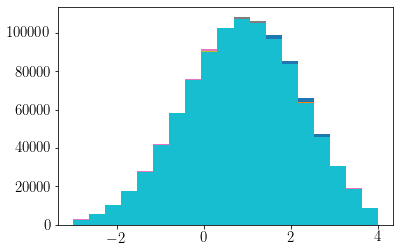

In [28]:
myns = []
for k in range(10):
    n,b,_ = plt.hist(theta0_G,bins=np.linspace(-3,4,20),weights=weights[k,-1, 1, :])
    myns+=[n]
    pass
myns = np.array(myns)

In [41]:
cov = np.array([[np.mean((myns[:,j] - np.mean(myns[:,j]))*(myns[:,i] - np.mean(myns[:,i]))) for i in range(len(myns))] for j in range(len(myns))])

In [50]:
cov_rel = np.array([np.sqrt(cov[i,i])/np.mean(myns[:,i]) for i in range(len(myns))])

In [43]:
corr = np.array([[cov[i,j]/(np.sqrt(cov[i,i])*np.sqrt(cov[j,j])) for i in range(len(myns))] for j in range(len(myns))])

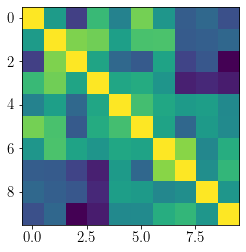

In [46]:
plt.imshow(corr)

In [51]:
cov_rel

array([0.0362875 , 0.02770729, 0.02015974, 0.00925533, 0.0070882 ,
       0.00652784, 0.00574226, 0.00470346, 0.00612816, 0.00625122])